In [2]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import LeaveOneGroupOut, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, make_scorer, classification_report, confusion_matrix


In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
# Define paths
data_dir = "/content/gdrive/MyDrive/ABC/data"
phq9_path = "/content/gdrive/MyDrive/ABC/groundtruth/phq9.csv"

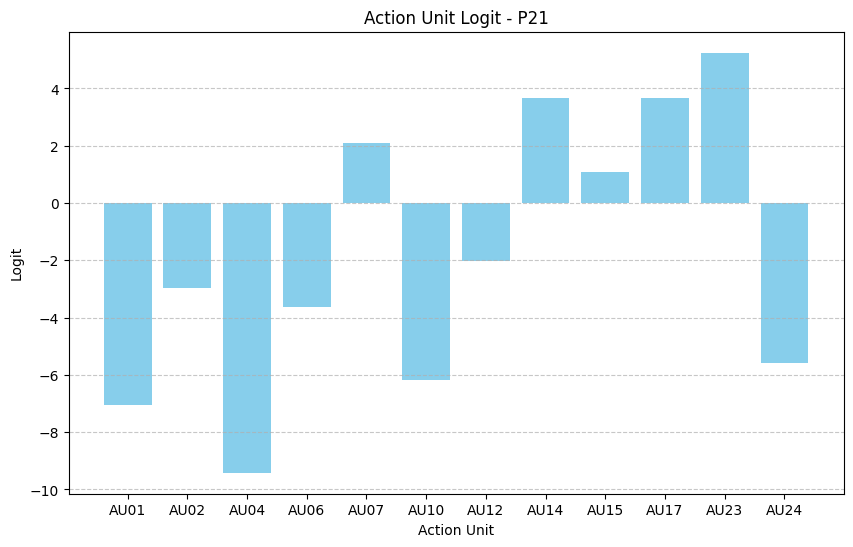

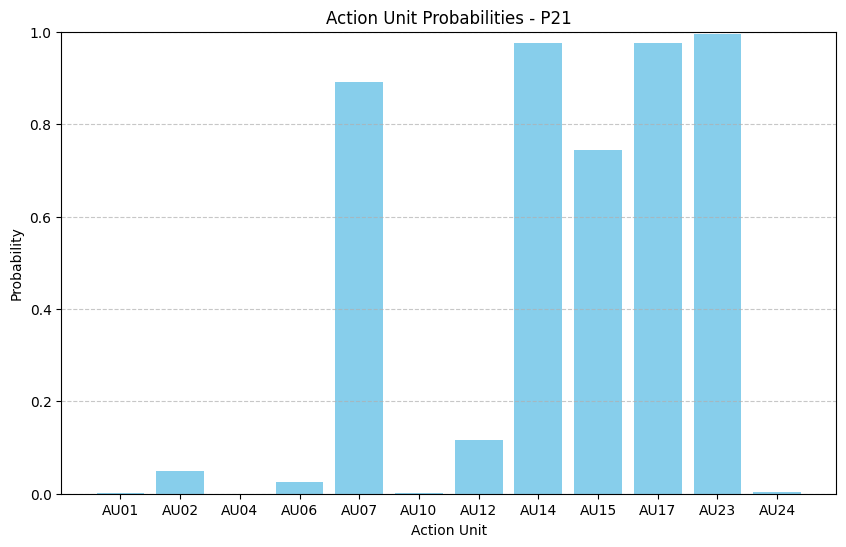

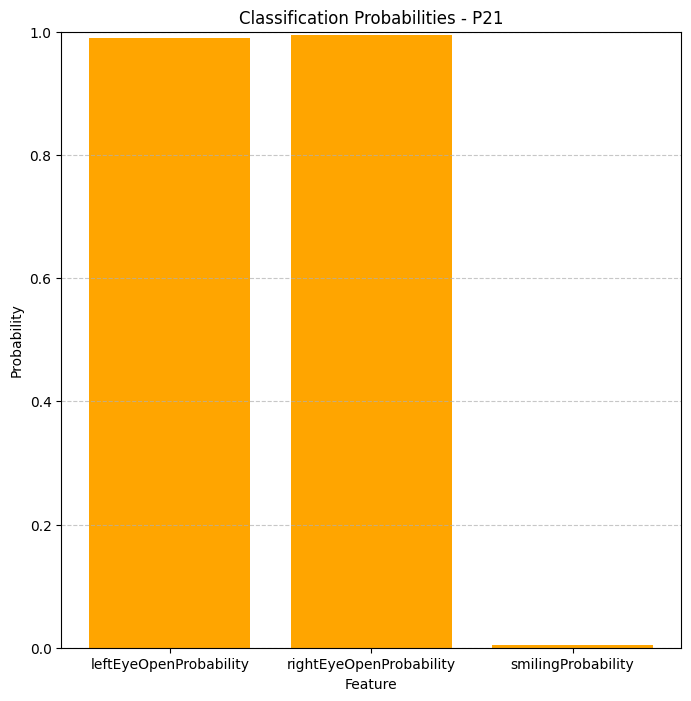

Bounding Box for P21: 178 963 860 1661


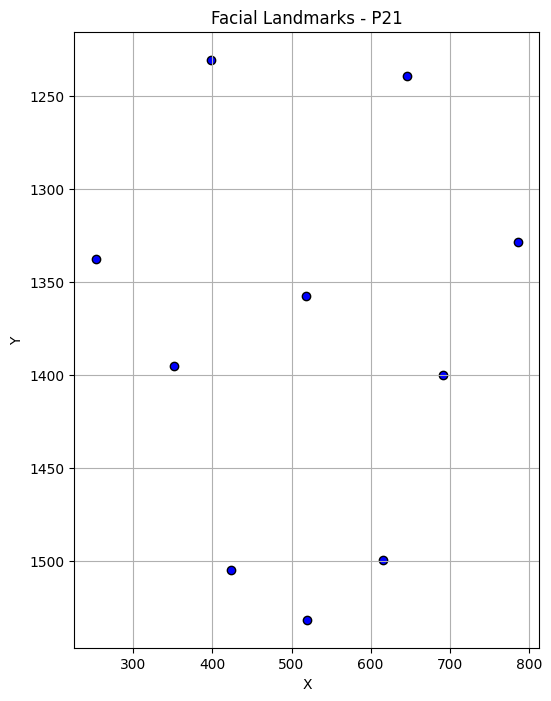

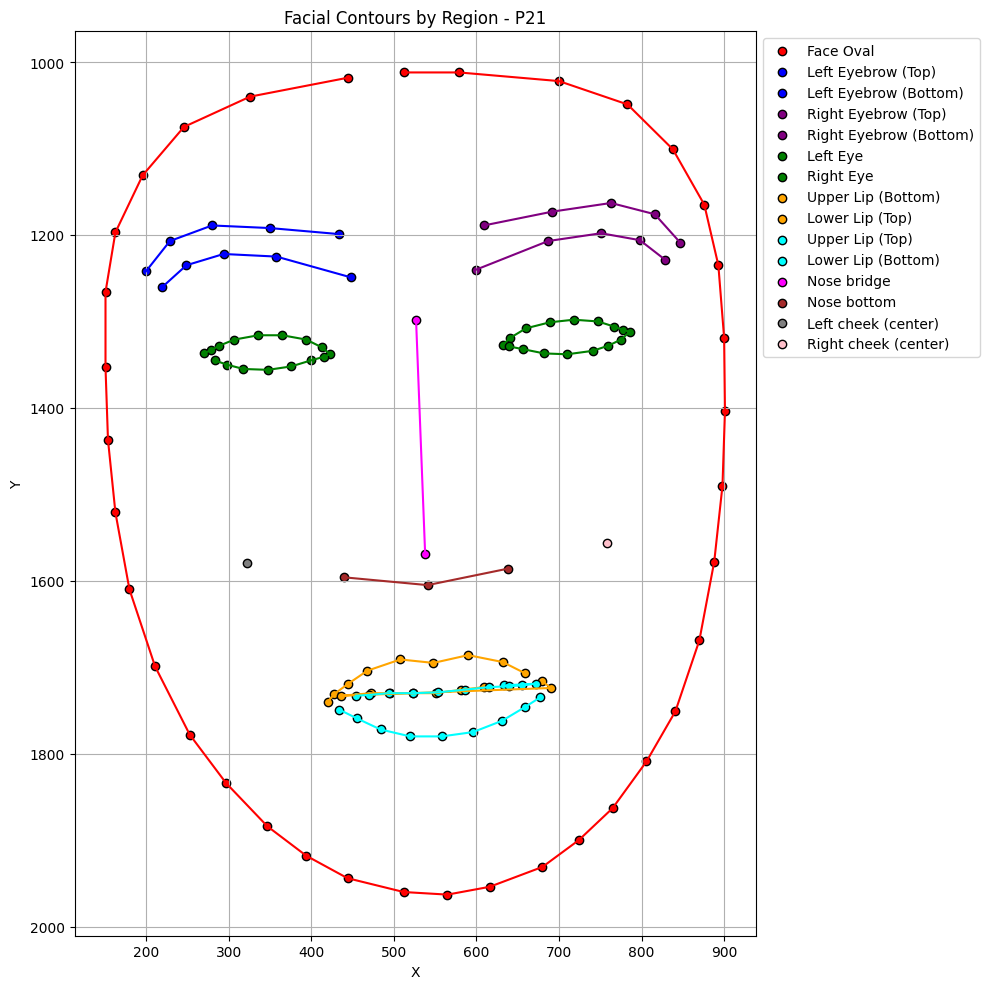

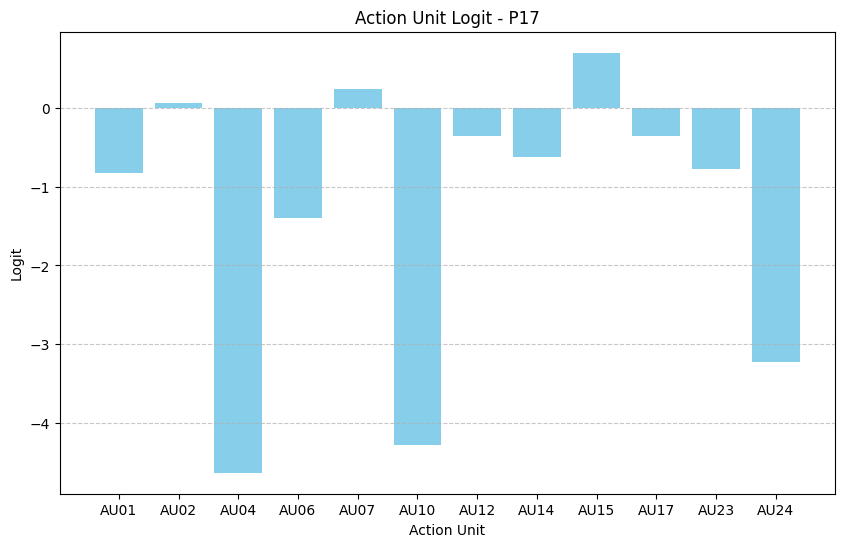

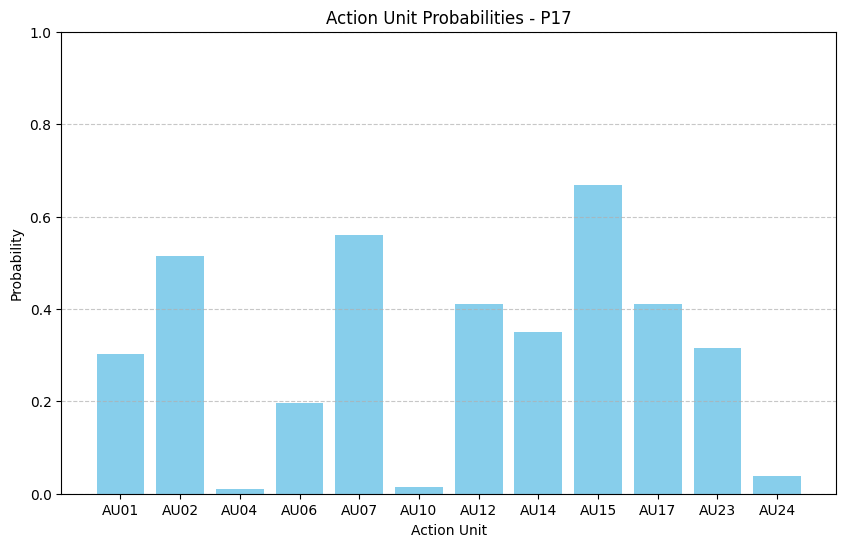

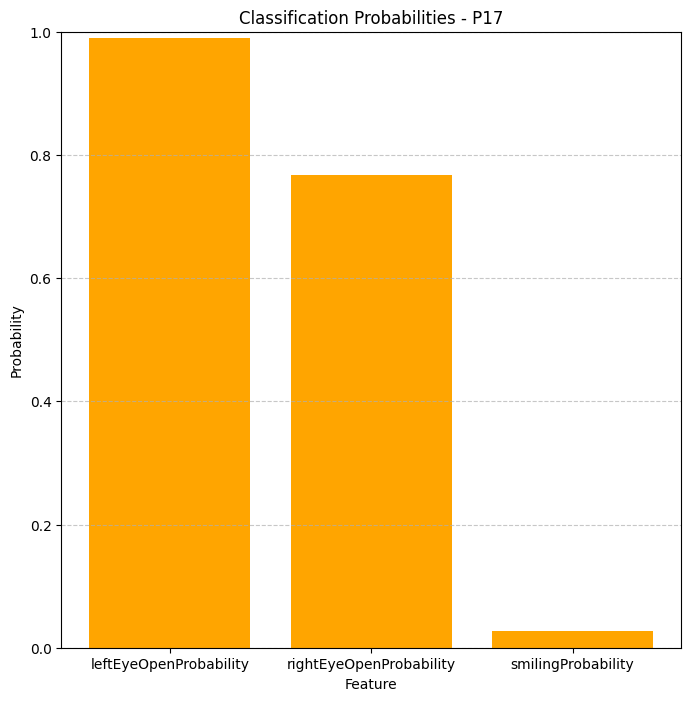

Bounding Box for P17: 131 1134 943 1963


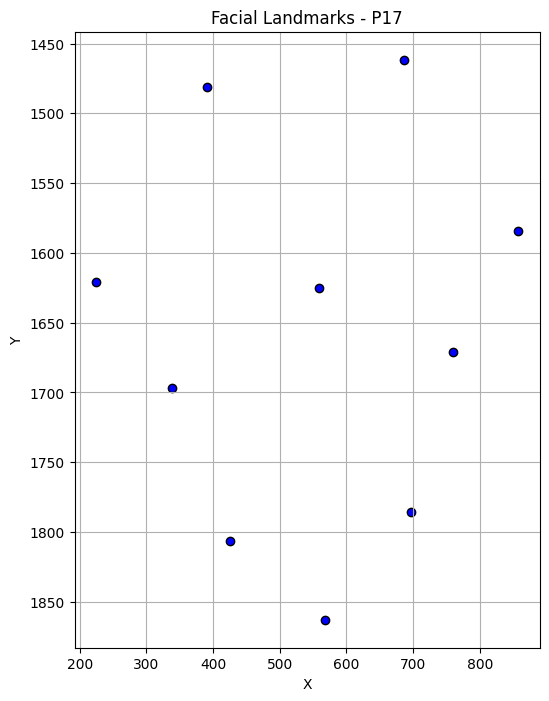

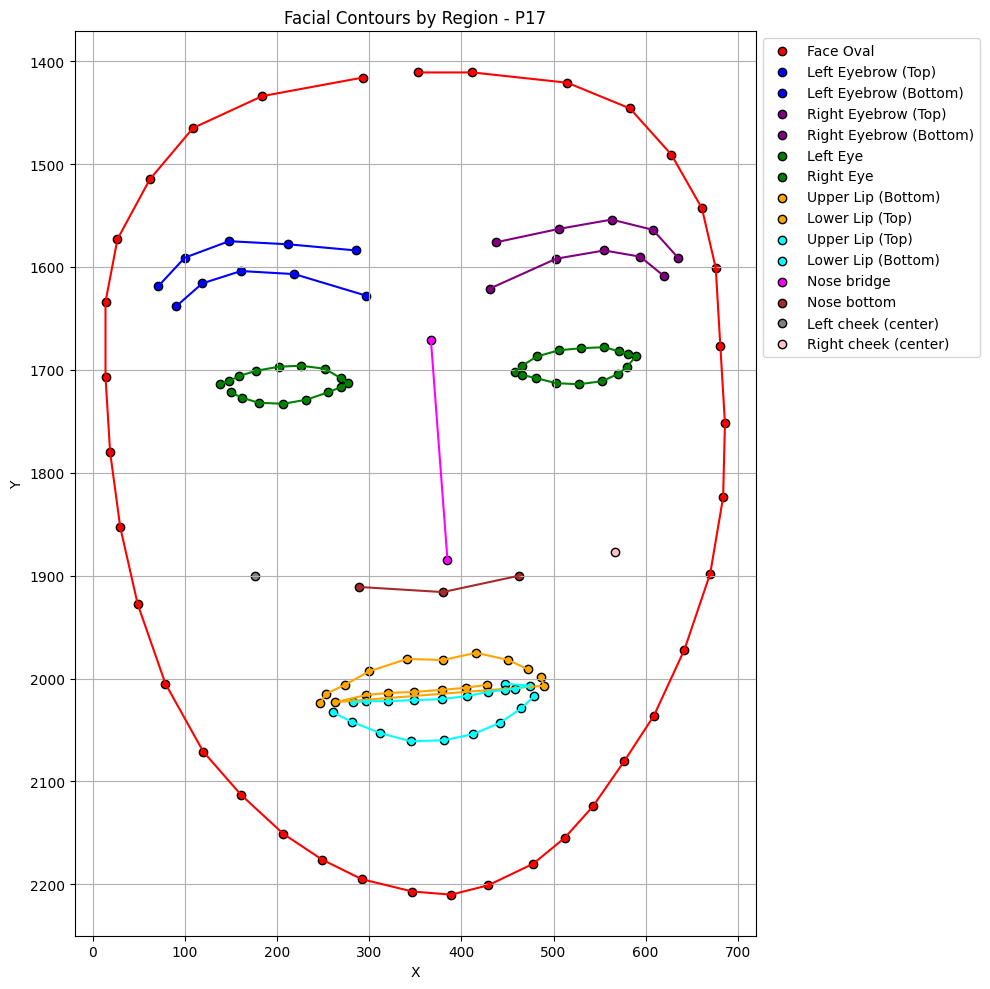

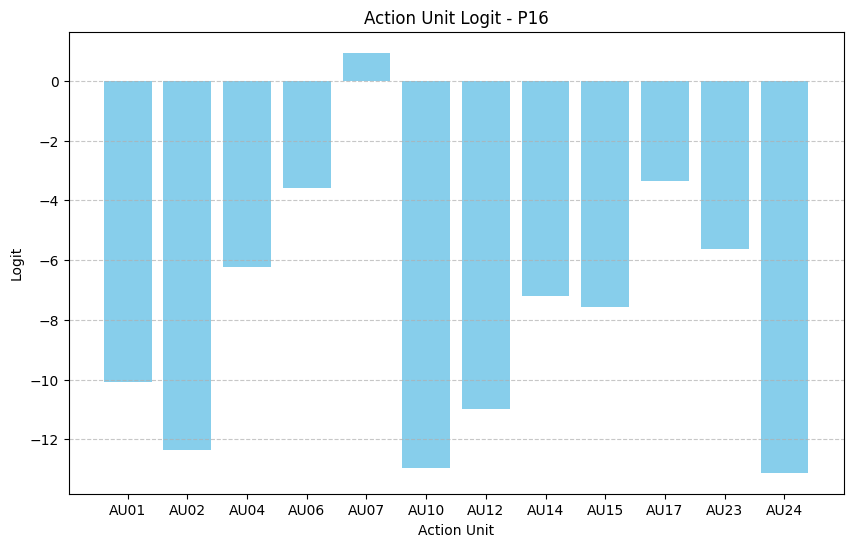

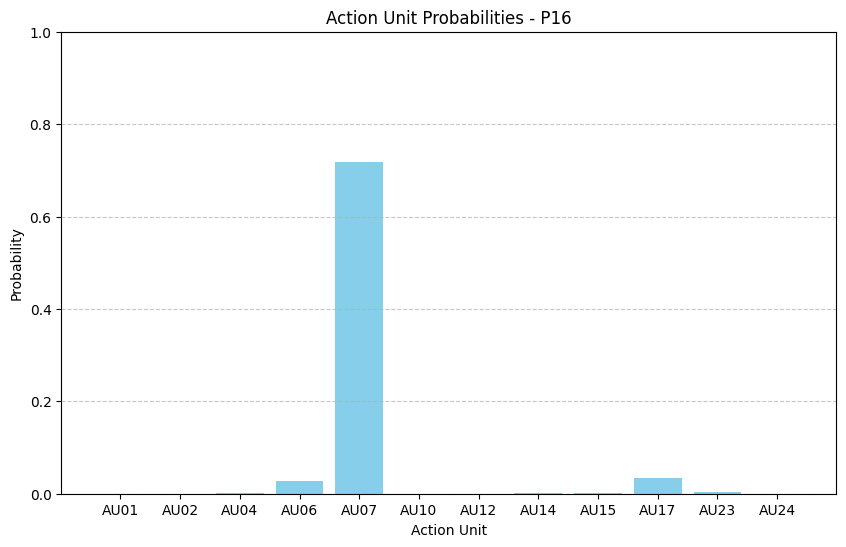

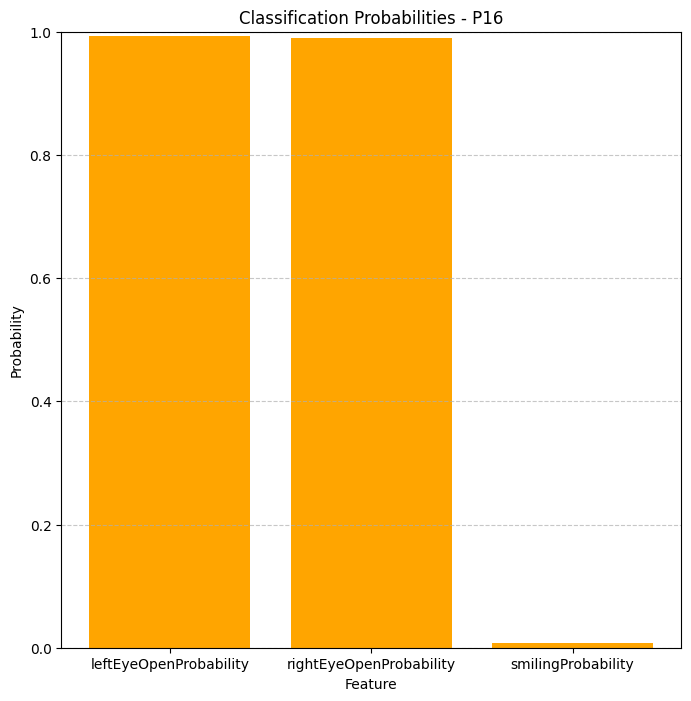

Bounding Box for P16: 189 711 984 1523


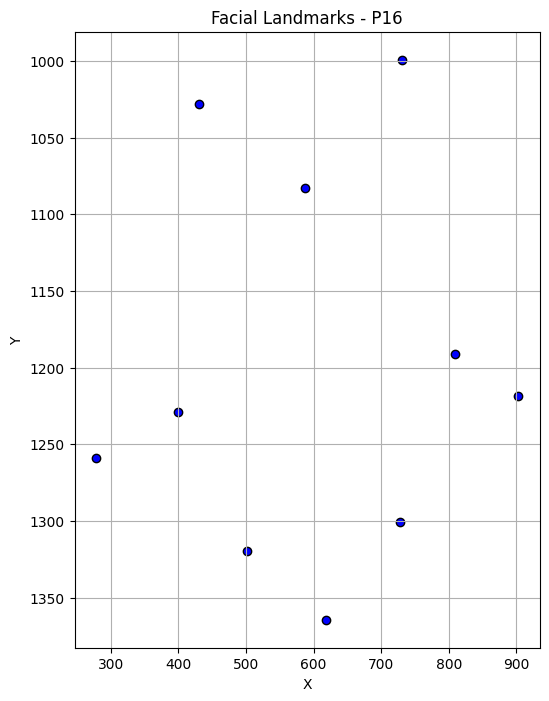

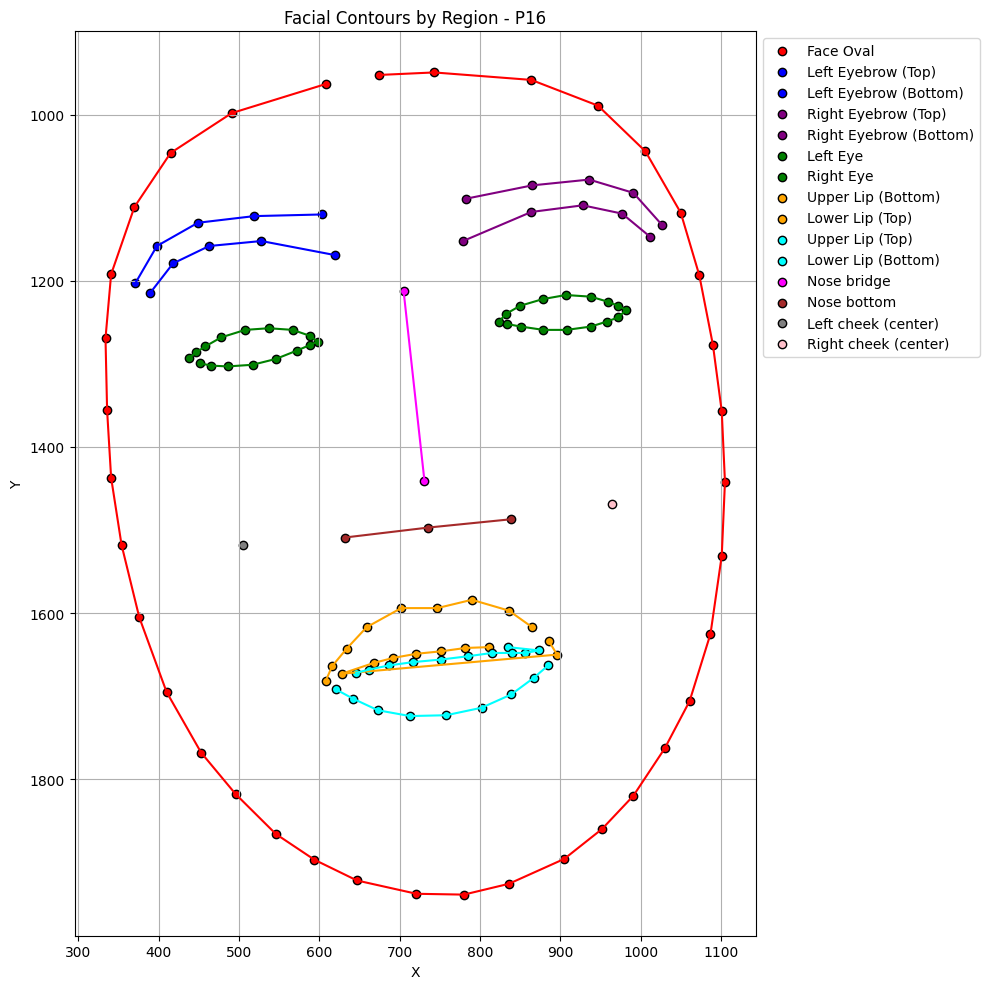

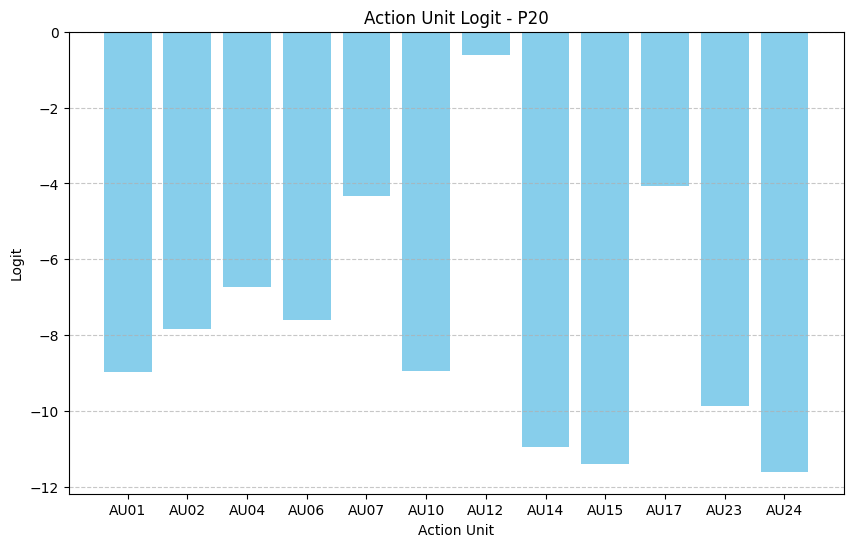

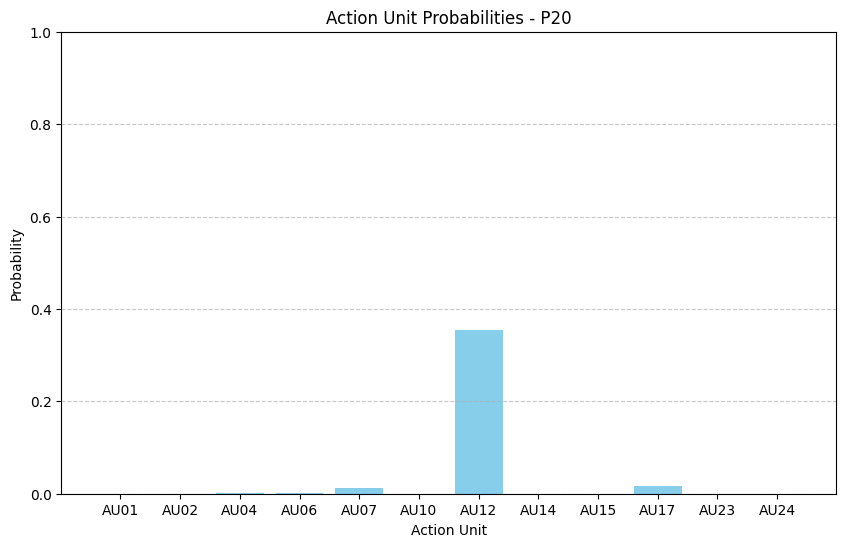

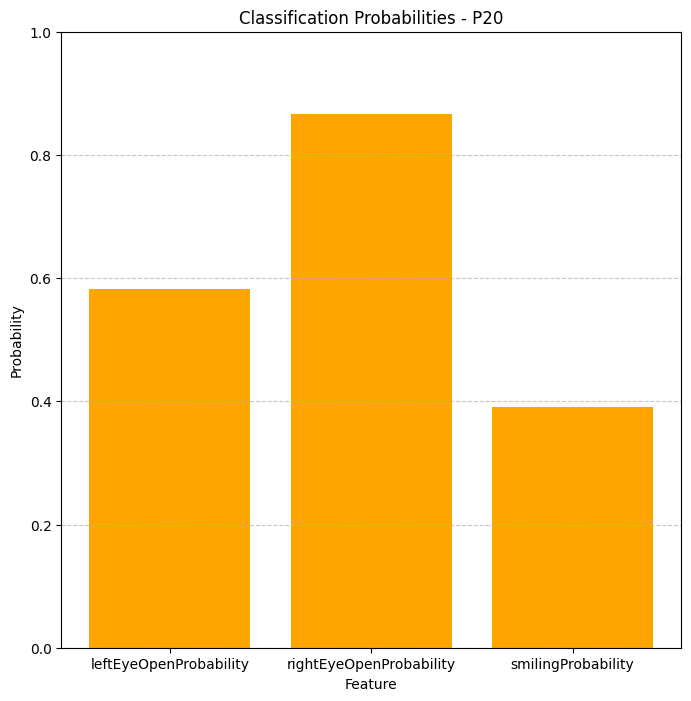

Bounding Box for P20: 271 1221 939 1904


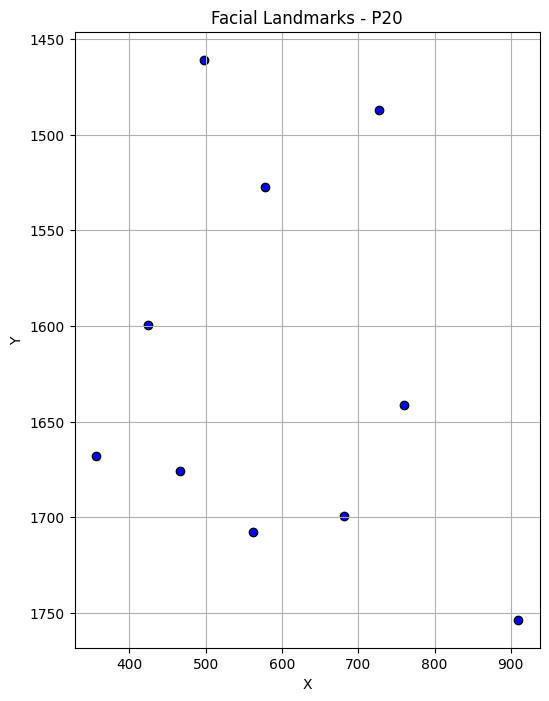

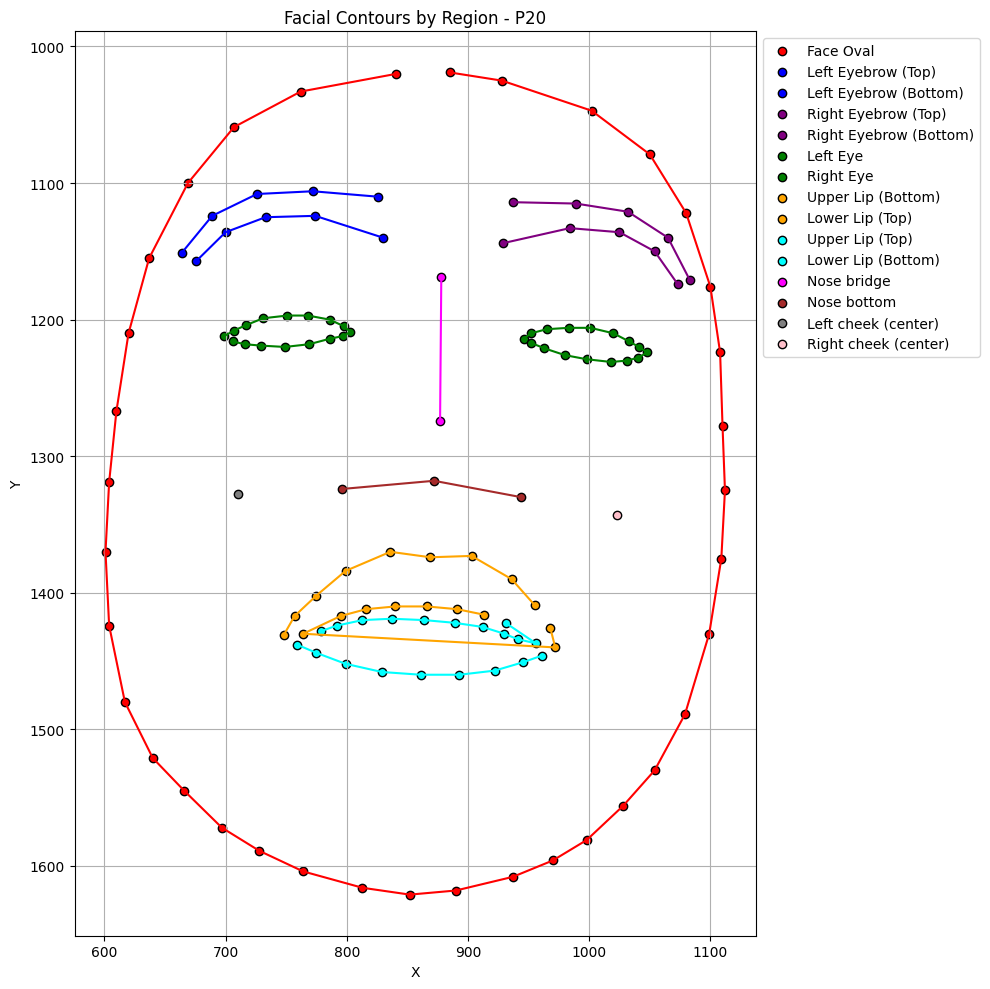

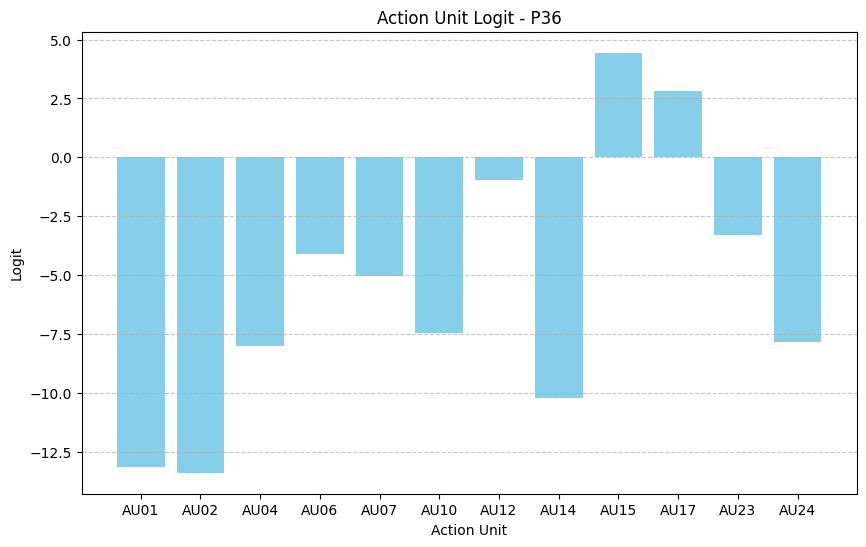

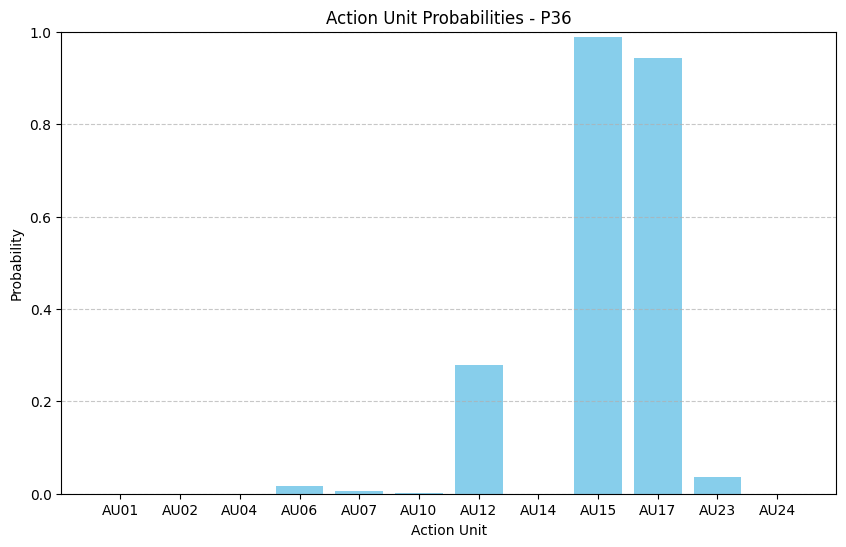

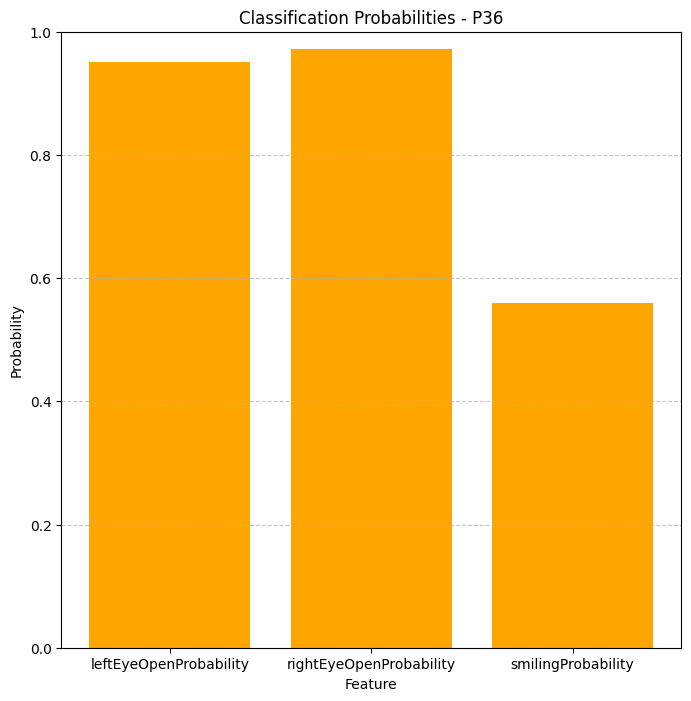

Bounding Box for P36: 5 1041 892 2006


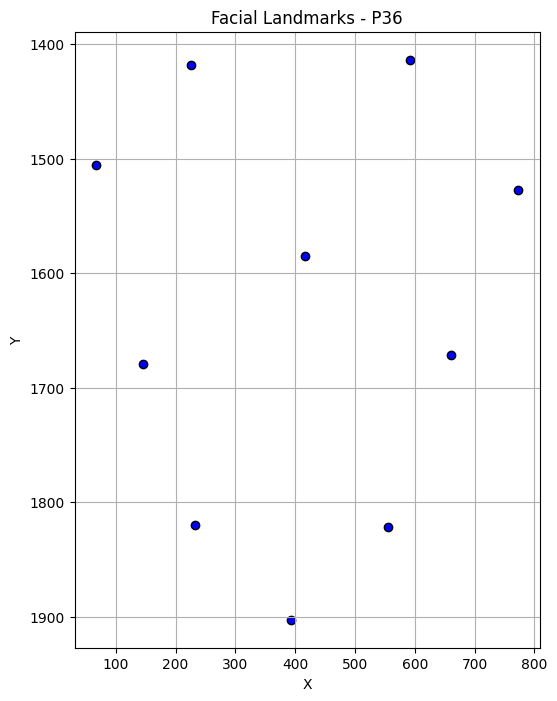

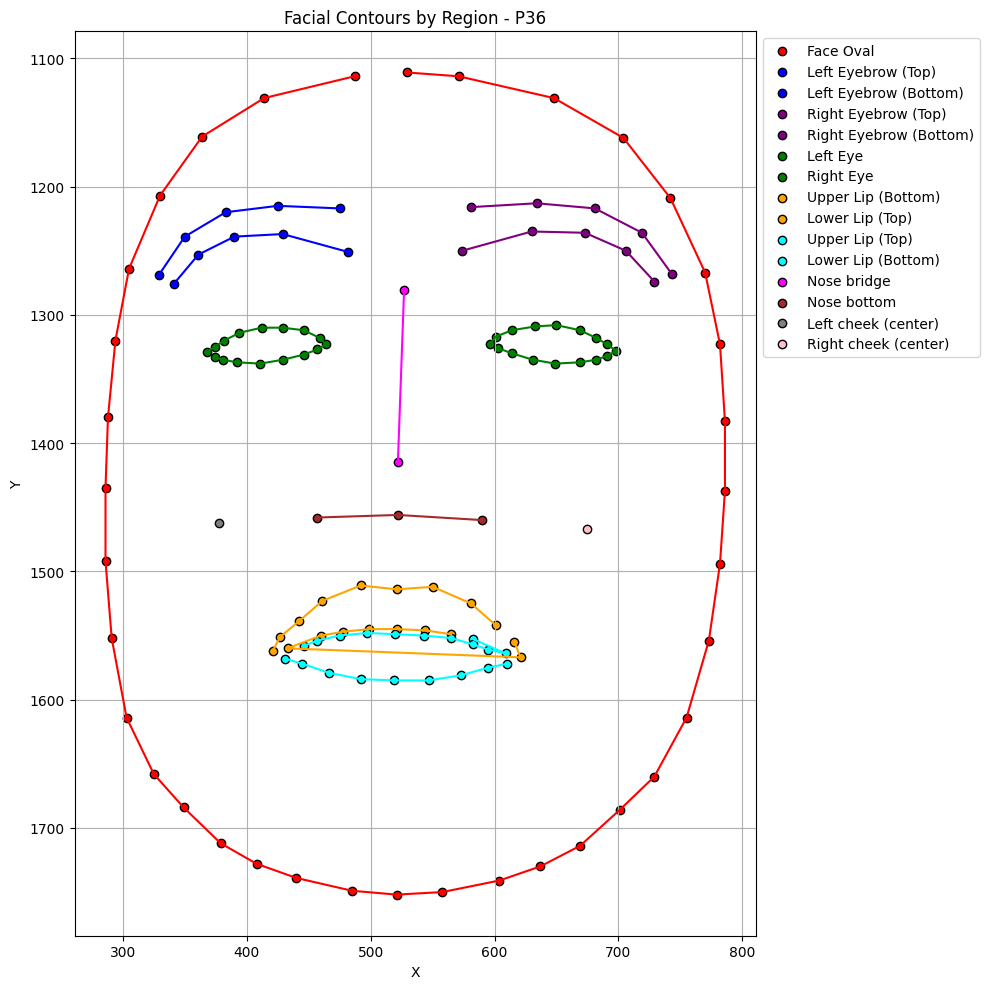

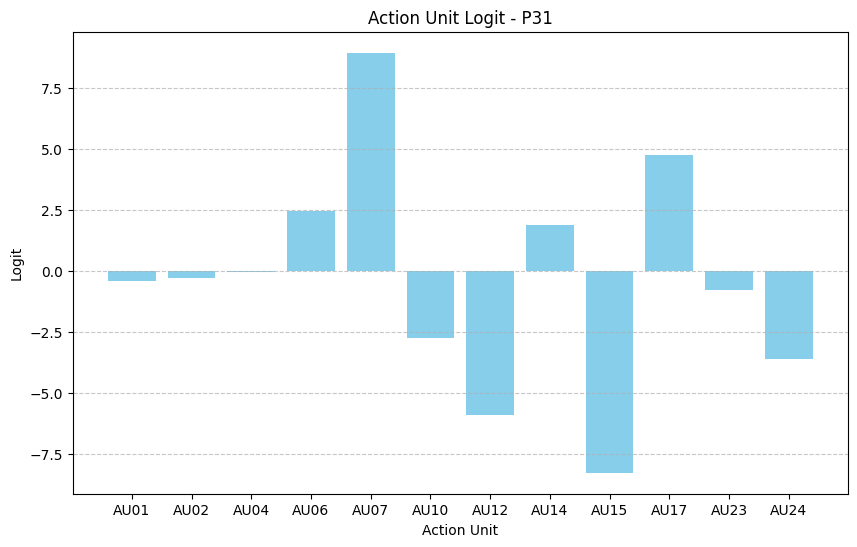

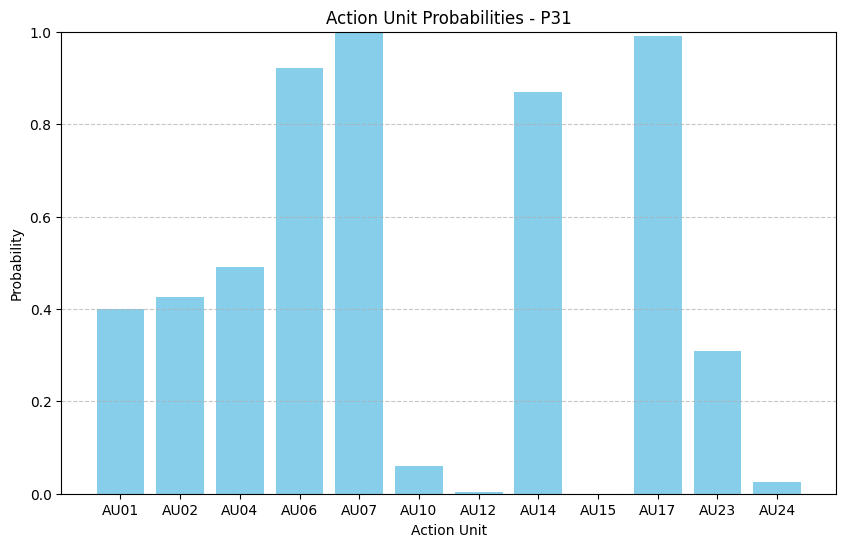

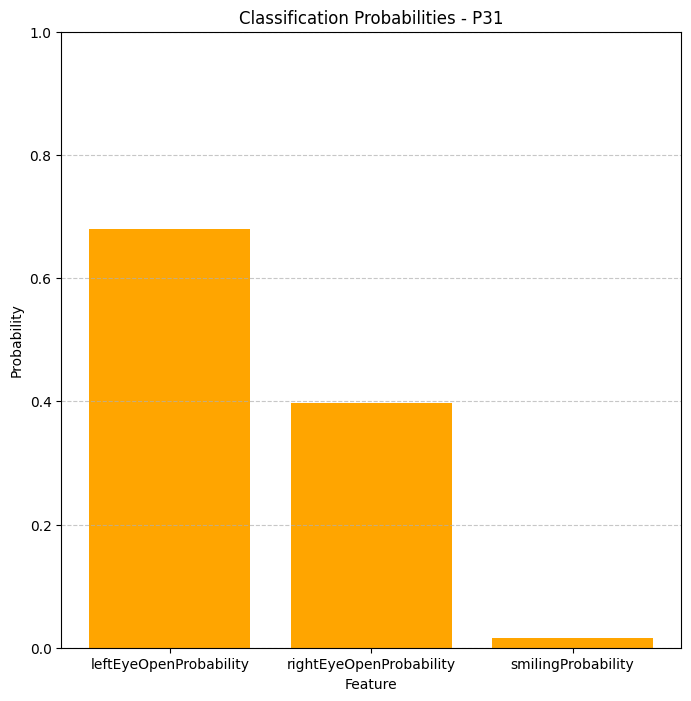

Bounding Box for P31: 251 1156 937 1857


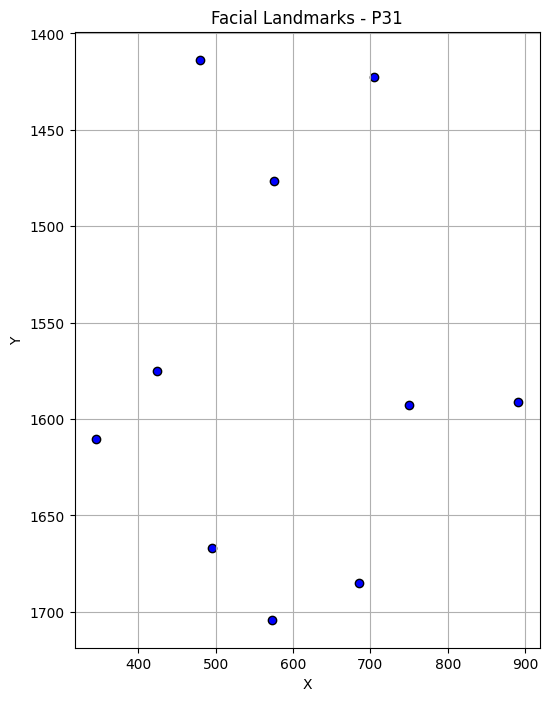

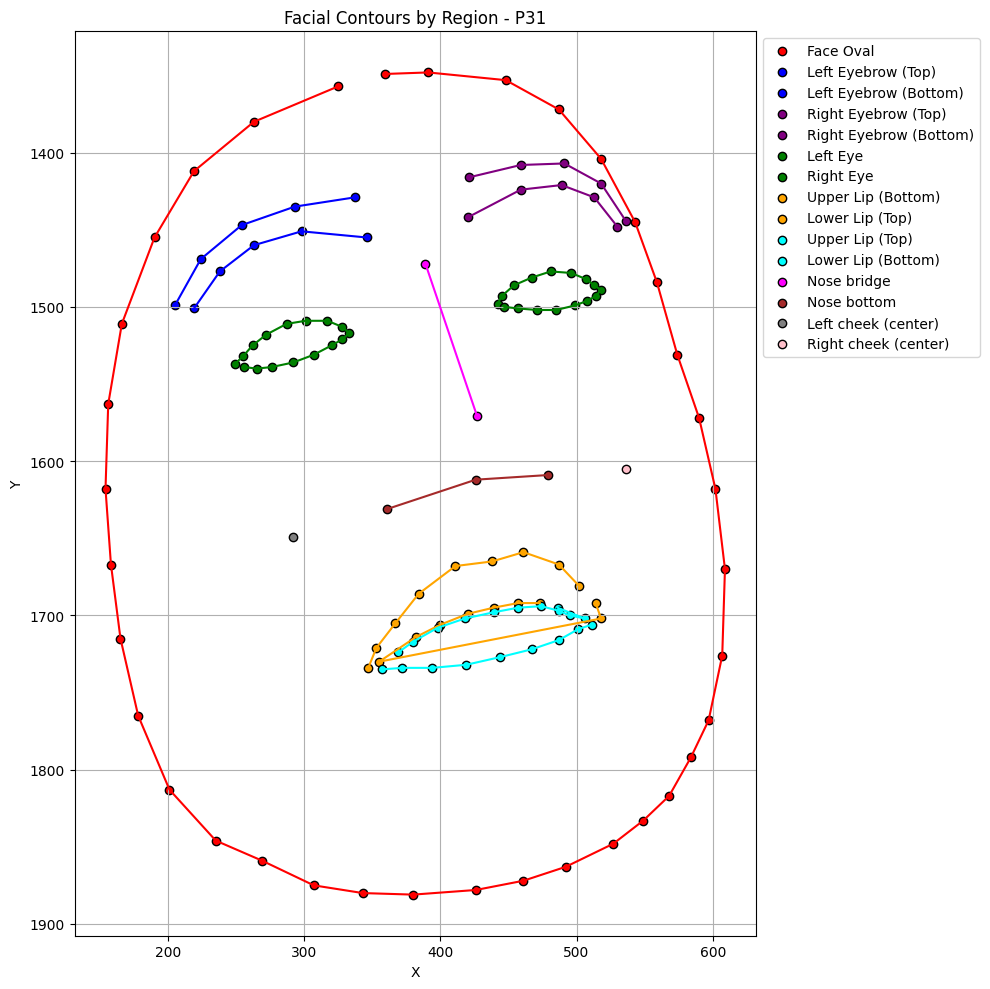

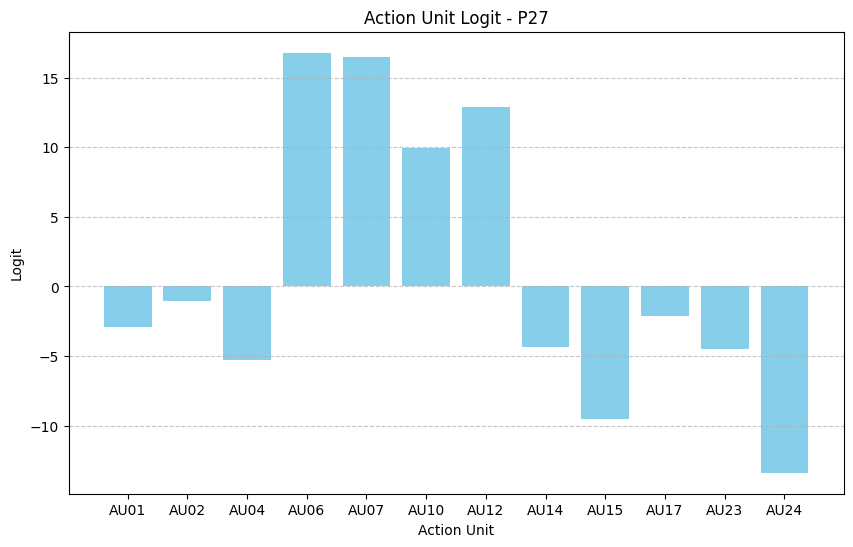

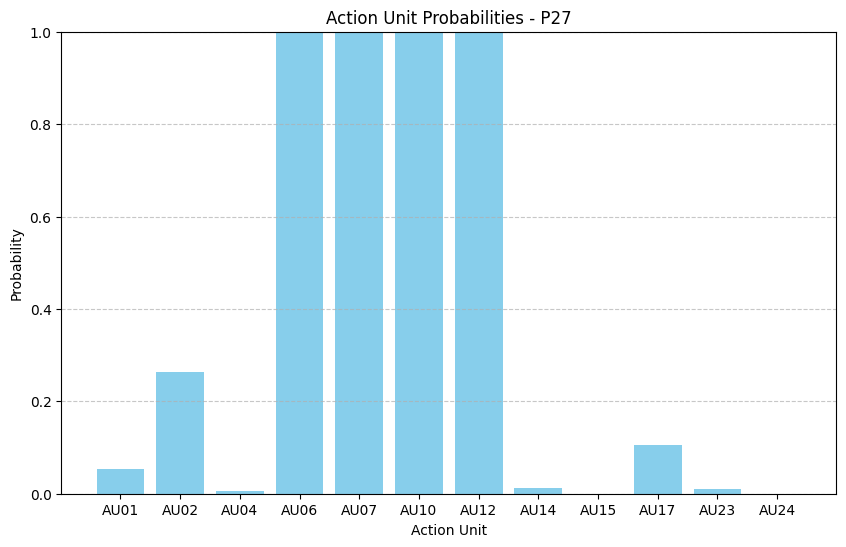

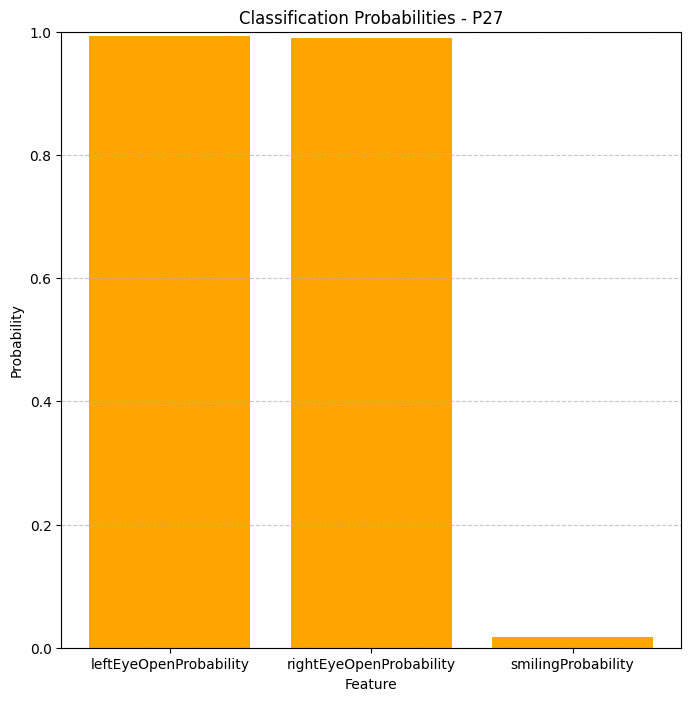

Bounding Box for P27: 399 1141 1100 1842


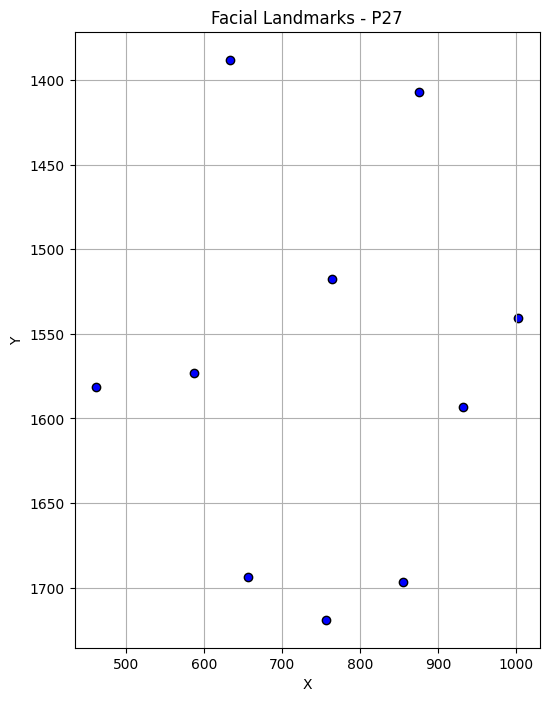

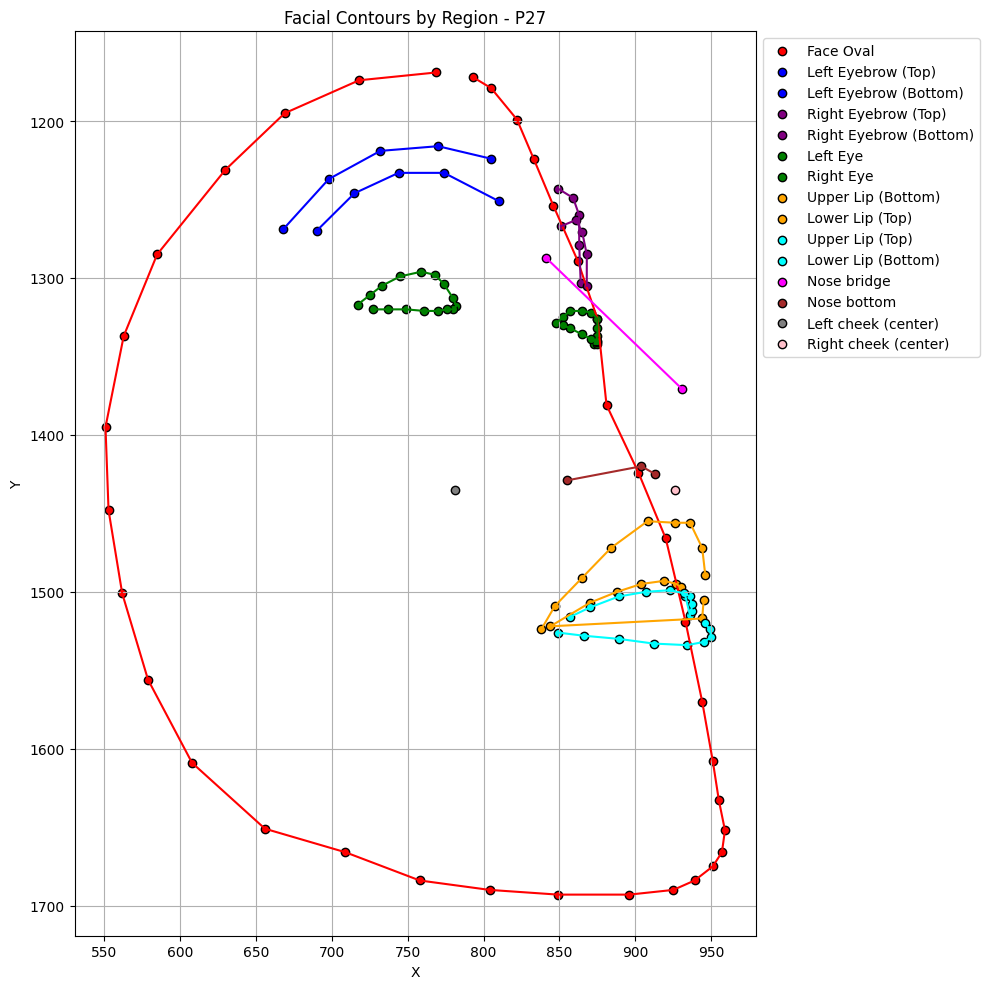

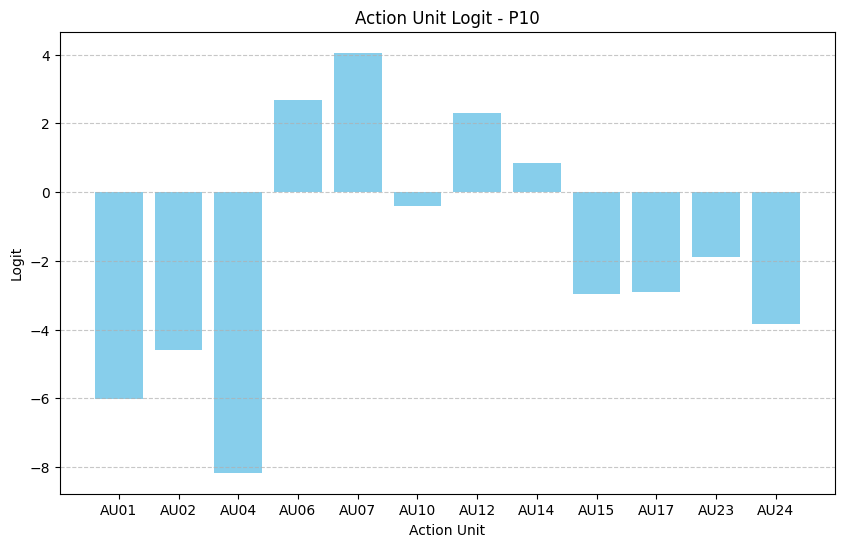

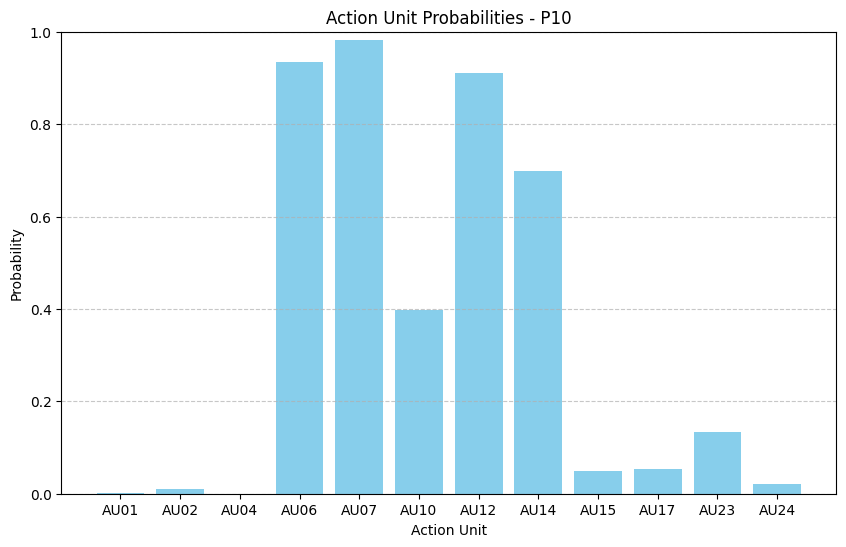

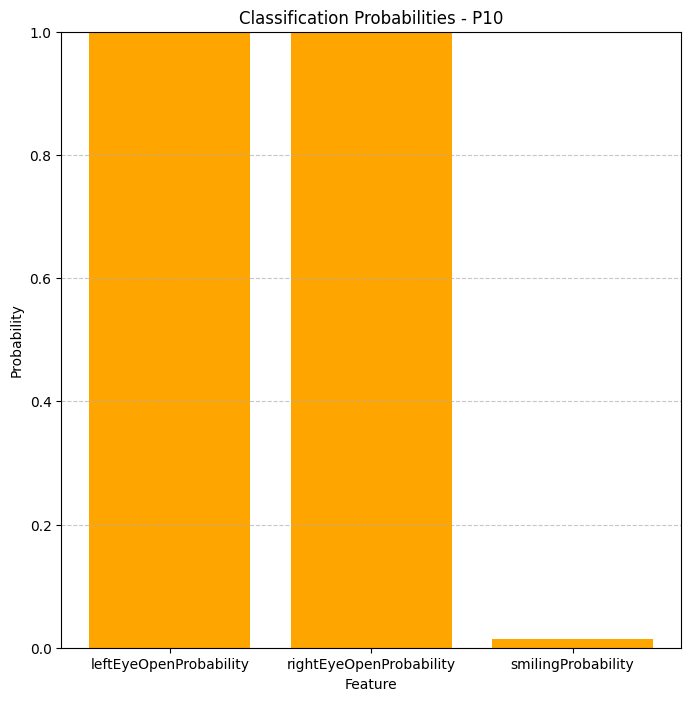

Bounding Box for P10: 88 1236 922 2069


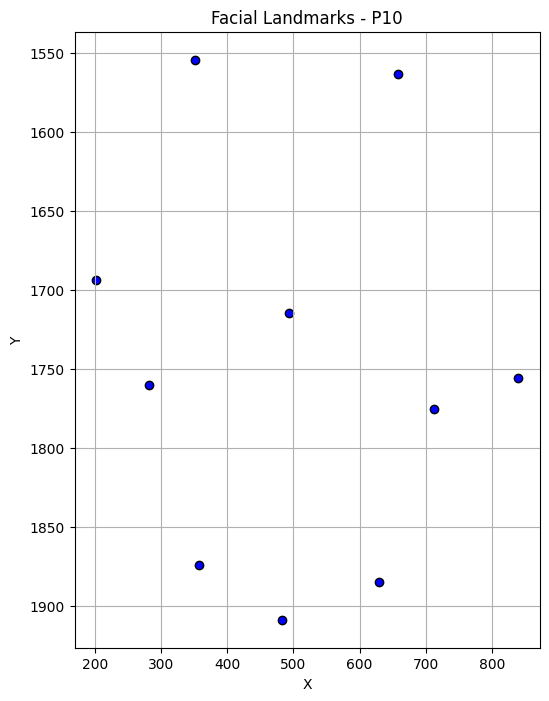

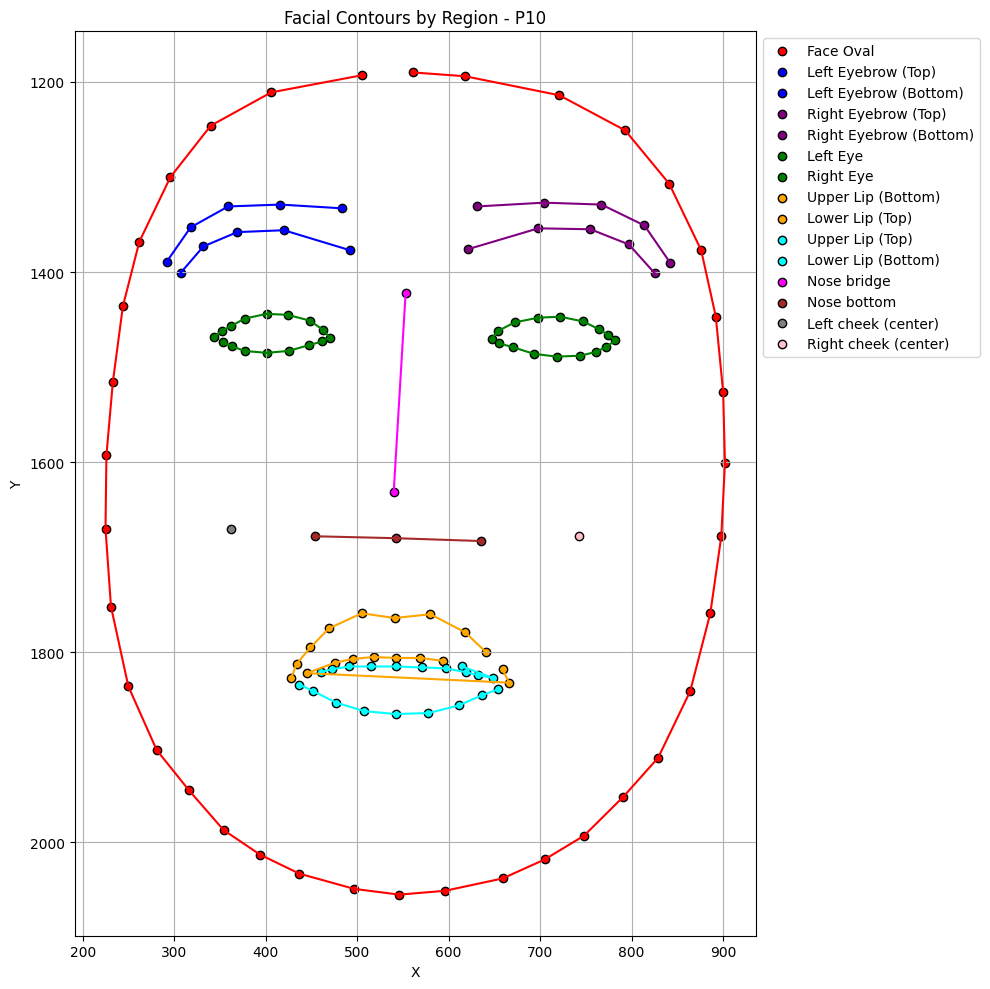

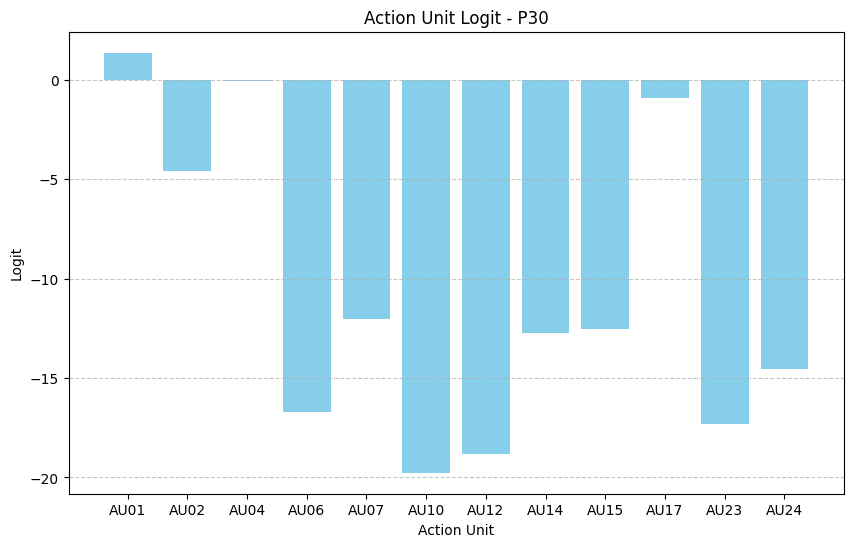

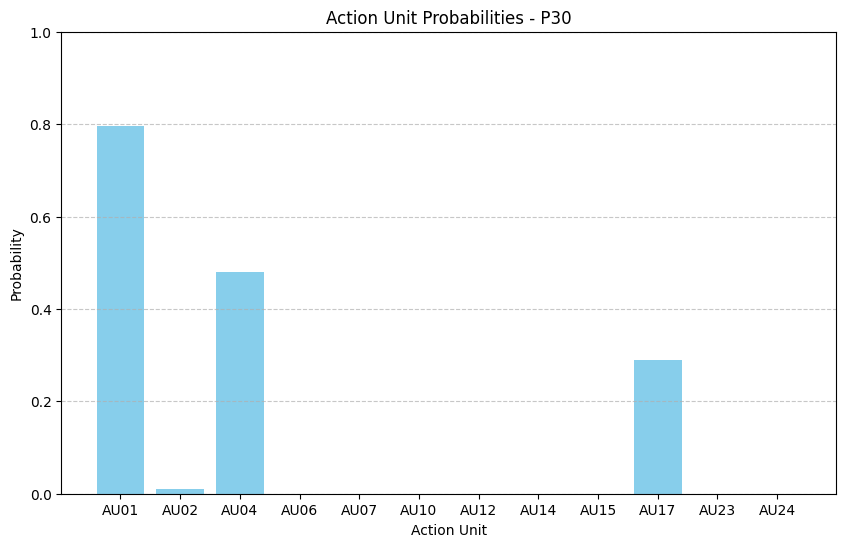

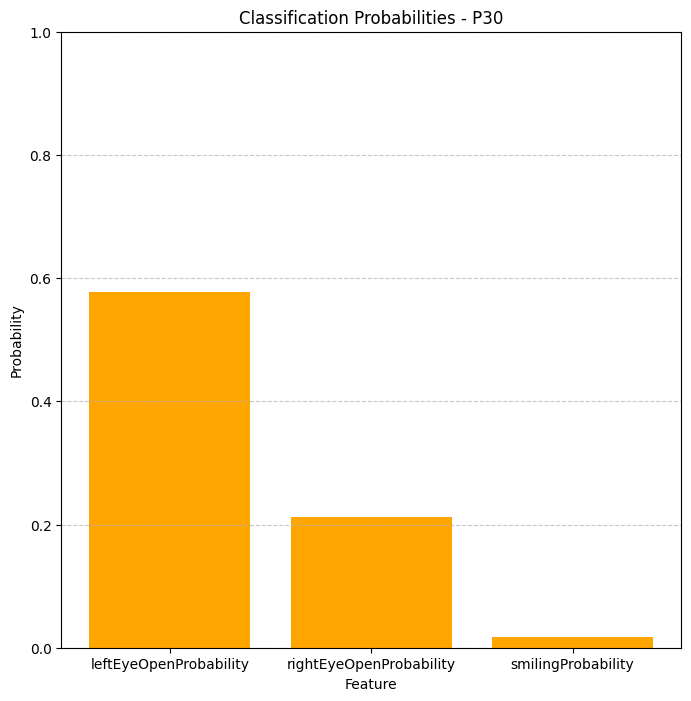

Bounding Box for P30: 401 1024 1027 1651


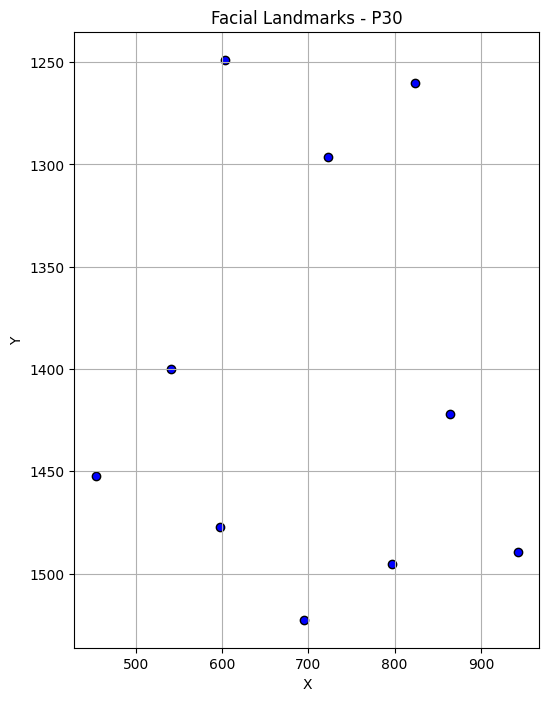

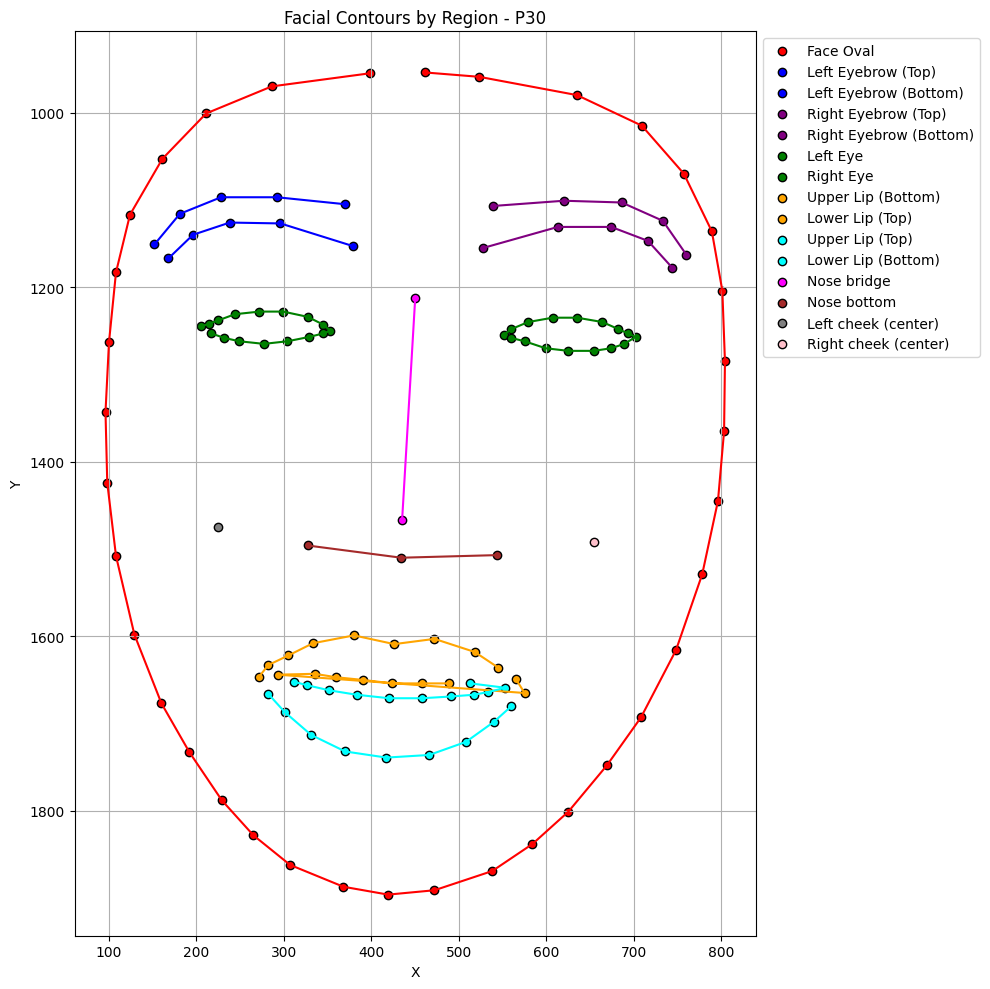

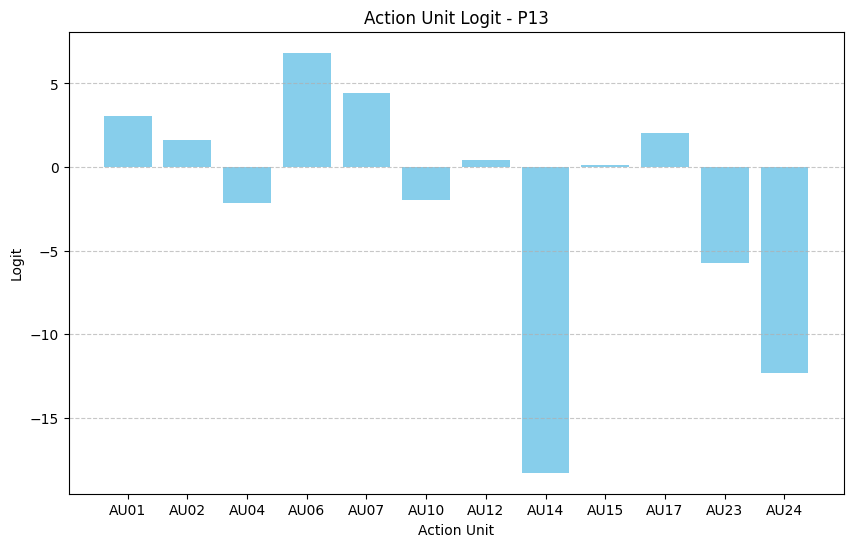

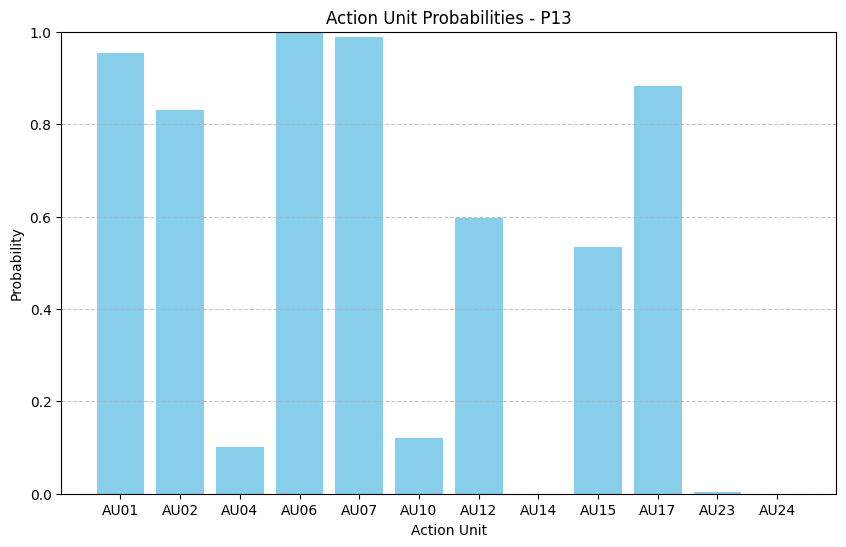

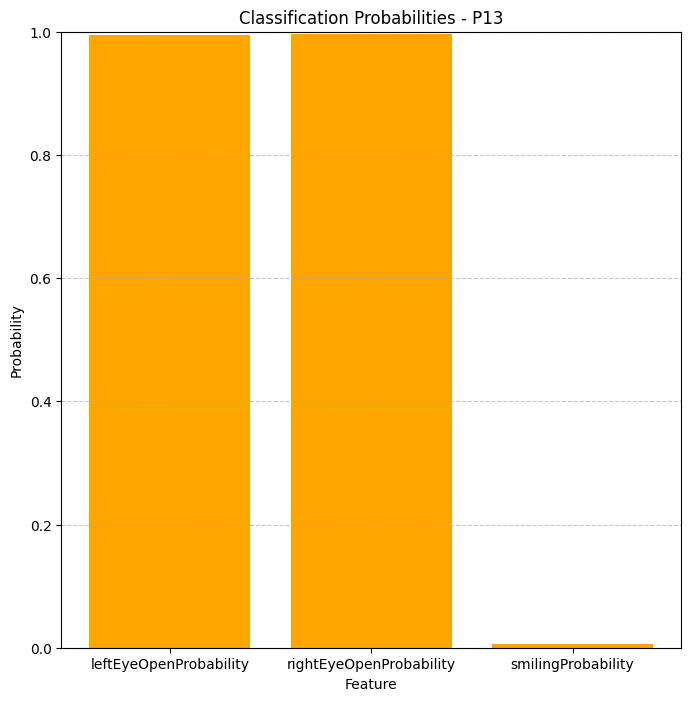

Bounding Box for P13: 377 780 1206 1610


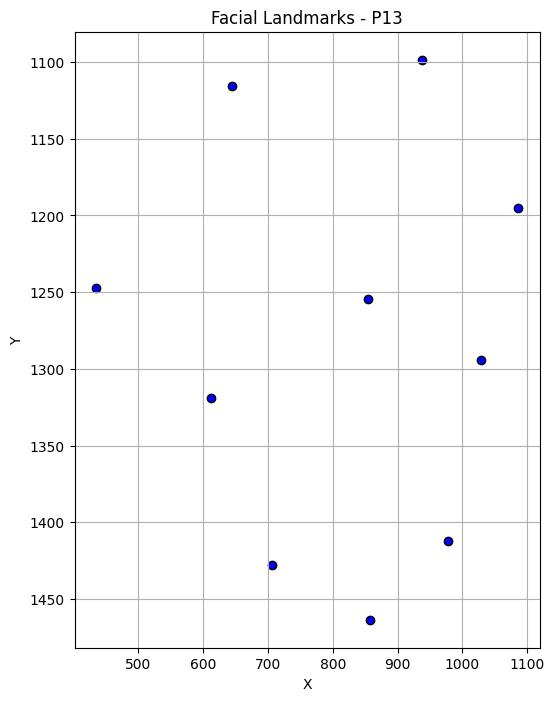

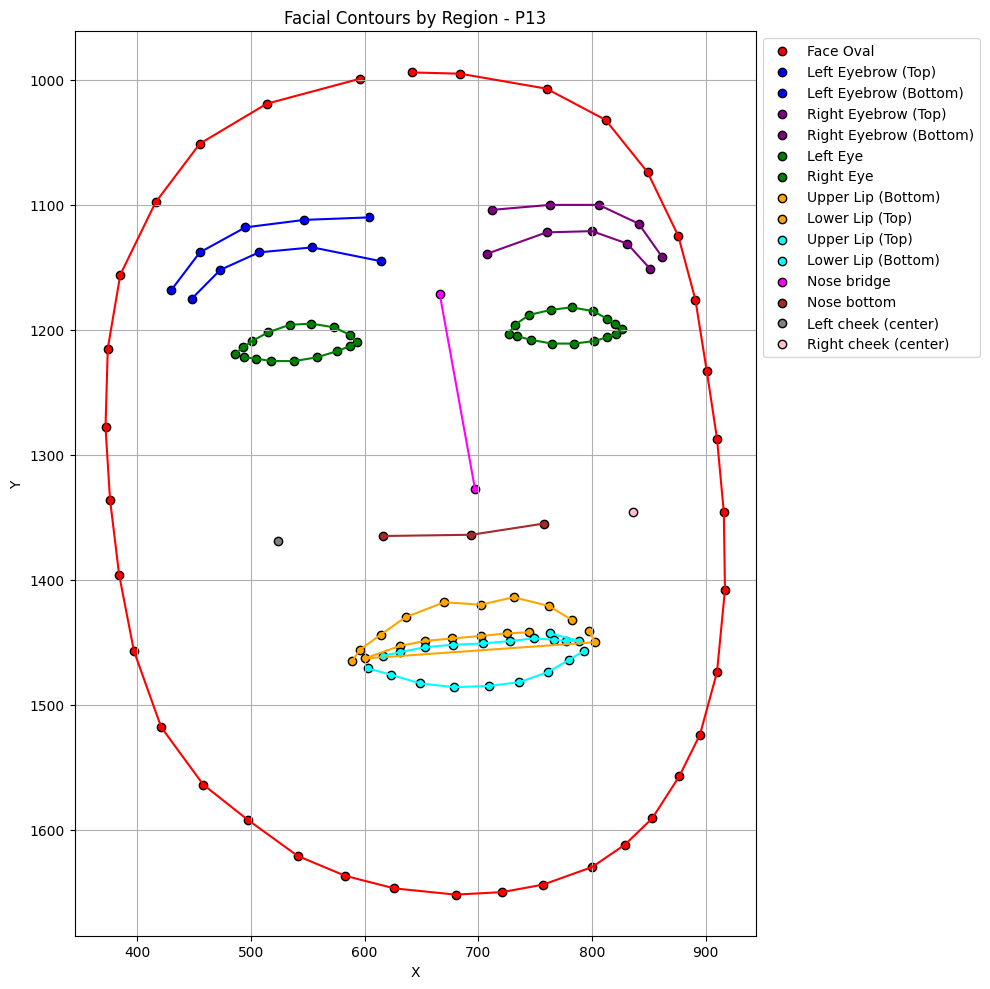

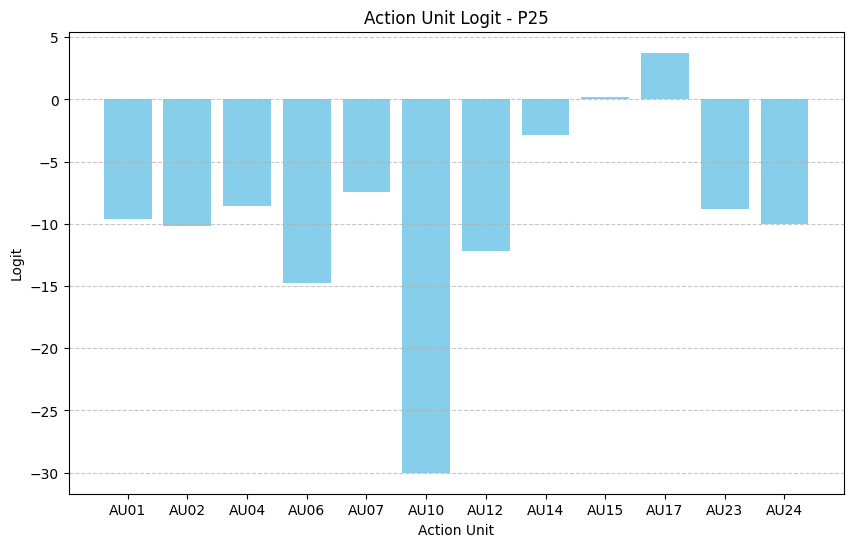

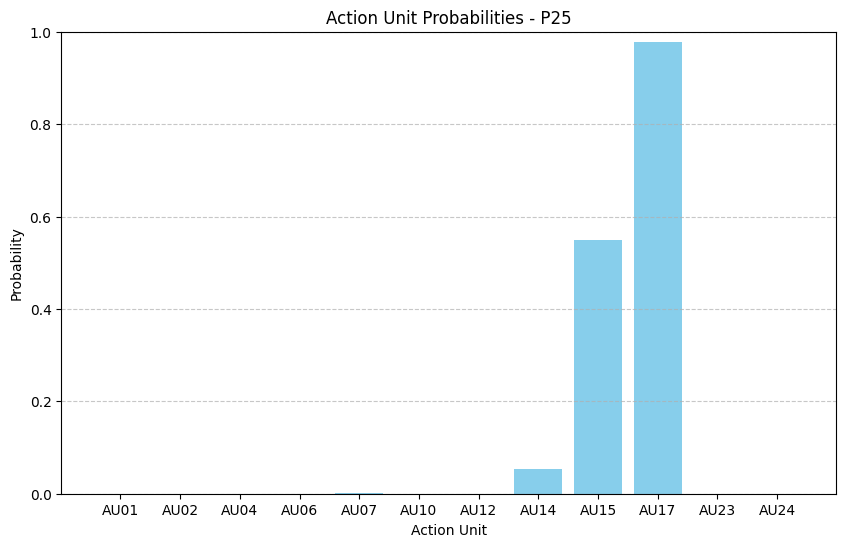

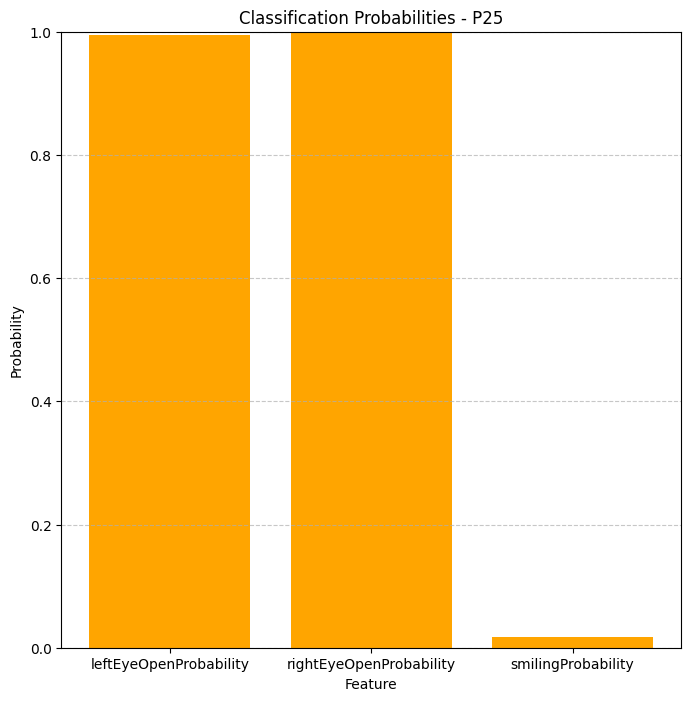

Bounding Box for P25: 168 1174 963 1952


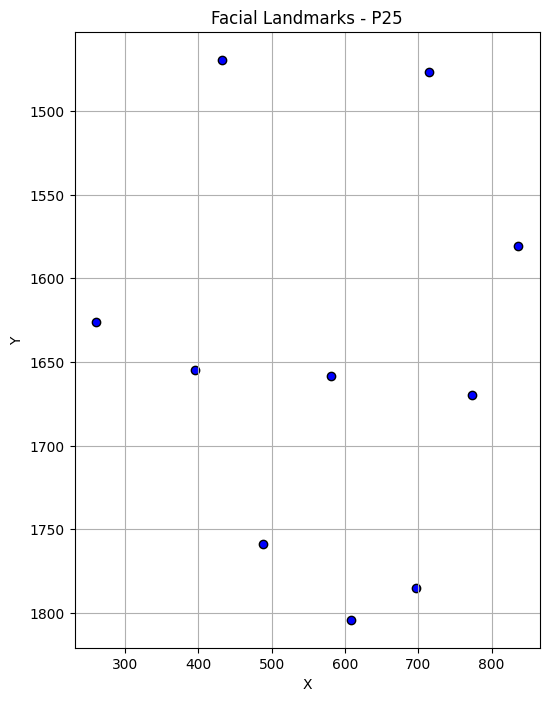

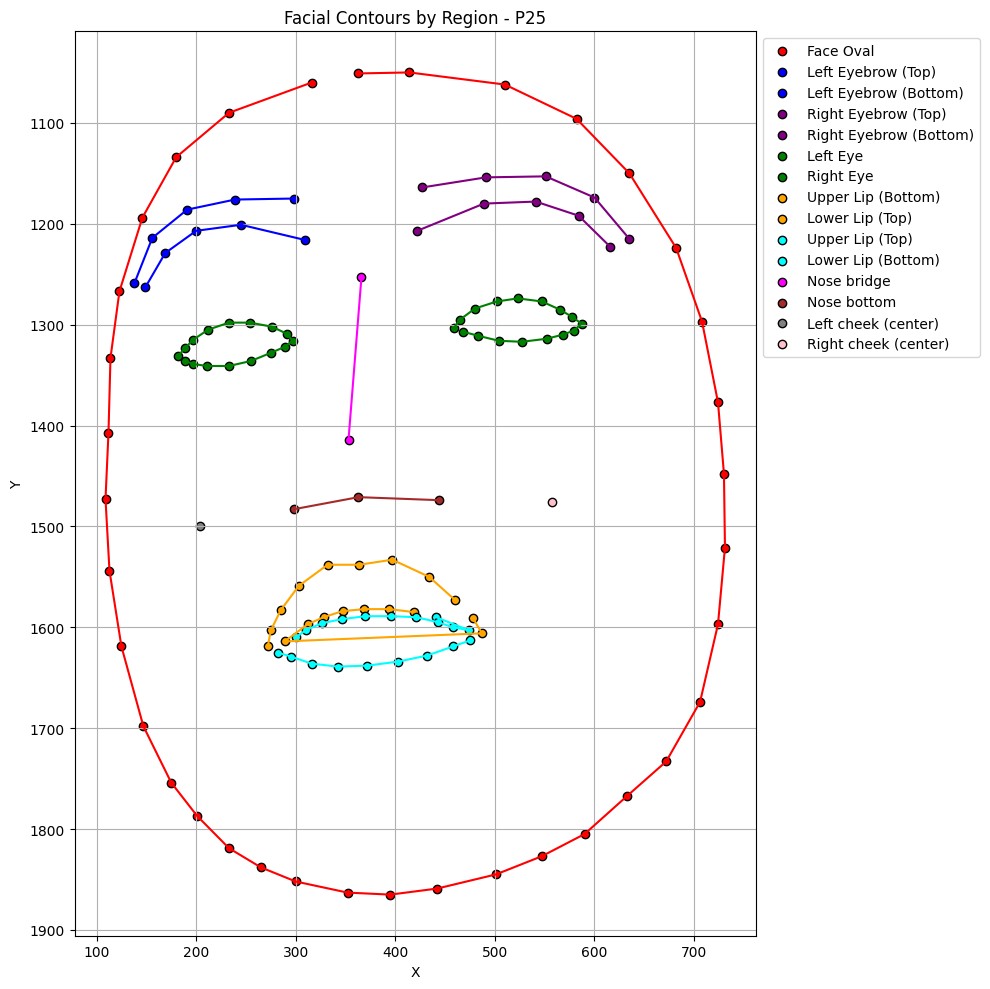

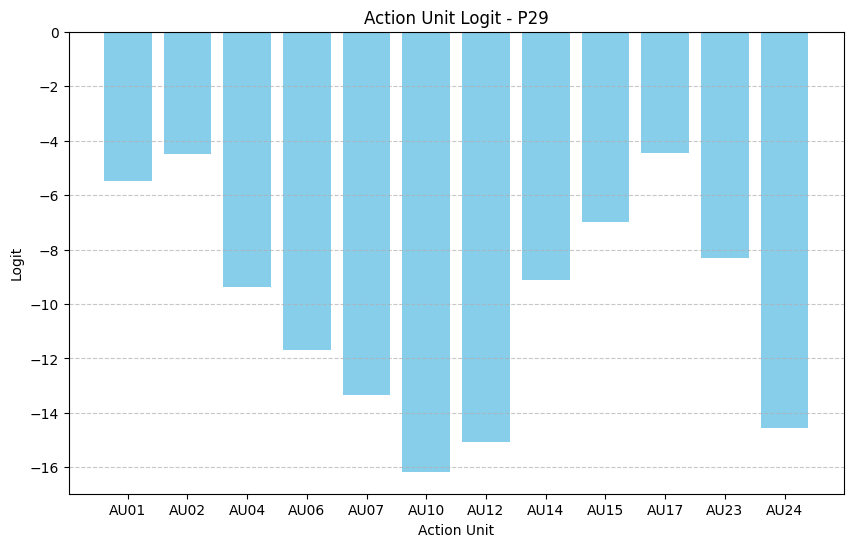

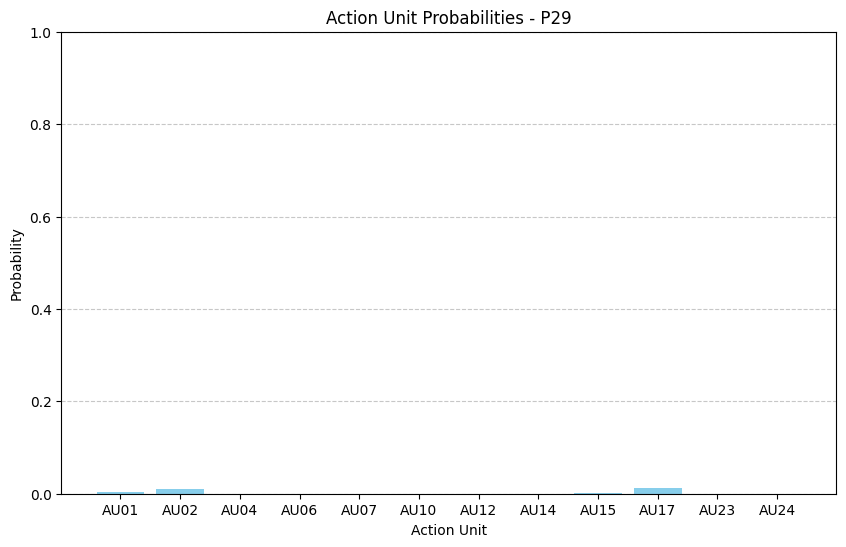

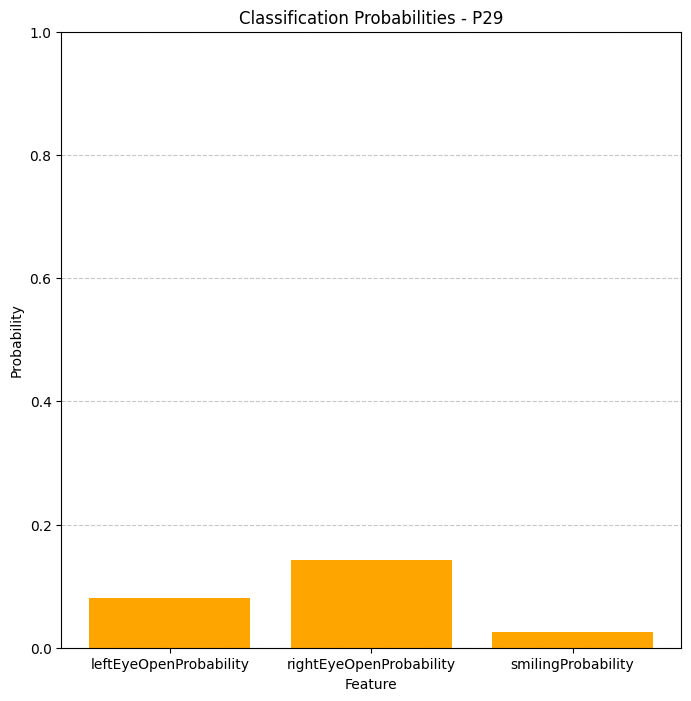

Bounding Box for P29: 12 837 757 1581


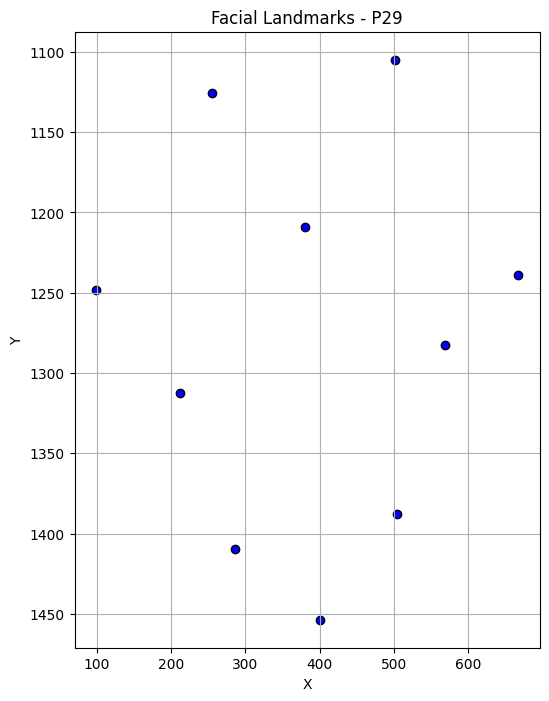

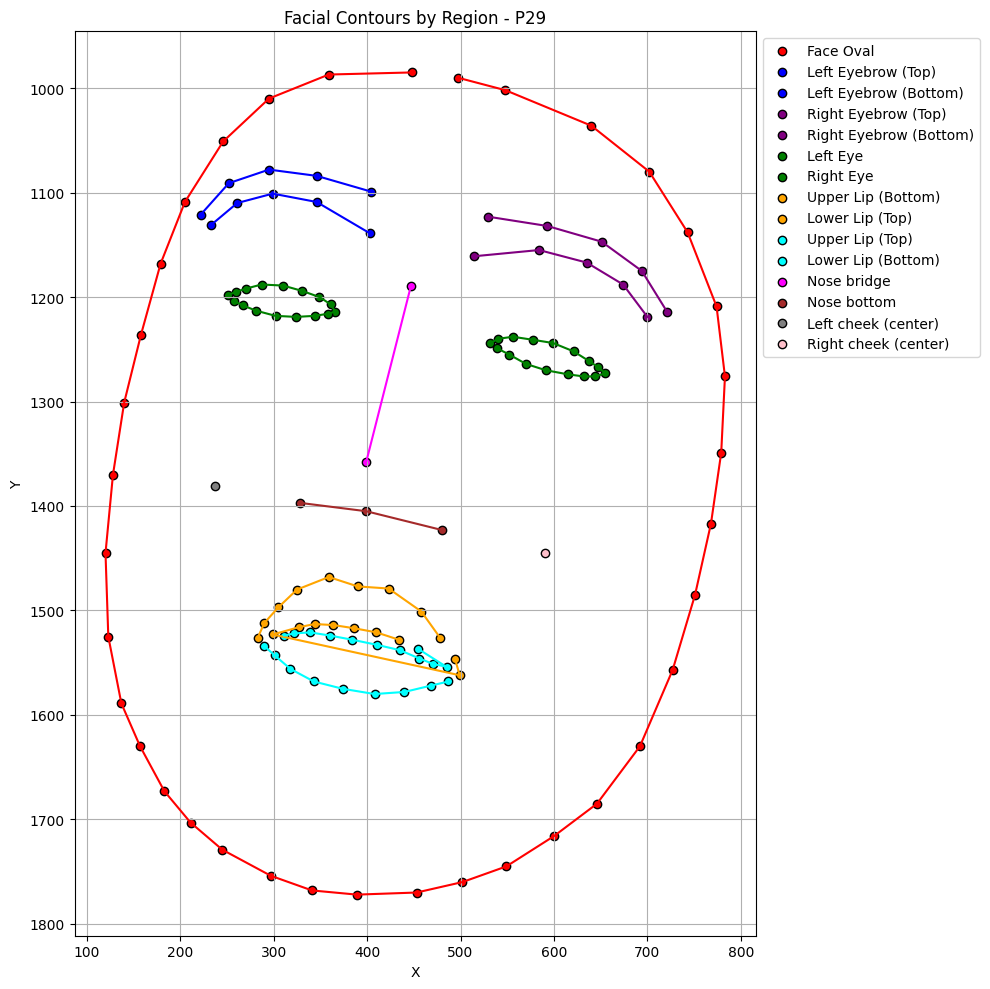

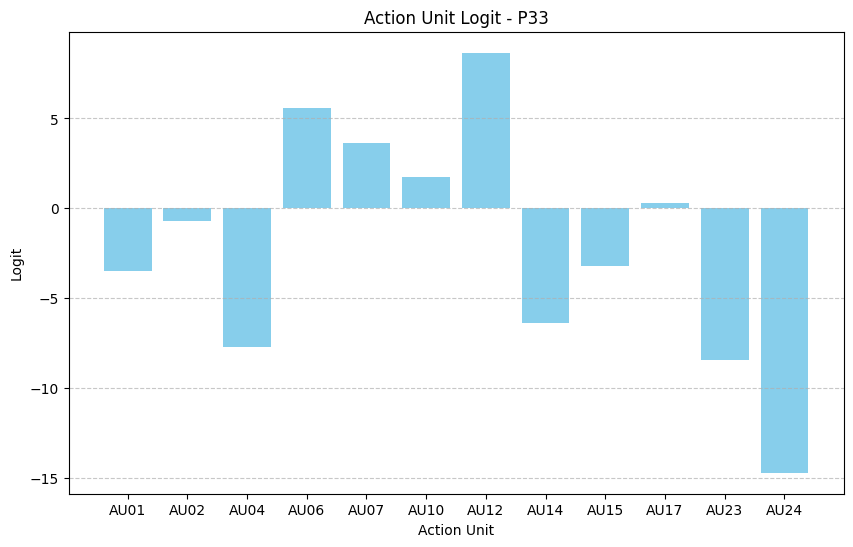

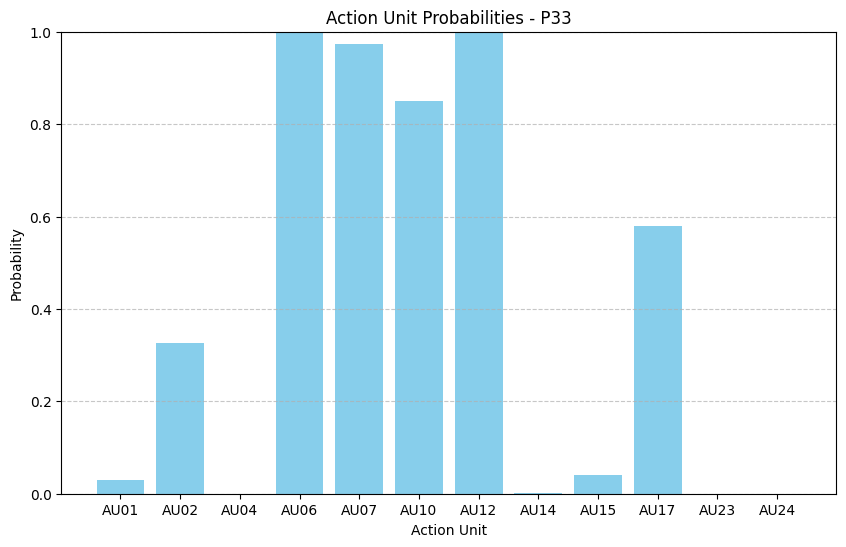

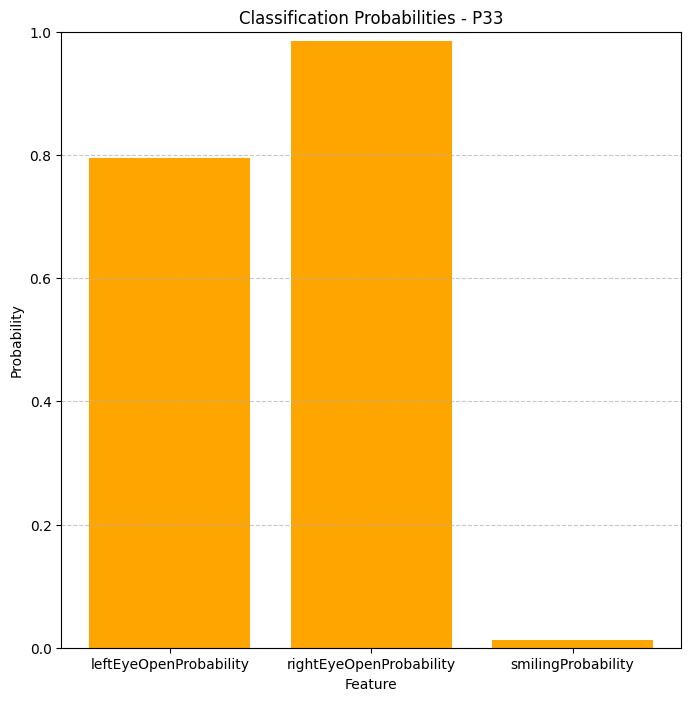

Bounding Box for P33: 30 850 996 1837


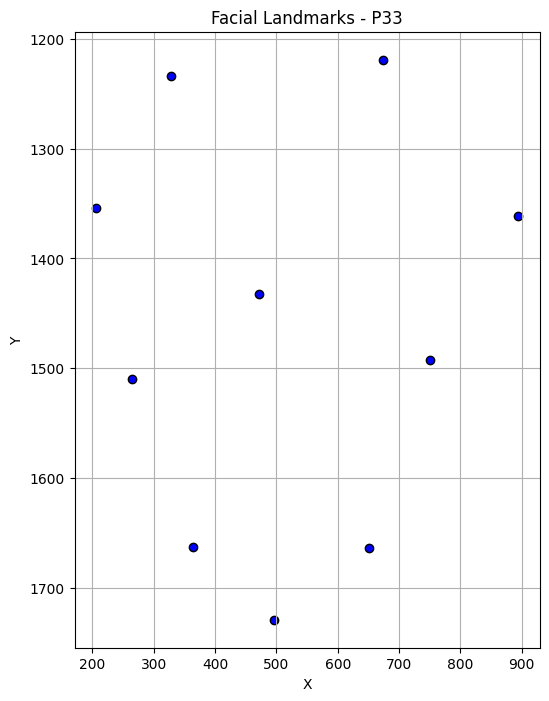

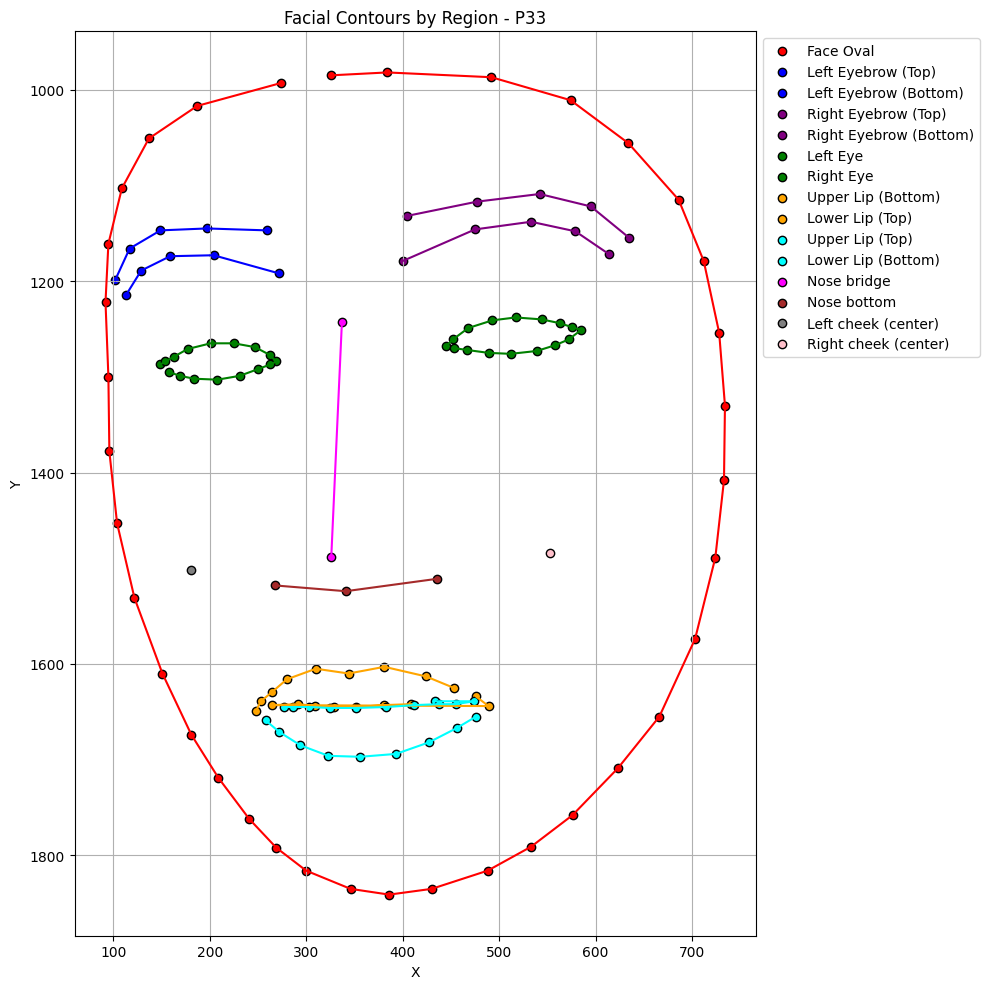

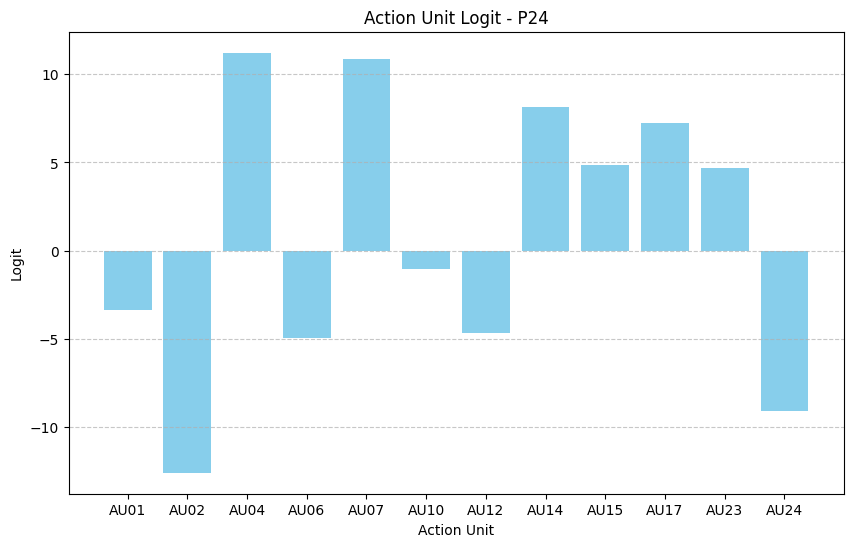

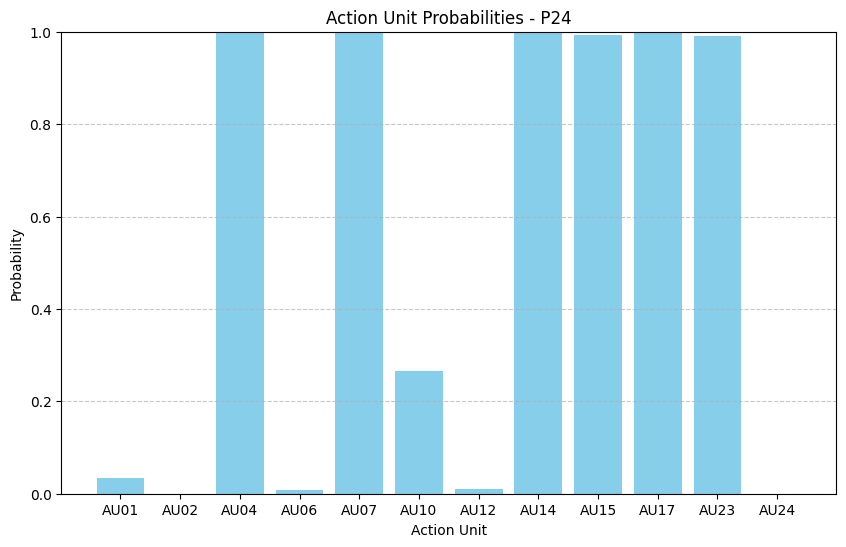

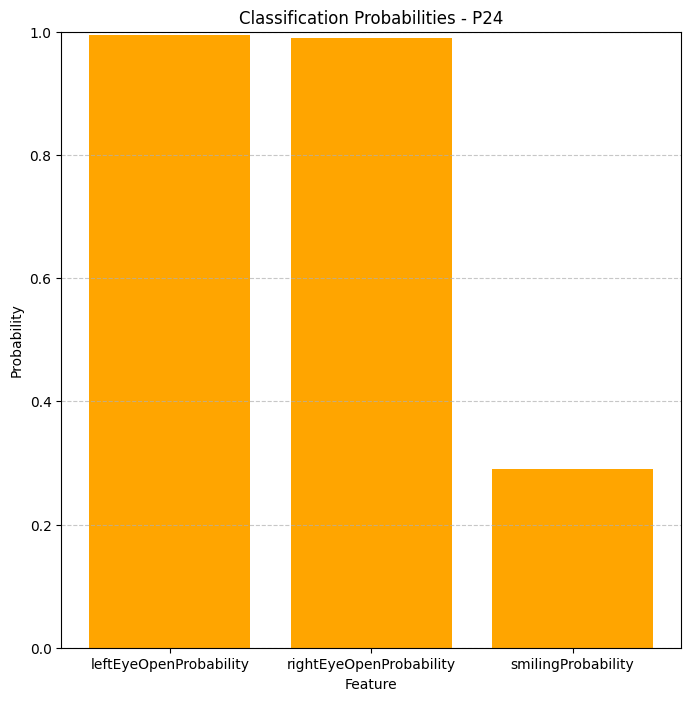

Bounding Box for P24: 155 814 1167 2166


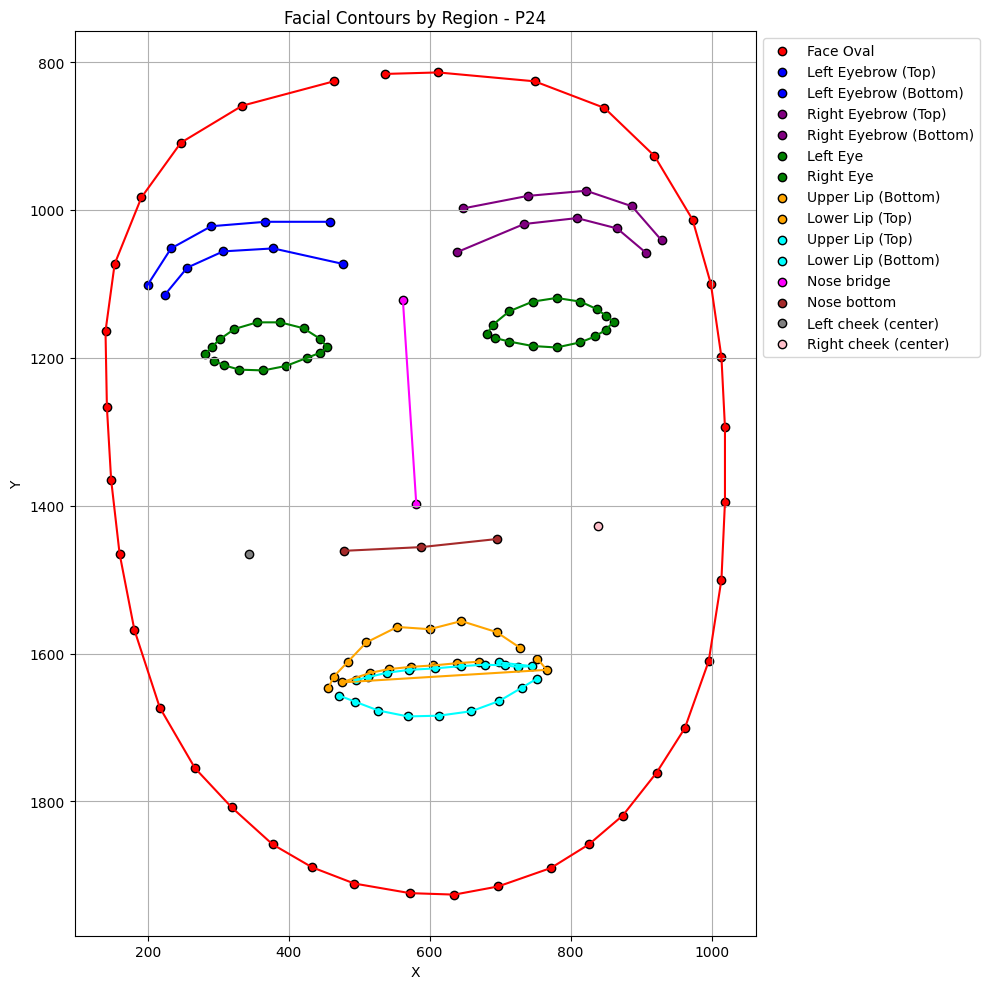

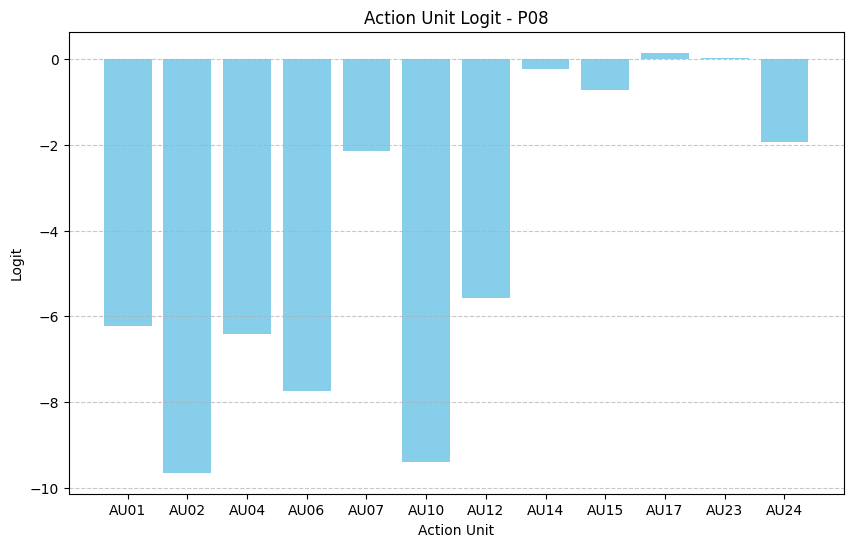

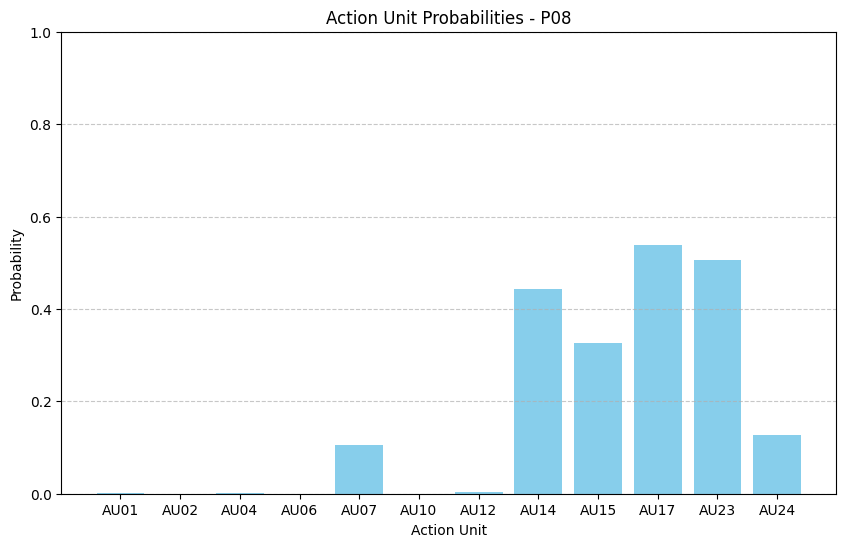

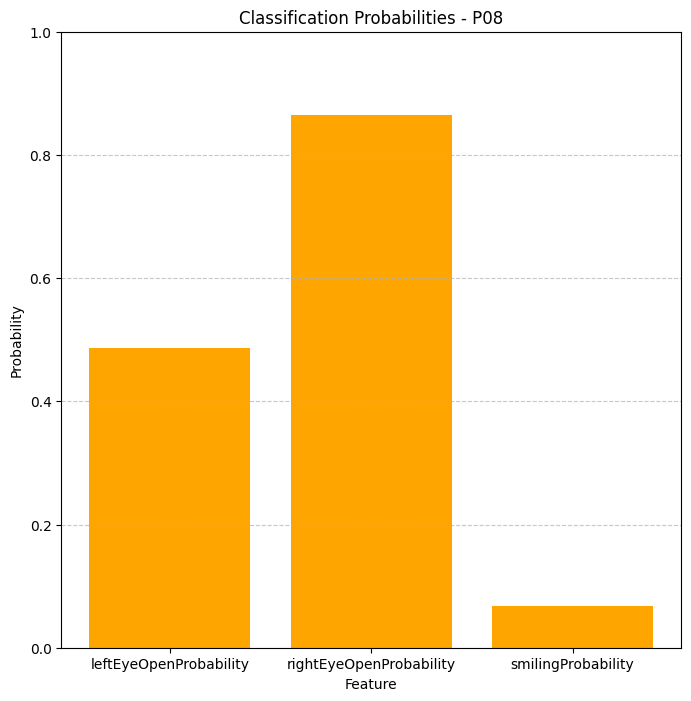

Bounding Box for P08: 285 992 1016 1723


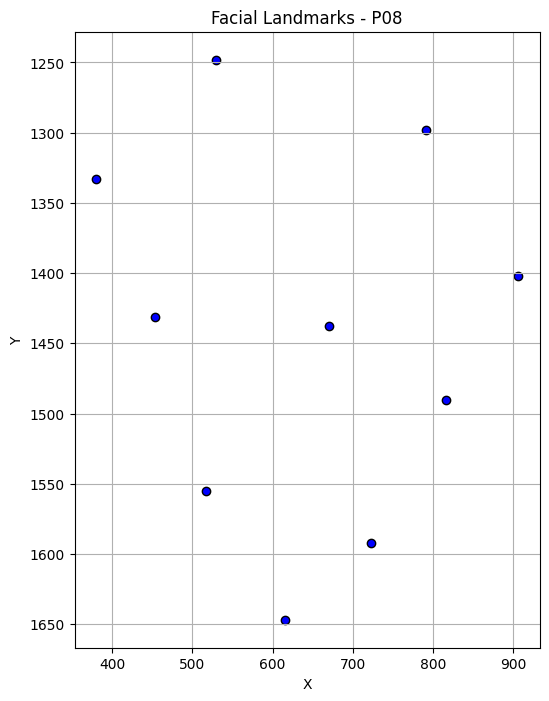

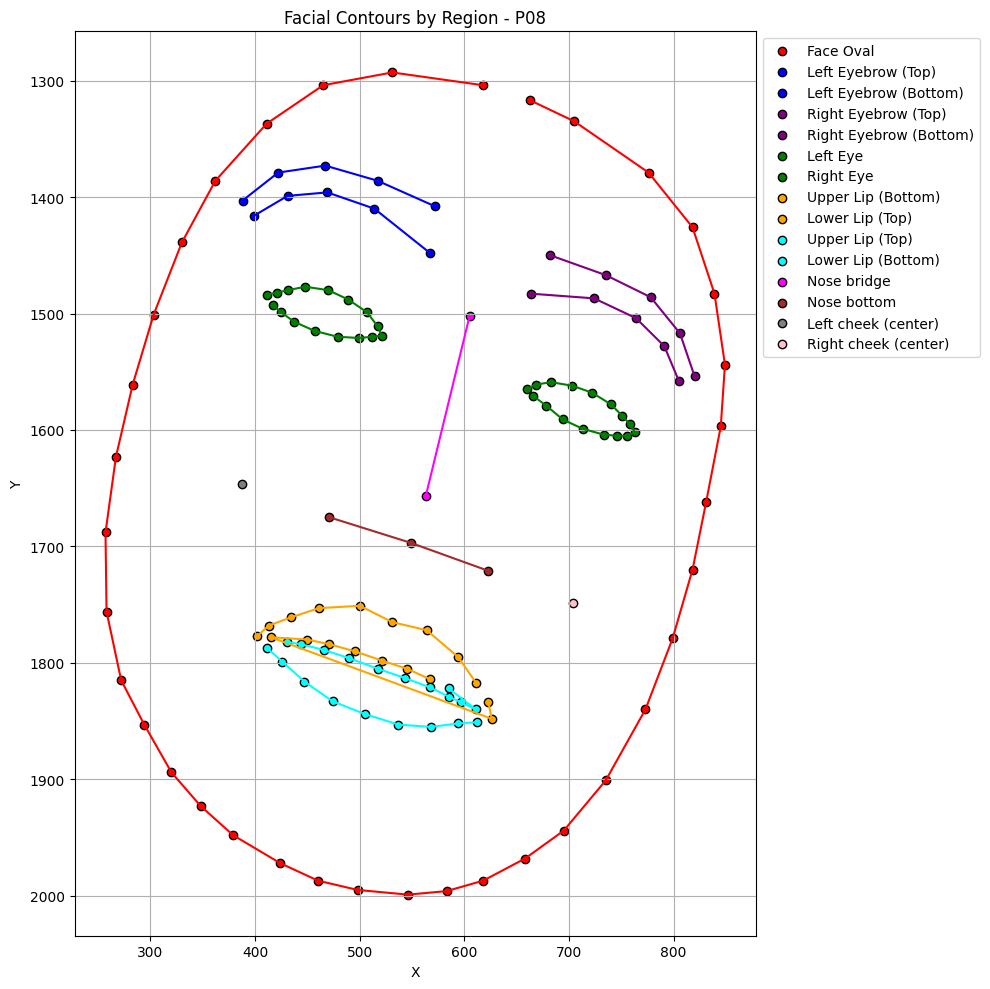

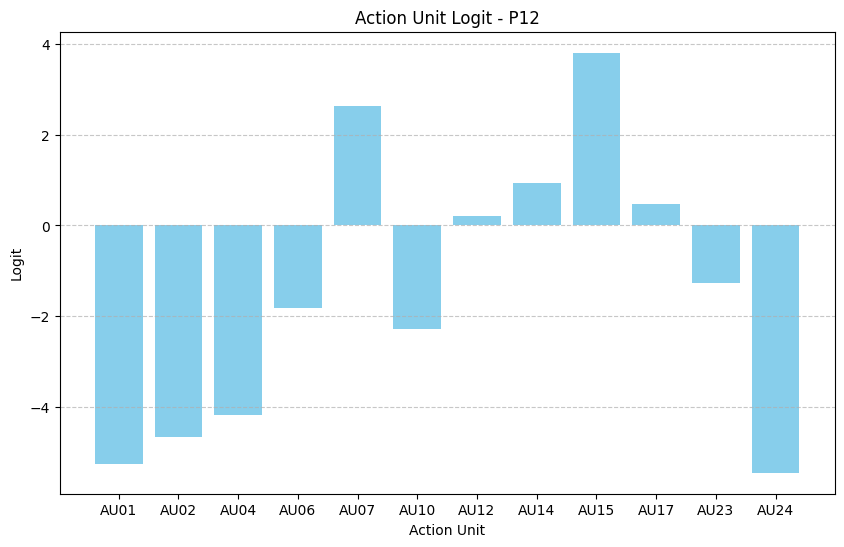

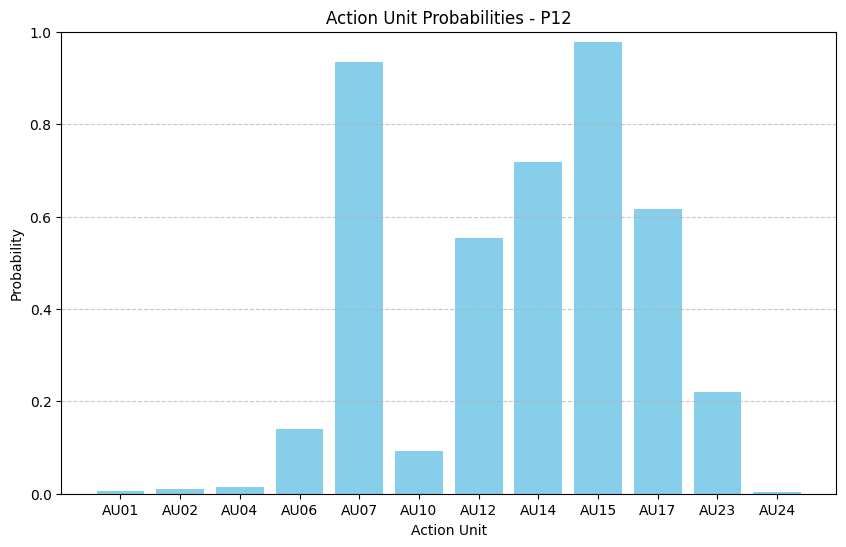

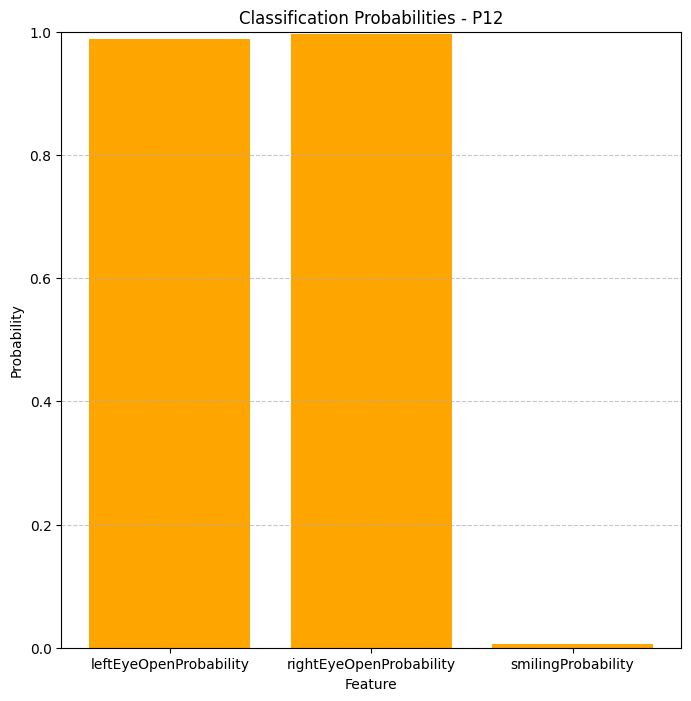

Bounding Box for P12: 231 1123 928 1821


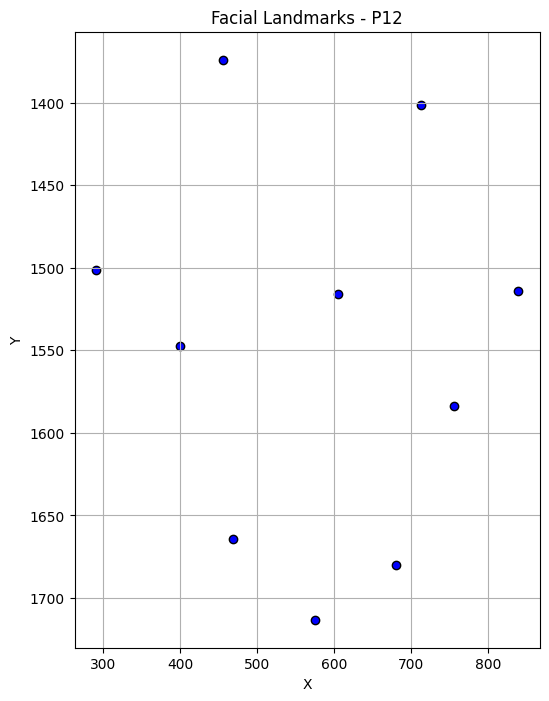

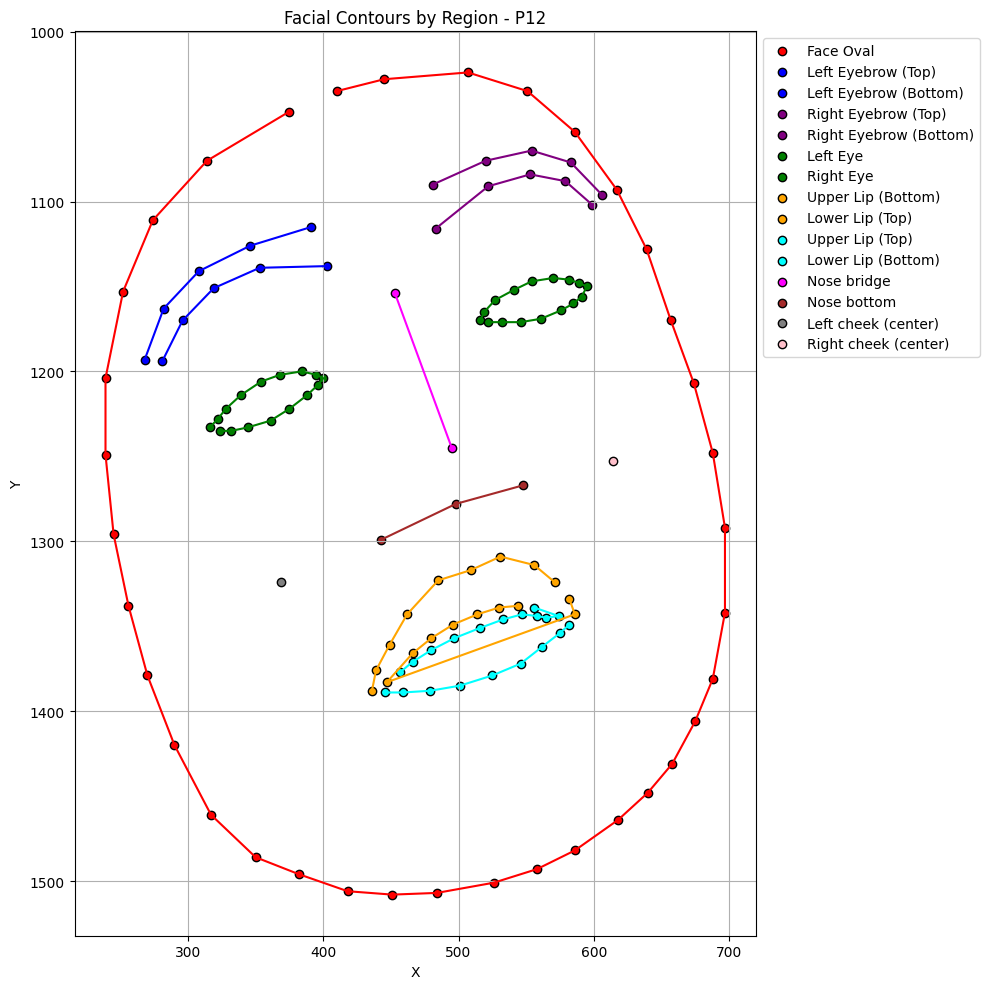

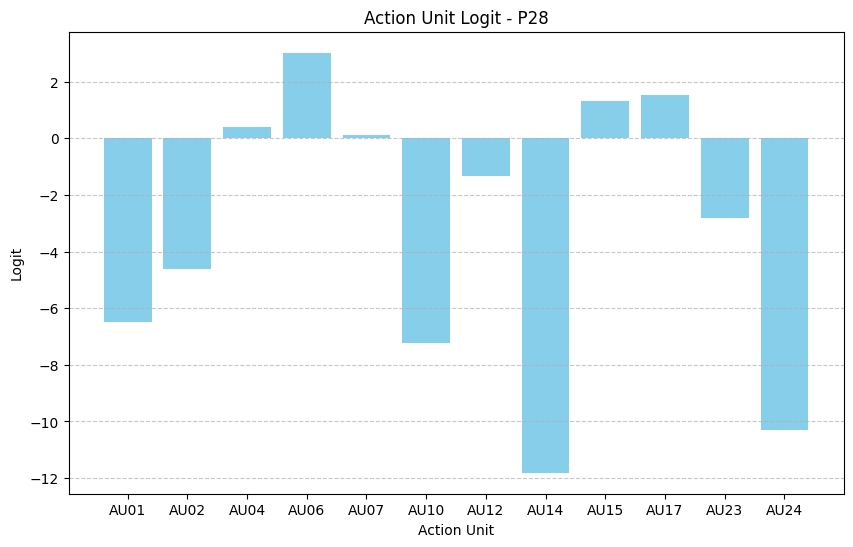

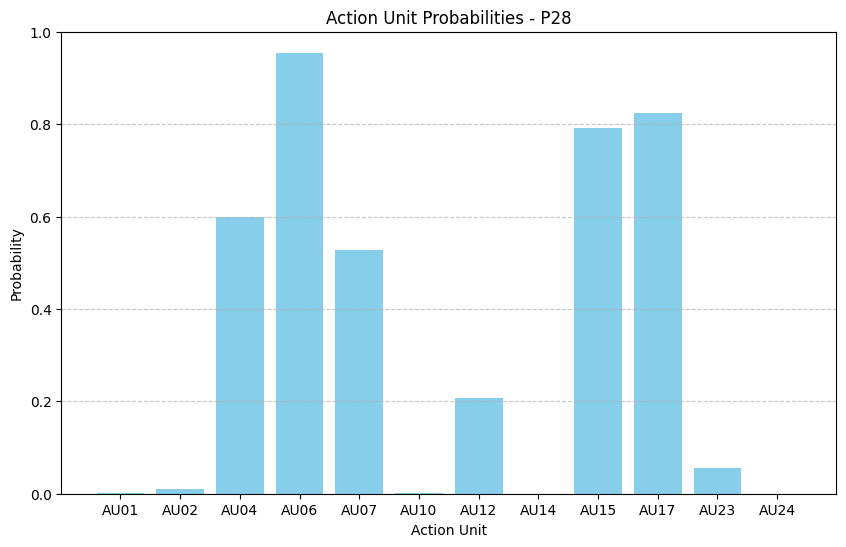

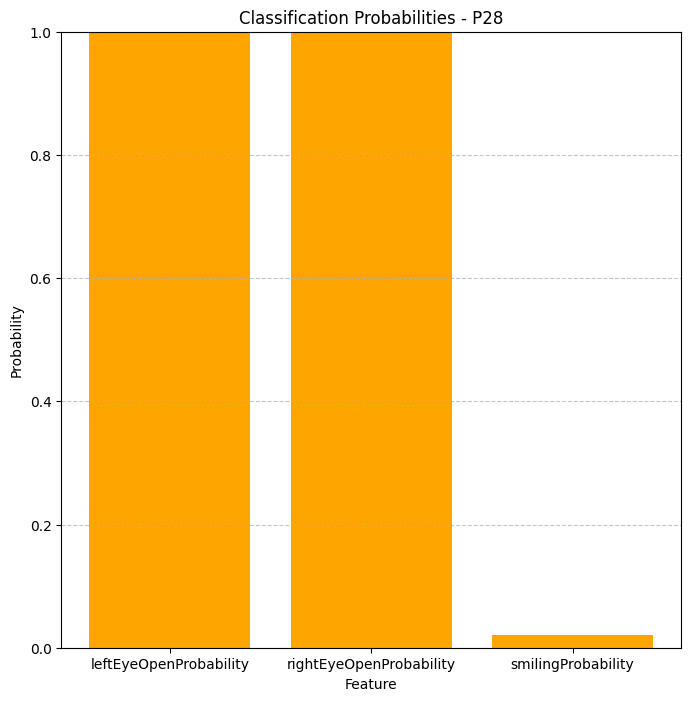

Bounding Box for P28: 167 940 1036 1828


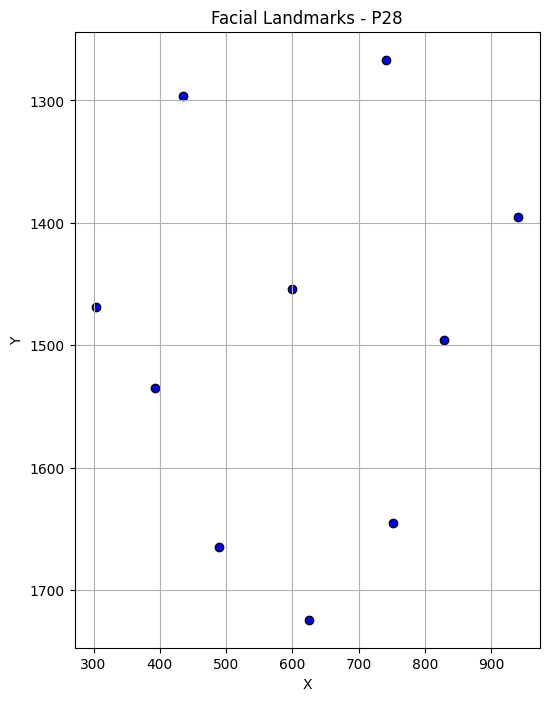

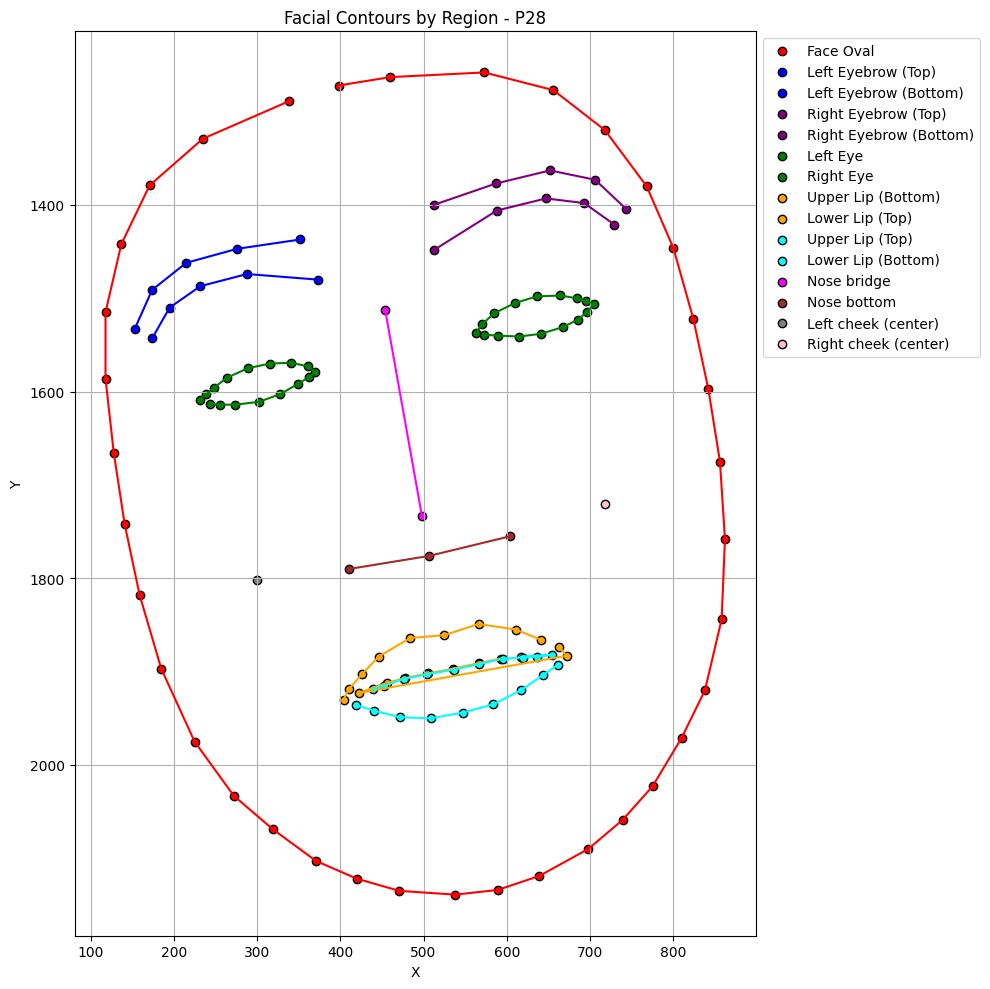

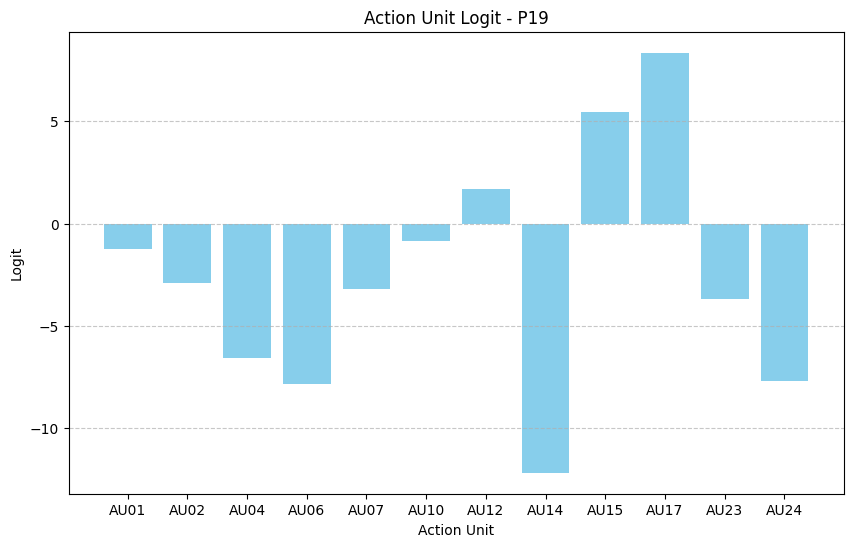

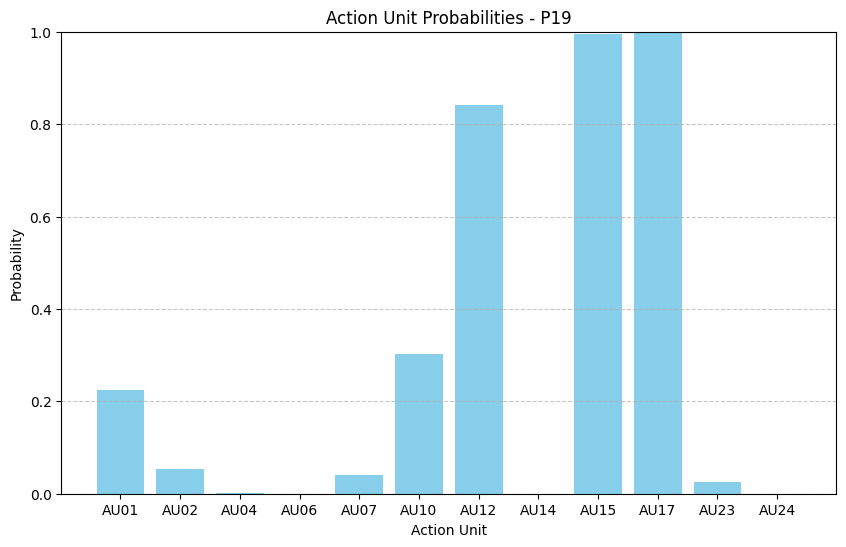

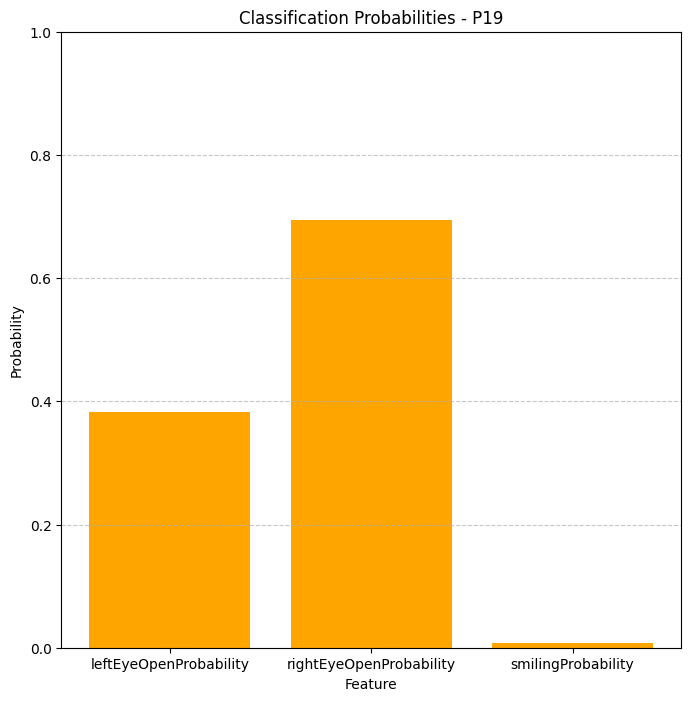

Bounding Box for P19: -70 794 1166 1940


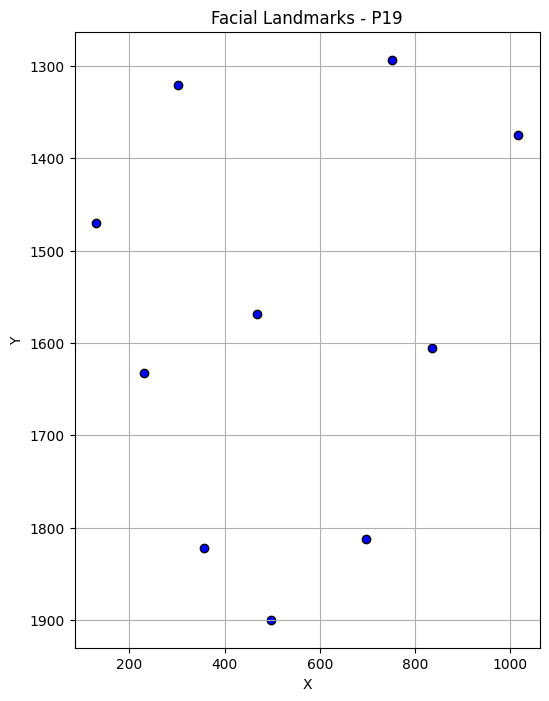

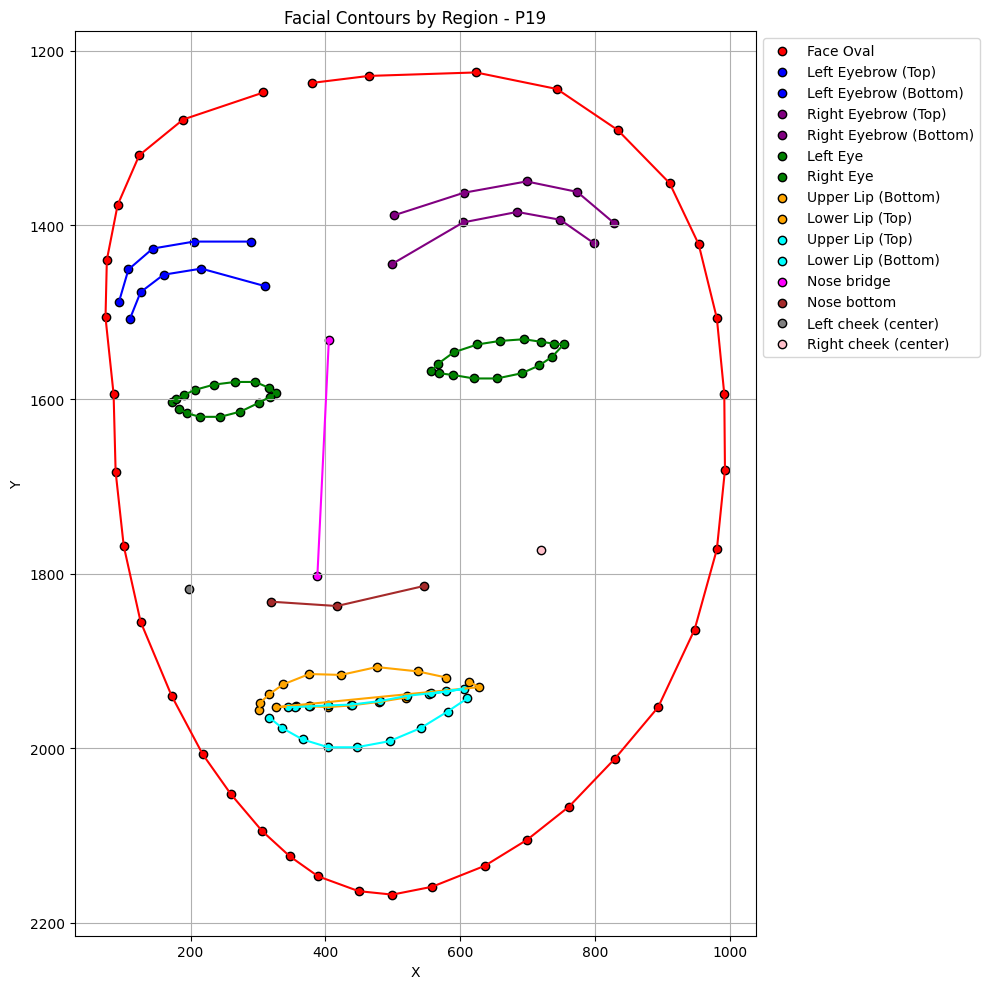

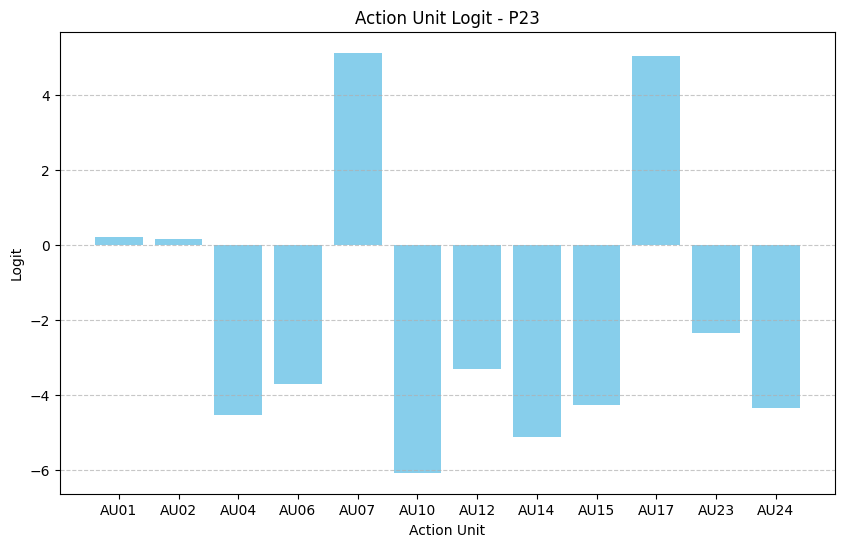

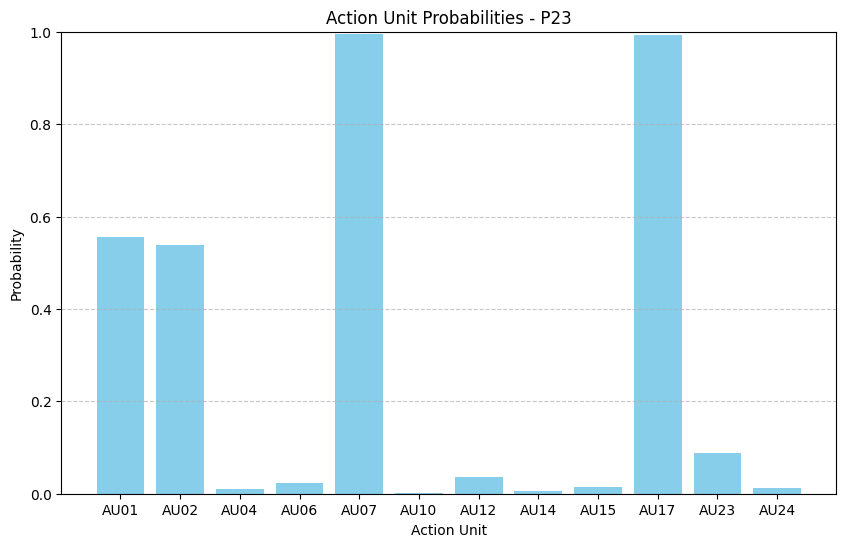

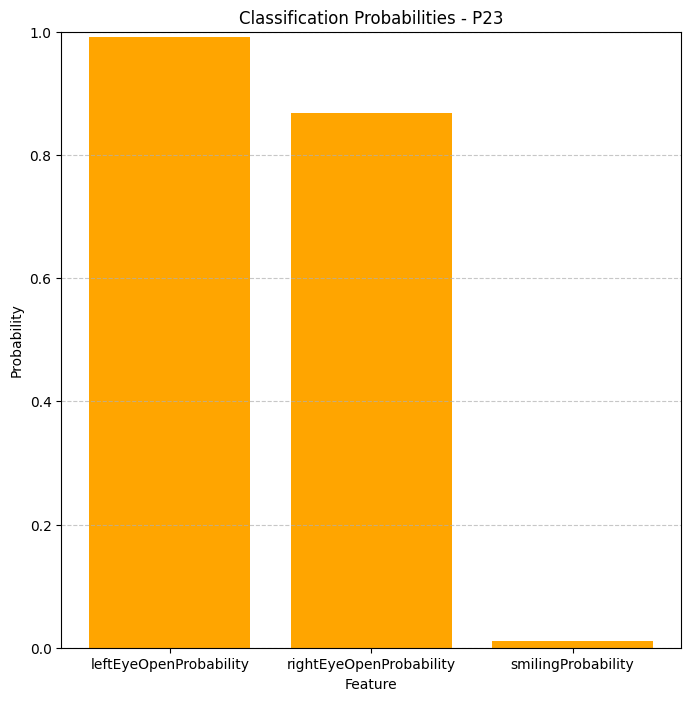

Bounding Box for P23: 180 947 1087 1853


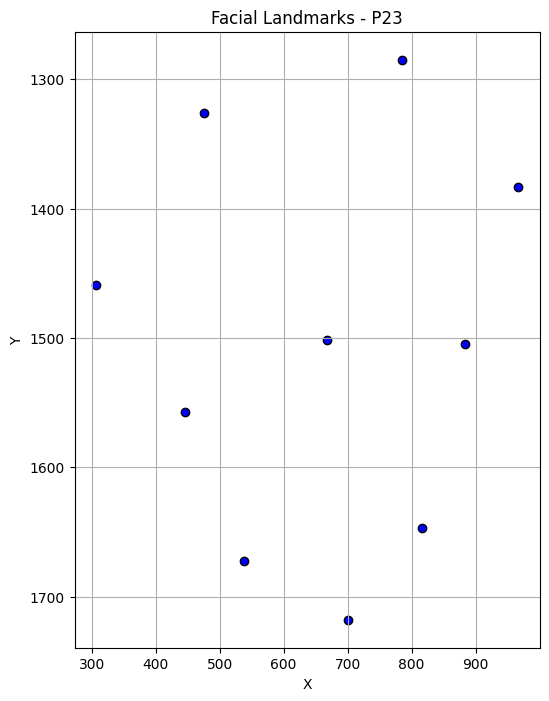

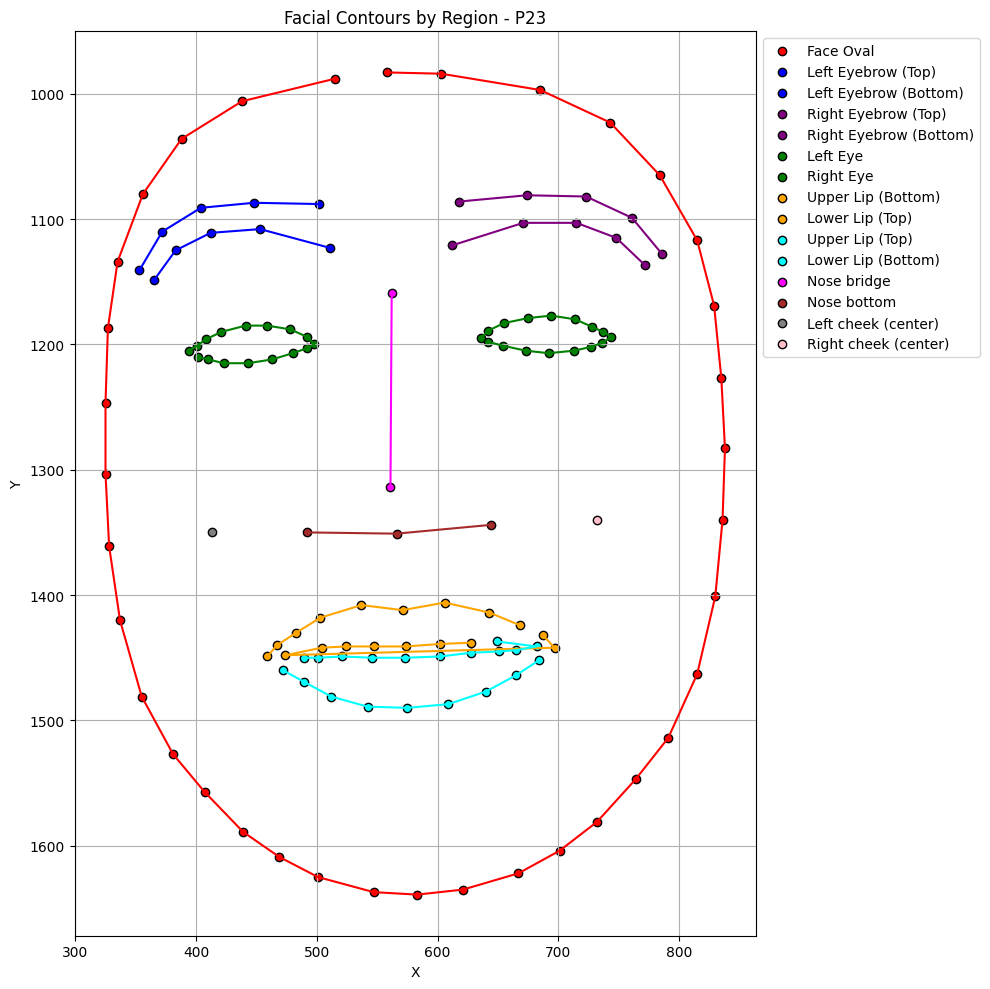

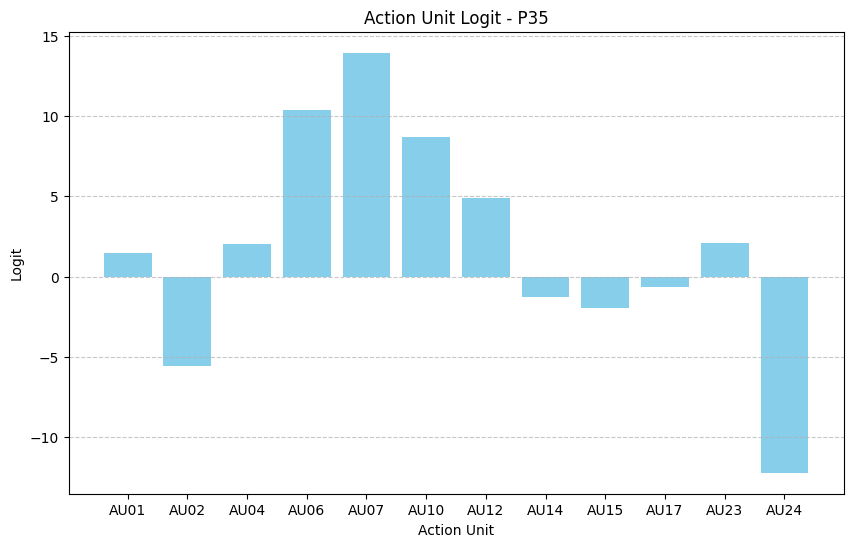

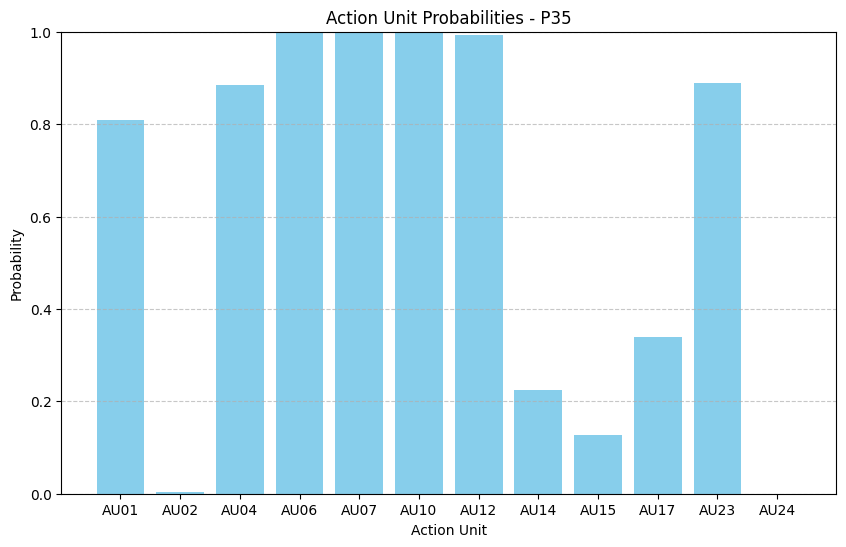

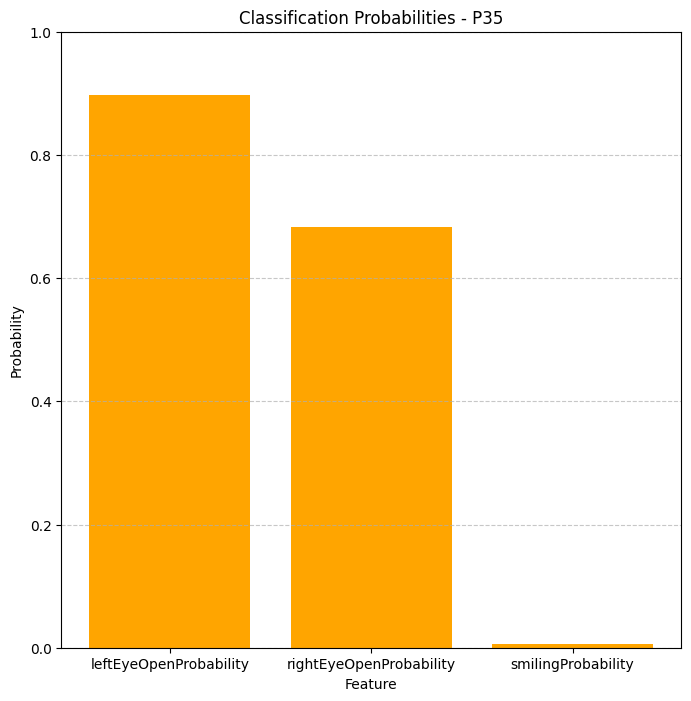

Bounding Box for P35: 237 789 1049 1601


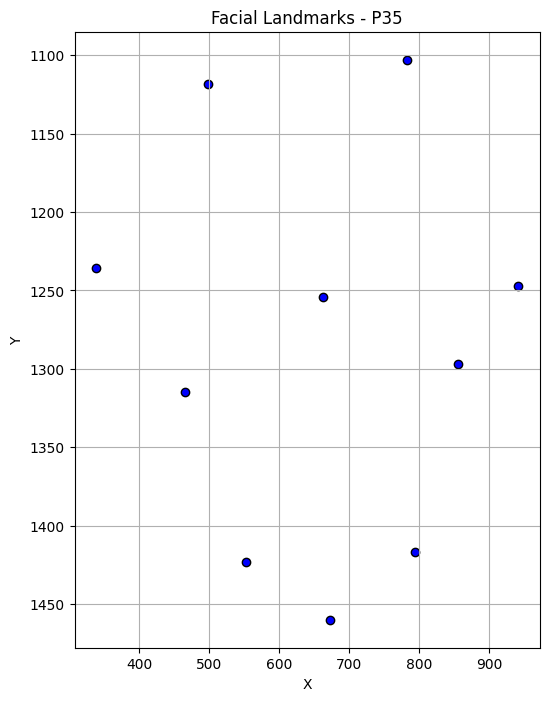

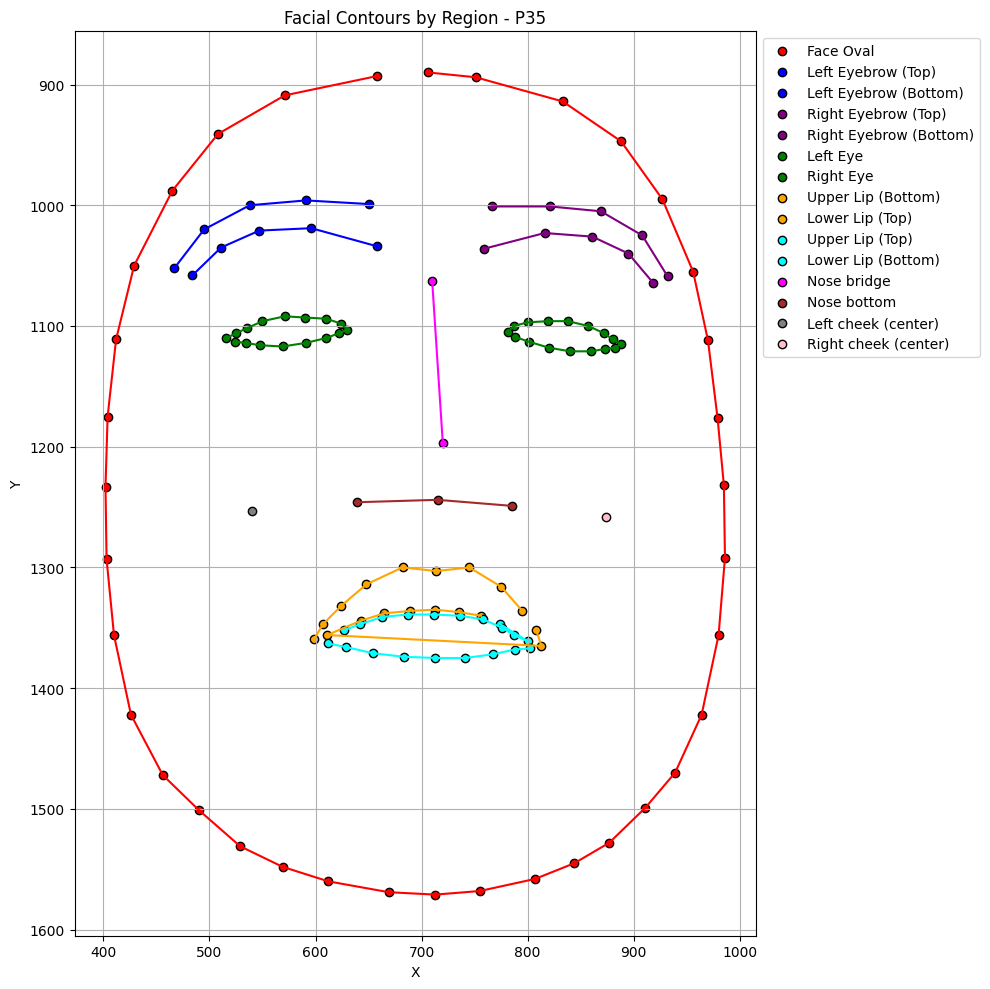

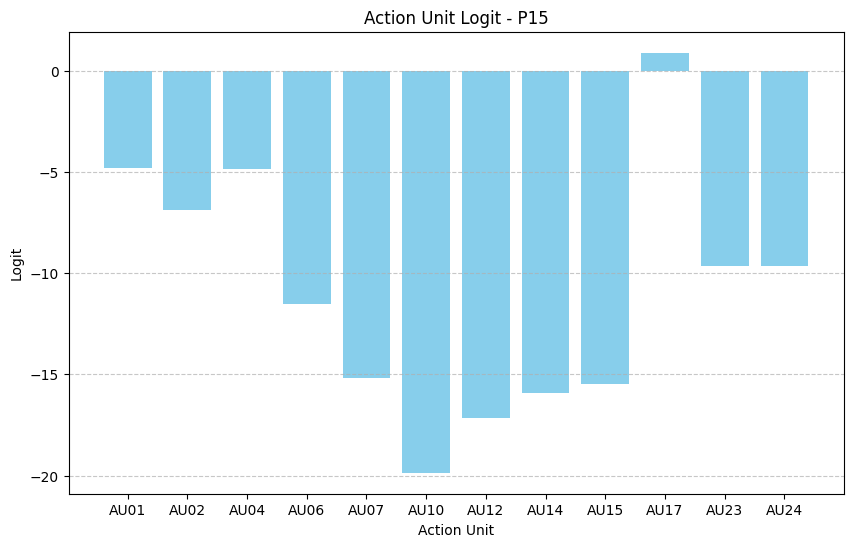

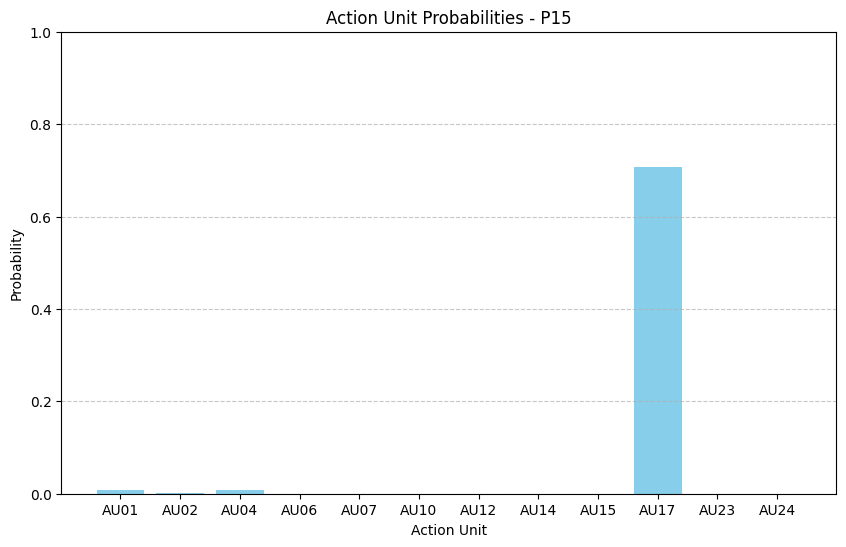

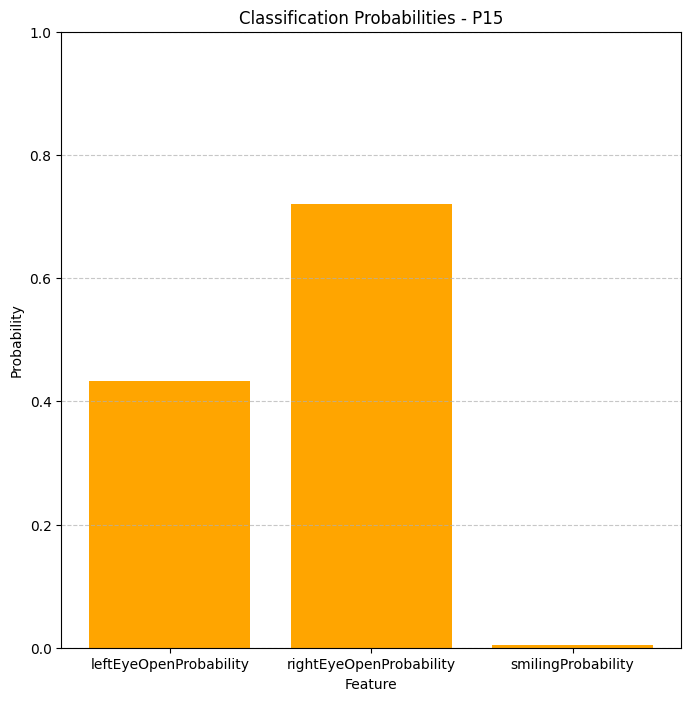

Bounding Box for P15: 122 832 1129 1839


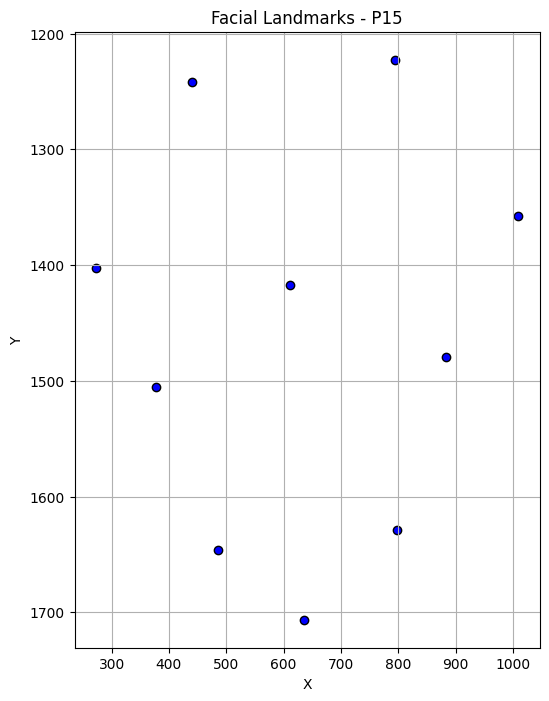

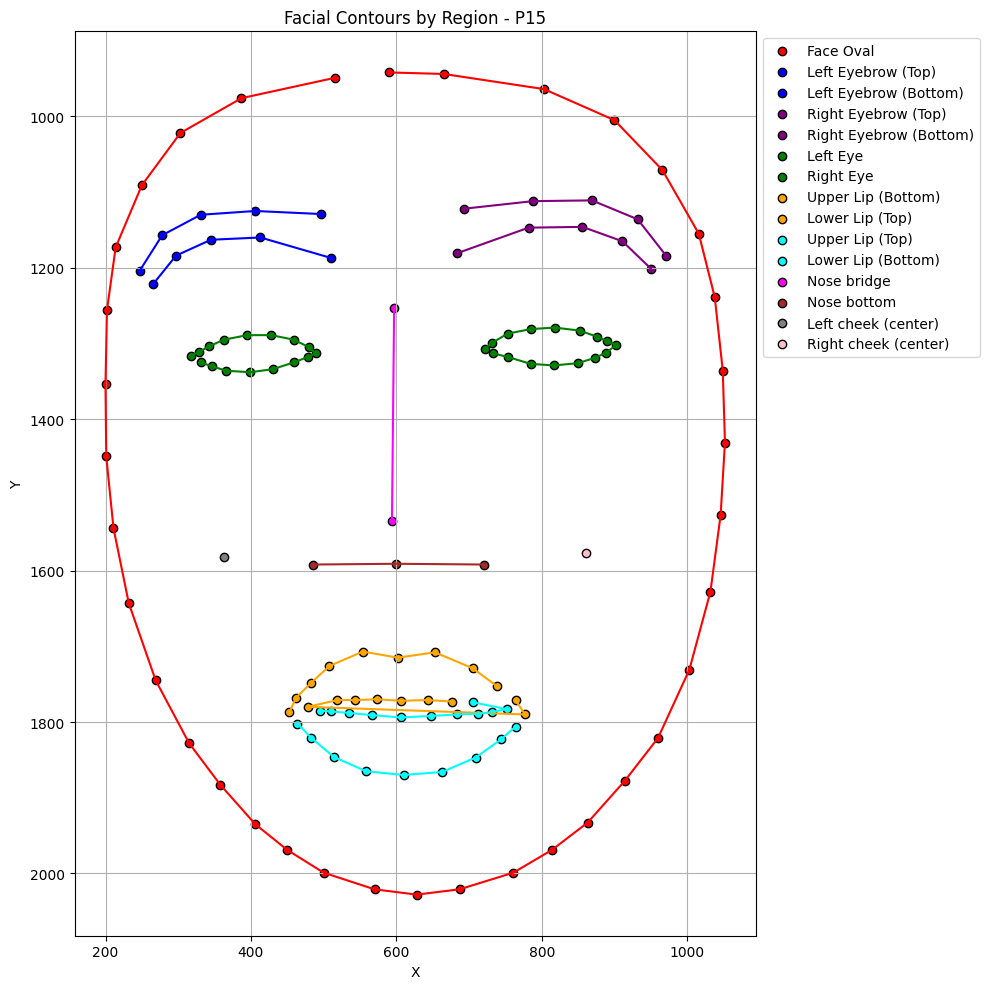

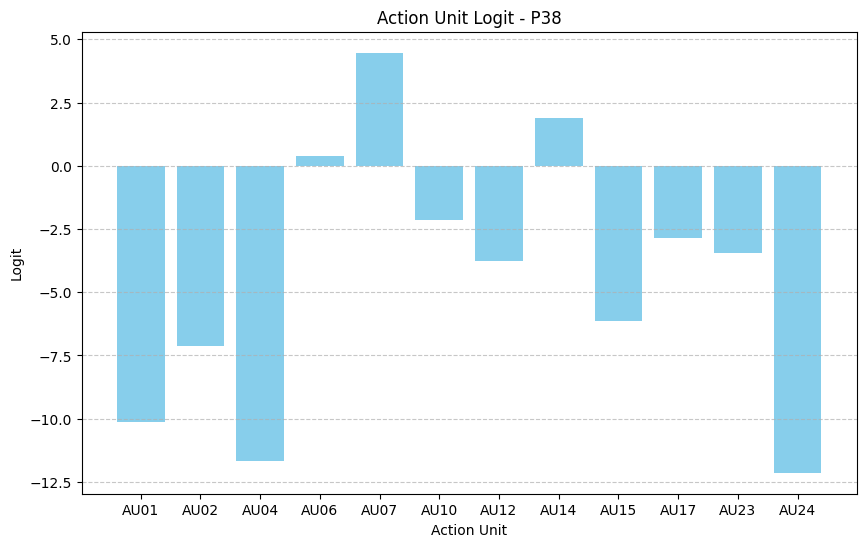

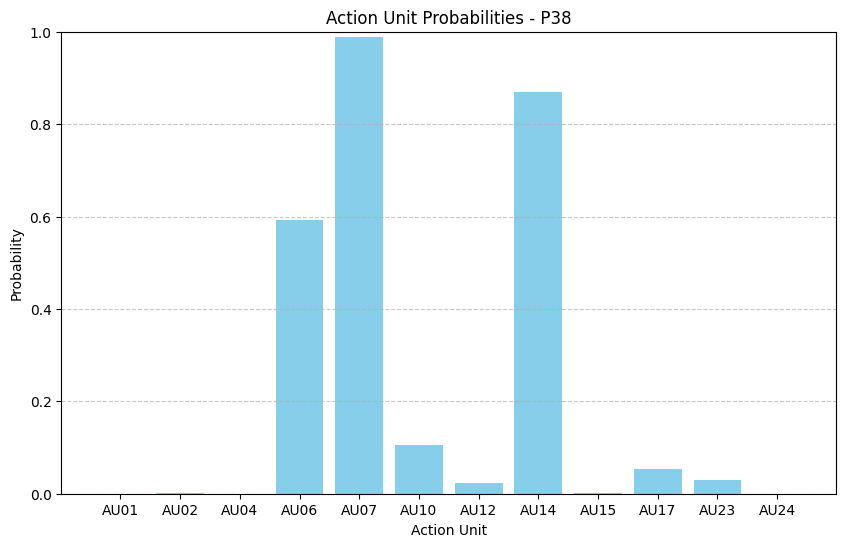

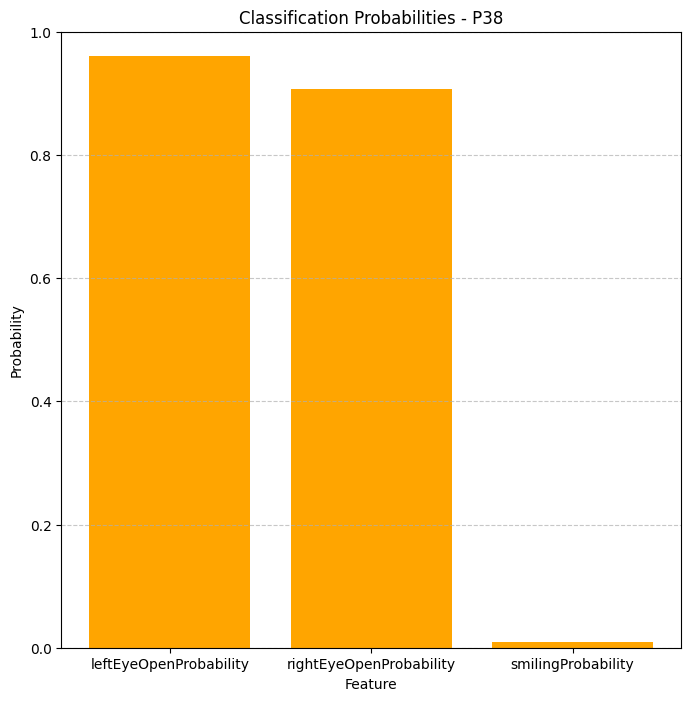

Bounding Box for P38: 355 663 1224 1551


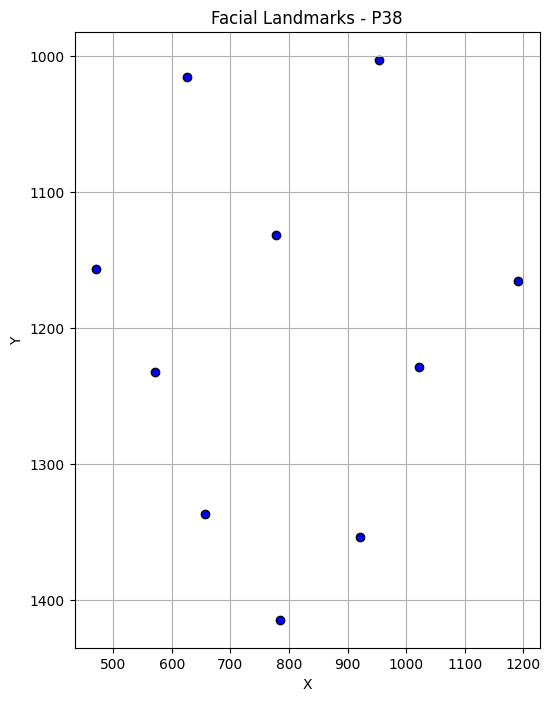

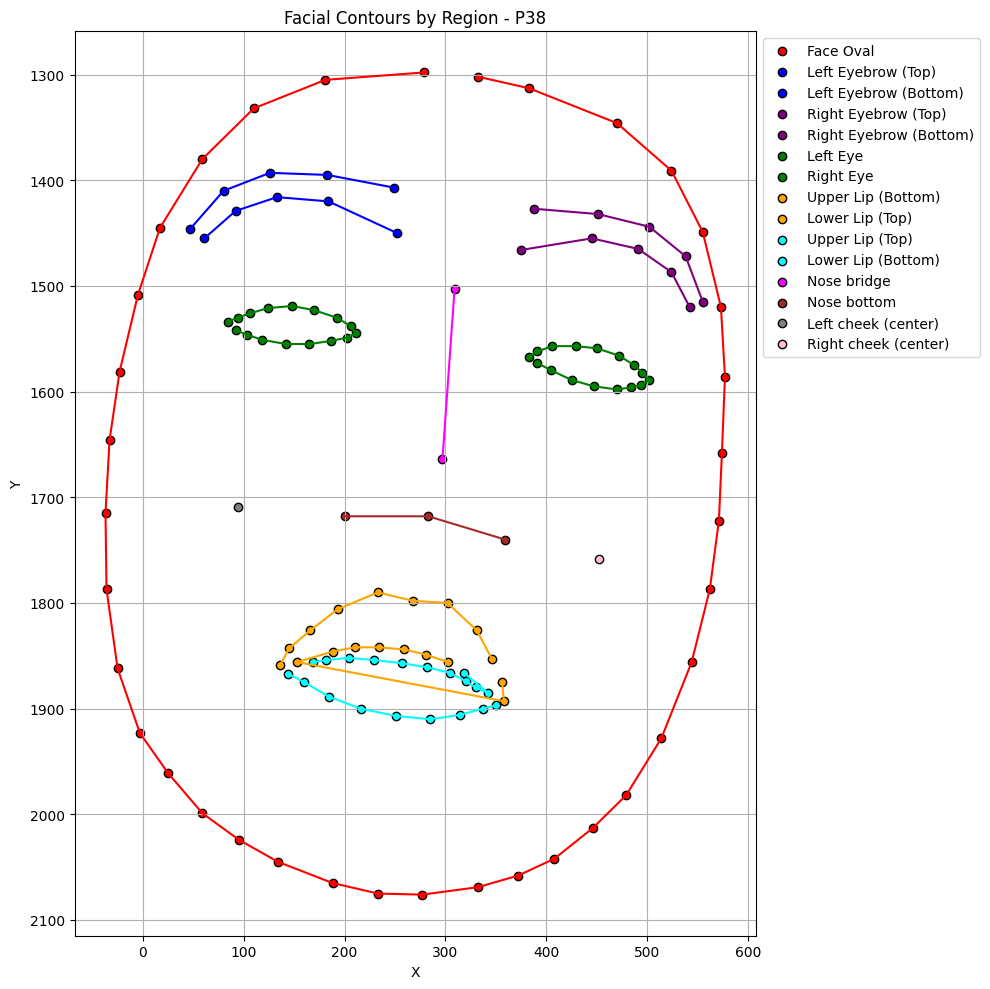

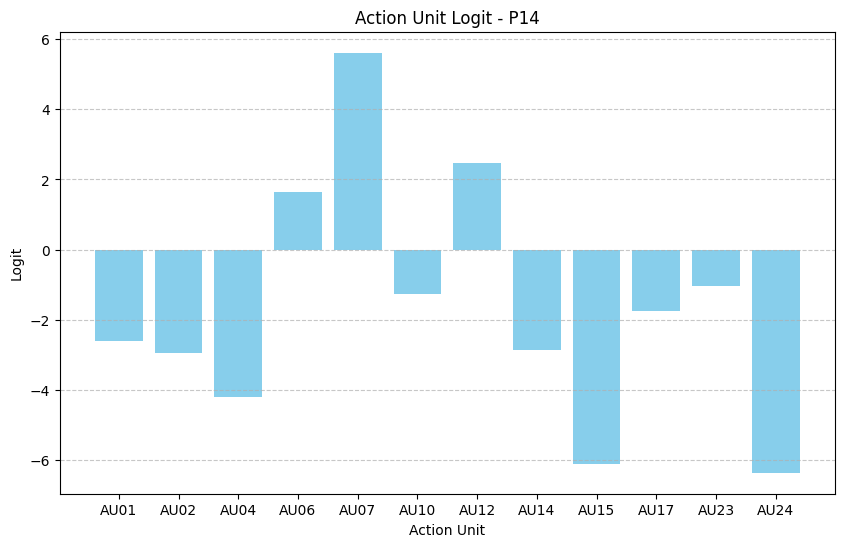

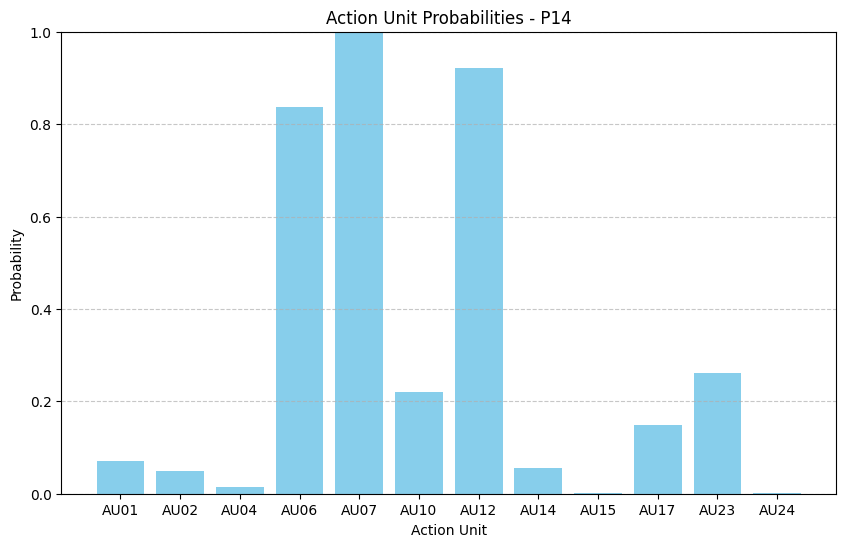

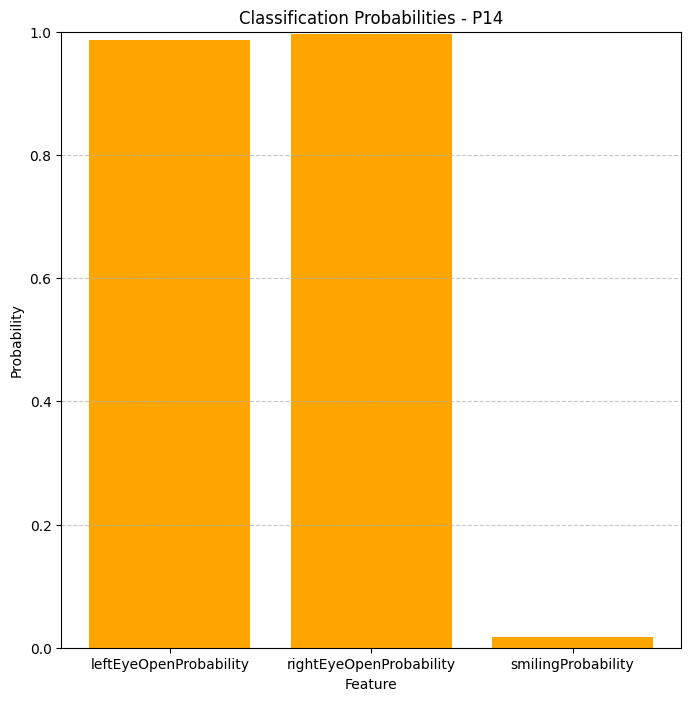

Bounding Box for P14: 35 922 942 1829


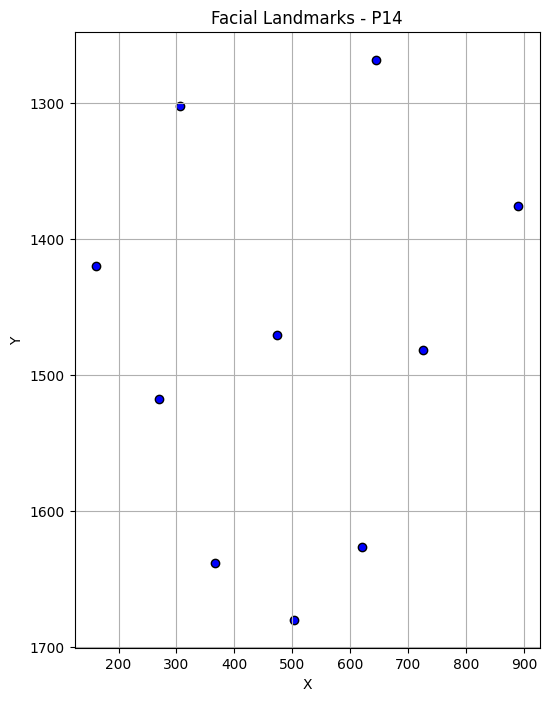

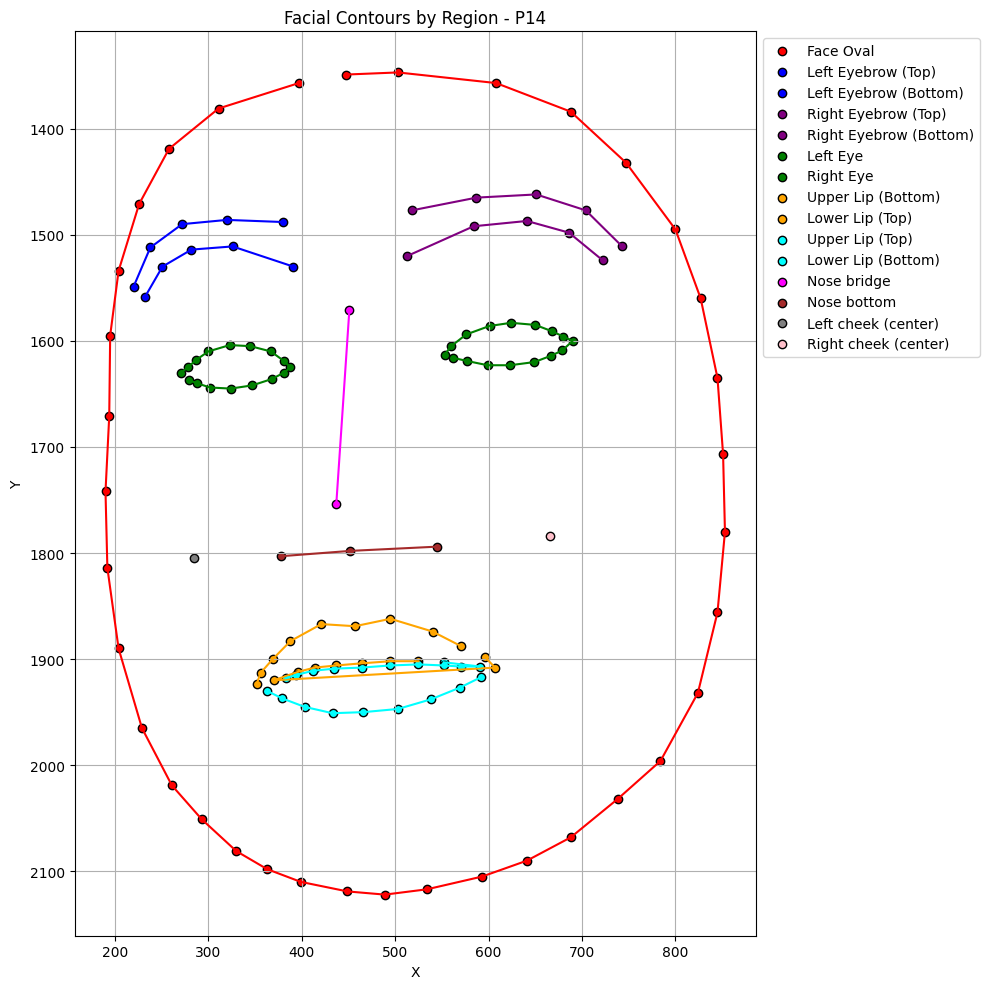

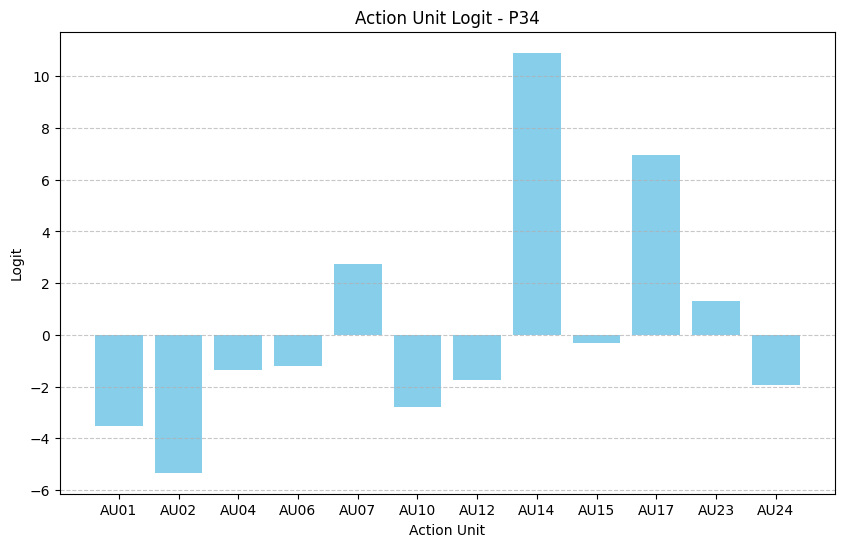

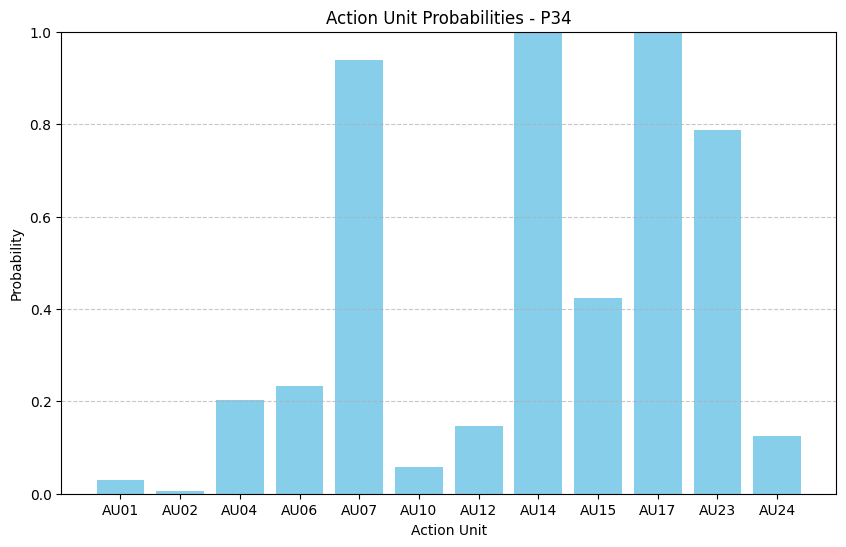

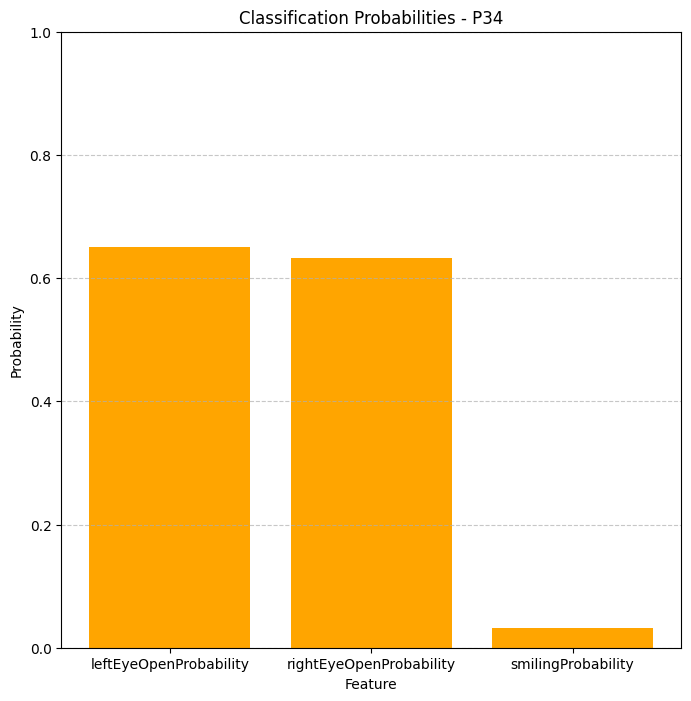

Bounding Box for P34: 363 814 854 1305


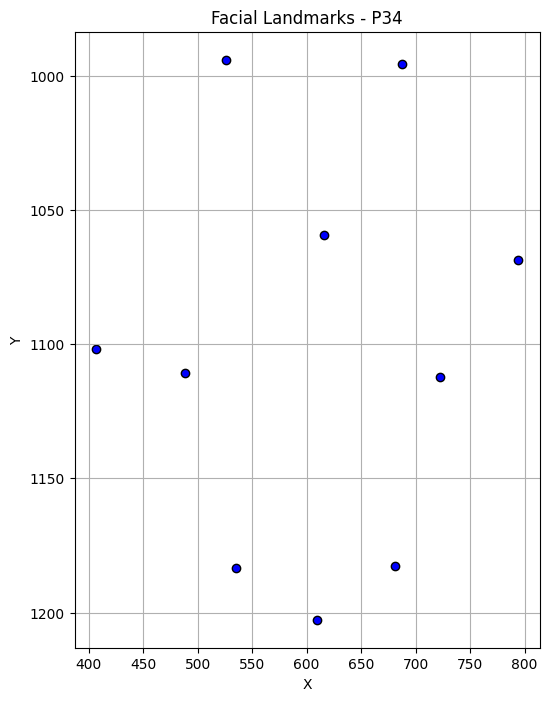

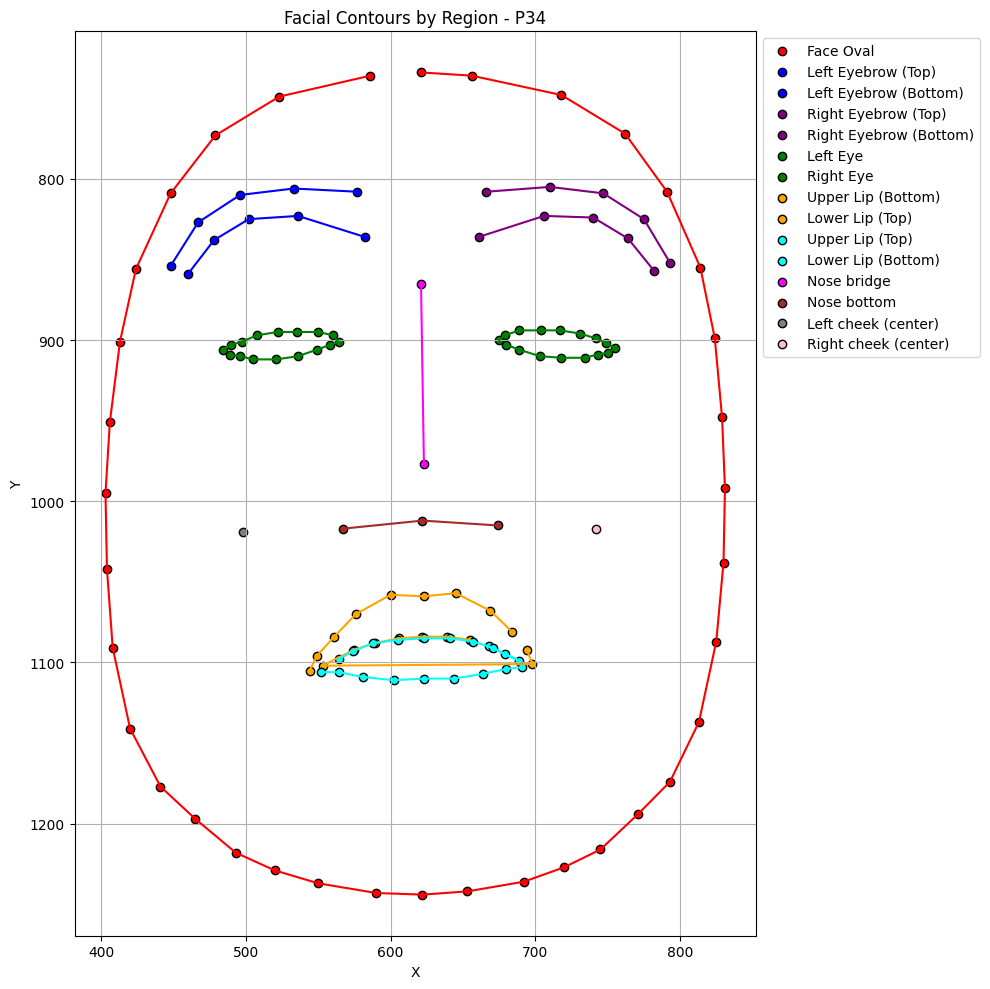

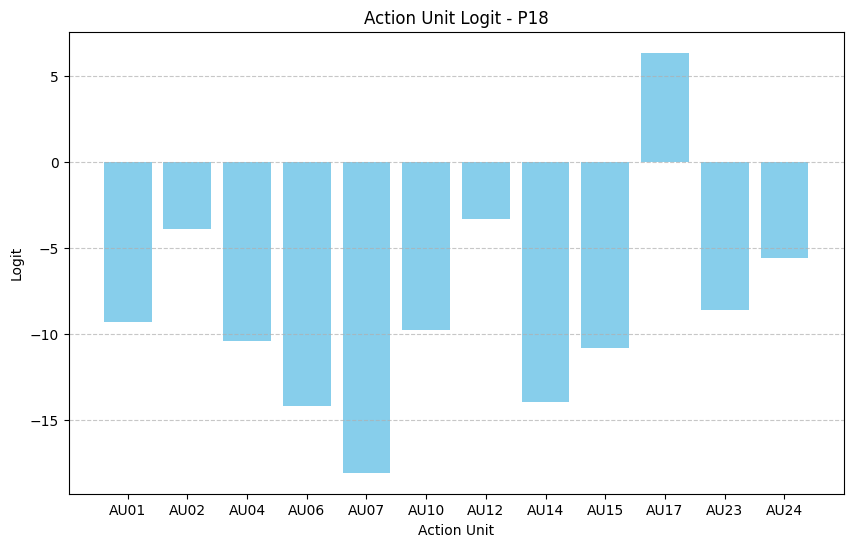

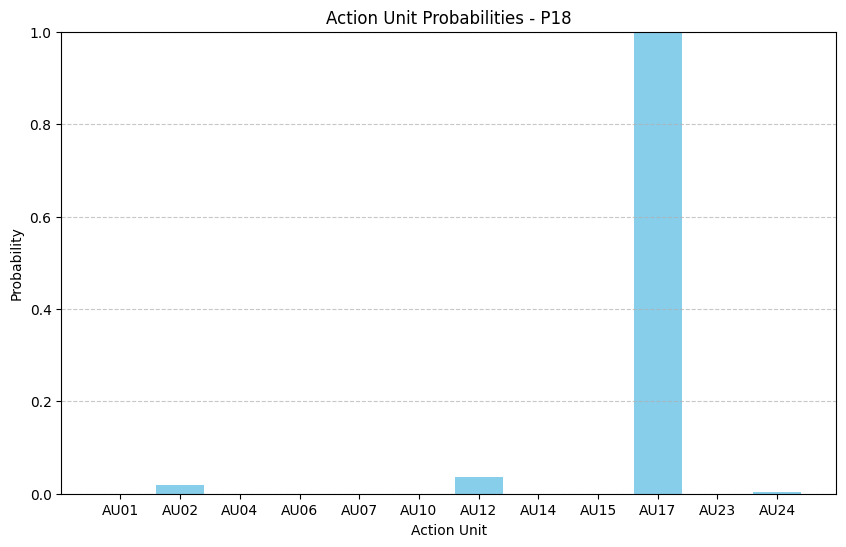

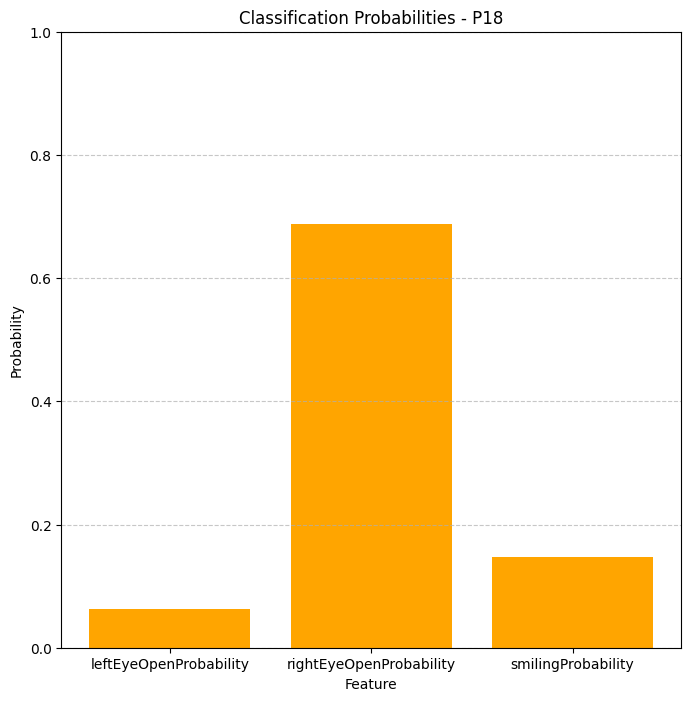

Bounding Box for P18: 267 1096 1136 1984


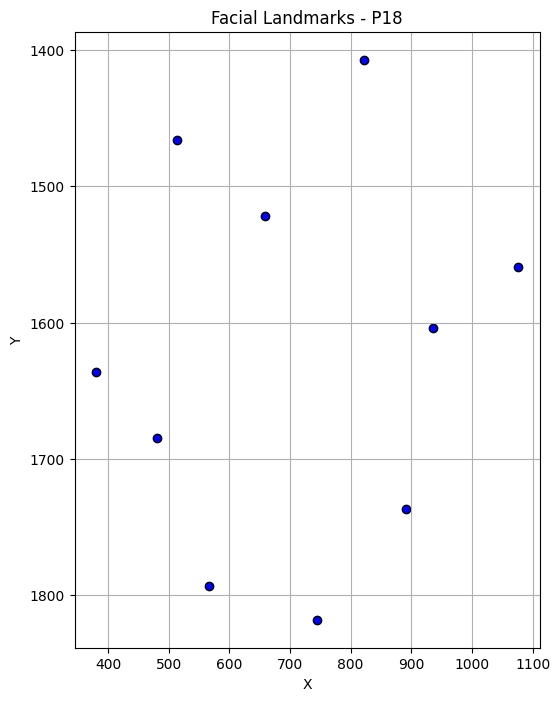

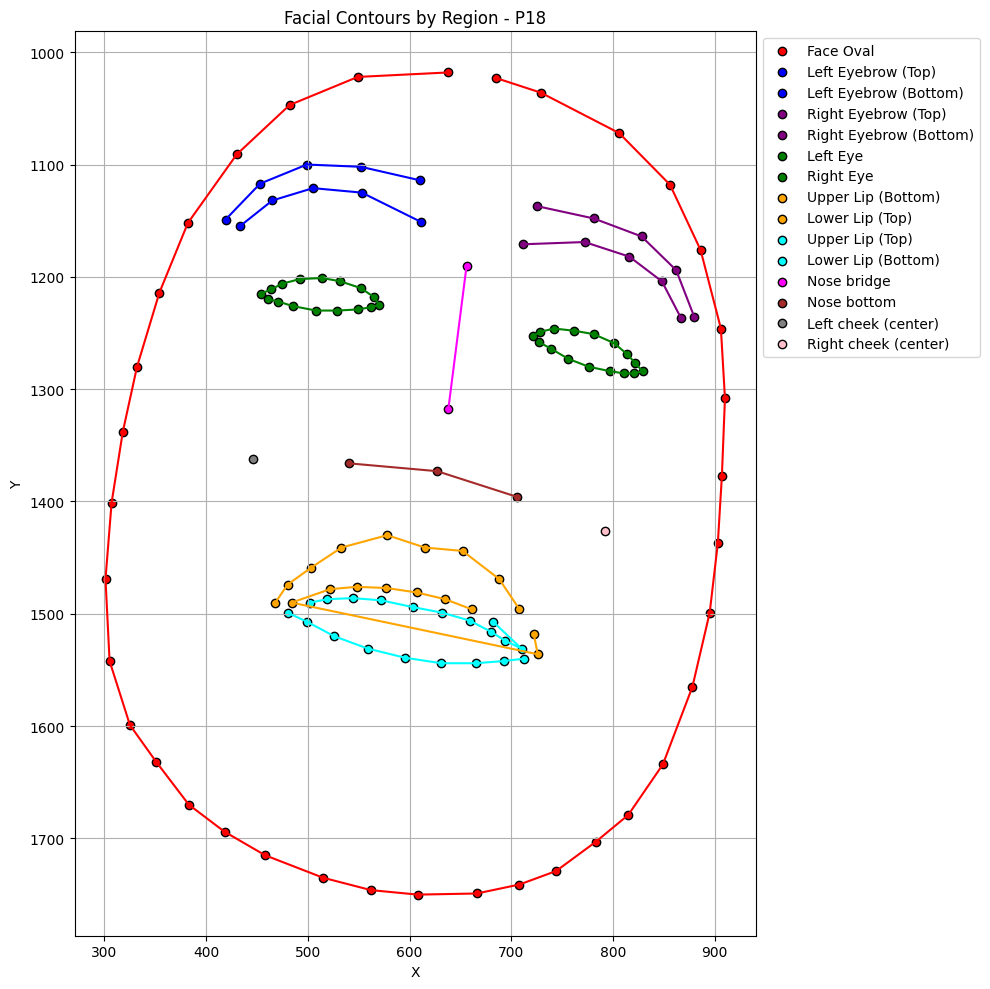

In [5]:
# Step 1: Read and Process JSON Files (Loop through all files)
json_files = [f for f in os.listdir(data_dir) if f.endswith(".json")]
feature_list = []

for json_file in json_files:
    file_path = os.path.join(data_dir, json_file)
    try:
        with open(file_path, "r") as f:
            data = json.load(f)
        participant_id = json_file.split(".")[0]

        # Create a dictionary to store features for this participant
        participant_features = {'pid': participant_id}

        # ----------------------------------
        # Extract Action Units (AU)
        # ----------------------------------
        au_data = {}
        if isinstance(data, dict) and 'au' in data:
            au_data = data['au']
        elif isinstance(data, list):
            for item in data:
                if isinstance(item, dict) and 'au' in item:
                    au_data.update(item['au'])
        if au_data:
            au_names = list(au_data.keys())
            au_values = list(au_data.values())

            # Plot Logits
            plt.figure(figsize=(10, 6))
            plt.bar(au_names, au_values, color='skyblue')
            plt.title(f'Action Unit Logit - {participant_id}')
            plt.xlabel('Action Unit')
            plt.ylabel('Logit')
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            plt.show()

            # Convert logits to probabilities
            au_probabilities = [1 / (1 + np.exp(-v)) for v in au_values]
            plt.figure(figsize=(10, 6))
            plt.bar(au_names, au_probabilities, color='skyblue')
            plt.title(f'Action Unit Probabilities - {participant_id}')
            plt.xlabel('Action Unit')
            plt.ylabel('Probability')
            plt.ylim(0, 1)
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            plt.show()

            # Save AU features
            for au, val in au_data.items():
                participant_features[au] = val

        # ----------------------------------
        # Extract Classification Probabilities
        # ----------------------------------
        classification = {}
        if isinstance(data, dict) and 'classification' in data:
            classification = data['classification']
        elif isinstance(data, list):
            for item in data:
                if isinstance(item, dict) and 'classification' in item:
                    classification.update(item['classification'])
        if classification:
            for key, val in classification.items():
                participant_features[key] = val
            # Plot classification probabilities
            class_labels = list(classification.keys())
            class_values = list(classification.values())
            plt.figure(figsize=(8, 8))
            plt.bar(class_labels, class_values, color='orange')
            plt.title(f'Classification Probabilities - {participant_id}')
            plt.xlabel('Feature')
            plt.ylabel('Probability')
            plt.ylim(0, 1)
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            plt.show()

        # ----------------------------------
        # Extract Bounding Box
        # ----------------------------------
        bbox = None
        if isinstance(data, dict) and 'boundingBox' in data:
            bbox = data['boundingBox']
        elif isinstance(data, list):
            for item in data:
                if isinstance(item, dict) and 'boundingBox' in item:
                    bbox = item['boundingBox']
        if bbox:
            print(f"Bounding Box for {participant_id}: {bbox}")
            # Optionally, store it if you plan to convert it later
            participant_features['boundingBox'] = bbox

        # ----------------------------------
        # Extract Facial Landmarks
        # ----------------------------------
        landmarks = None
        if isinstance(data, dict) and 'landmarks' in data:
            landmarks = data['landmarks']
        elif isinstance(data, list):
            for item in data:
                if isinstance(item, dict) and 'landmarks' in item:
                    landmarks = item['landmarks']
        if landmarks:
            x_coords = [lm['x'] for lm in landmarks if 'x' in lm]
            y_coords = [lm['y'] for lm in landmarks if 'y' in lm]
            plt.figure(figsize=(6, 8))
            plt.scatter(x_coords, y_coords, c='blue', edgecolors='black')
            plt.gca().invert_yaxis()
            plt.title(f'Facial Landmarks - {participant_id}')
            plt.xlabel('X')
            plt.ylabel('Y')
            plt.grid(True)
            plt.show()

            # Save summary statistics of landmarks
            participant_features['landmarks_mean_x'] = np.mean(x_coords)
            participant_features['landmarks_mean_y'] = np.mean(y_coords)
            participant_features['landmarks_std_x'] = np.std(x_coords)
            participant_features['landmarks_std_y'] = np.std(y_coords)

        # ----------------------------------
        # Extracting and visualizing Contours
        # ----------------------------------
        contours = {}

        if isinstance(data, dict) and 'contours' in data:
            contours = data['contours']
        elif isinstance(data, list):
            for item in data:
                if isinstance(item, dict) and 'contours' in item:
                    if isinstance(item['contours'], list):
                        for point in item['contours']:
                            if isinstance(point, dict) and 'x' in point and 'y' in point:
                                contours.setdefault('x', []).append(point['x'])
                                contours.setdefault('y', []).append(point['y'])

        if contours:
            x_contour = contours.get('x', [])
            y_contour = contours.get('y', [])

            # Define facial parts with indices and colors
            face_parts = [
                ((0, 35), 'Face Oval', 'red'),
                ((36, 40), 'Left Eyebrow (Top)', 'blue'),
                ((41, 45), 'Left Eyebrow (Bottom)', 'blue'),
                ((46, 50), 'Right Eyebrow (Top)', 'purple'),
                ((51, 55), 'Right Eyebrow (Bottom)', 'purple'),
                ((56, 71), 'Left Eye', 'green'),
                ((72, 87), 'Right Eye', 'green'),
                ((88, 96), 'Upper Lip (Bottom)', 'orange'),
                ((97, 105), 'Lower Lip (Top)', 'orange'),
                ((106, 116), 'Upper Lip (Top)', 'cyan'),
                ((117, 125), 'Lower Lip (Bottom)', 'cyan'),
                ((126,127), 'Nose bridge', 'magenta'),
                ((128,130), 'Nose bottom', 'brown'),
                ((131,131), 'Left cheek (center)', 'gray'),
                ((132,132), 'Right cheek (center)', 'pink')
            ]

            plt.figure(figsize=(10, 10))

            for (start, end), label, color in face_parts:
                if start < len(x_contour) and end < len(y_contour):  # Ensure valid indices
                    x_part = x_contour[start:end+1]
                    y_part = y_contour[start:end+1]
                    plt.scatter(x_part, y_part, label=label, c=color, edgecolors='black')
                    if end > start:
                        plt.plot(x_part, y_part, c=color)

            plt.gca().invert_yaxis()
            plt.title(f'Facial Contours by Region - {participant_id}')
            plt.xlabel('X')
            plt.ylabel('Y')
            plt.grid(True)
            plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
            plt.tight_layout()
            plt.show()
            # Append participant_features to the feature_list
        feature_list.append(participant_features)

    except Exception as e:
        print(f"Error processing {json_file}: {e}")


In [6]:
# -------------------------------
# Convert the feature list into a DataFrame
features_df = pd.DataFrame(feature_list)
print("Extracted Participant Features (from JSON):")
print(features_df.head())


Extracted Participant Features (from JSON):
   pid       AU01       AU02      AU04      AU06      AU07       AU10  \
0  P21  -7.041190  -2.959018 -9.417655 -3.624587  2.099845  -6.182172   
1  P17  -0.831271   0.059641 -4.629683 -1.403470  0.237463  -4.279788   
2  P16 -10.096493 -12.373511 -6.223103 -3.579400  0.938257 -12.949162   
3  P20  -8.978484  -7.838794 -6.726299 -7.587021 -4.336187  -8.931515   
4  P36 -13.136123 -13.384708 -8.013787 -4.082065 -5.036598  -7.433804   

        AU12       AU14       AU15  ...      AU23       AU24  \
0  -2.024802   3.652639   1.071298  ...  5.248758  -5.586313   
1  -0.357360  -0.622114   0.699419  ... -0.776989  -3.229478   
2 -10.986906  -7.202127  -7.586566  ... -5.641259 -13.119764   
3  -0.603765 -10.945608 -11.395935  ... -9.859165 -11.596395   
4  -0.951820 -10.198463   4.441982  ... -3.310325  -7.835009   

   leftEyeOpenProbability  rightEyeOpenProbability  smilingProbability  \
0                0.990354                 0.993952        

In [7]:
# -------------------------------
# Load the PHQ-9 groundtruth CSV
phq9_df = pd.read_csv(phq9_path)
print("\nPHQ-9 Groundtruth Data:")
display(phq9_df.head())



PHQ-9 Groundtruth Data:


pid start_ts   end_ts  start_phq9  end_phq9  depression_episode
0  P08  7/21/22   8/9/22           6       1.0                   0
1  P08   8/9/22  8/23/22           1       9.0                   0
2  P10  7/21/22   8/9/22           8       7.0                   1
3  P10   8/9/22   9/2/22           7       2.0                   0
4  P12  7/22/22   8/9/22          10      12.0                   1

In [8]:
# -------------------------------
# Merge the facial features with the PHQ-9 data based on participant id ('pid')
merged_df = pd.merge(phq9_df, features_df, on='pid', how='inner')
print("\nMerged Dataset (first 5 rows):")
print(merged_df.head())



Merged Dataset (first 5 rows):
   pid start_ts   end_ts  start_phq9  end_phq9  depression_episode      AU01  \
0  P08  7/21/22   8/9/22           6       1.0                   0 -6.229559   
1  P08   8/9/22  8/23/22           1       9.0                   0 -6.229559   
2  P10  7/21/22   8/9/22           8       7.0                   1 -6.018568   
3  P10   8/9/22   9/2/22           7       2.0                   0 -6.018568   
4  P12  7/22/22   8/9/22          10      12.0                   1 -5.259082   

       AU02      AU04      AU06  ...      AU23      AU24  \
0 -9.653823 -6.422069 -7.747922  ...  0.025317 -1.928487   
1 -9.653823 -6.422069 -7.747922  ...  0.025317 -1.928487   
2 -4.597369 -8.162439  2.666681  ... -1.877325 -3.849317   
3 -4.597369 -8.162439  2.666681  ... -1.877325 -3.849317   
4 -4.666404 -4.180624 -1.820425  ... -1.259488 -5.450084   

   leftEyeOpenProbability  rightEyeOpenProbability  smilingProbability  \
0                0.486996                 0.865064  

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE

In [28]:
# Load dataset (assuming merged_df contains participant features with time-series format)
merged_df = merged_df.sort_values(by=['start_ts'])  # Ensure time-sequence order
y = merged_df['depression_episode']

# Drop non-feature columns
non_feature_cols = ['pid', 'start_ts', 'end_ts', 'start_phq9', 'end_phq9', 'depression_episode']
X = merged_df.drop(columns=non_feature_cols)

# Drop non-numeric columns (e.g., 'boundingBox') that cannot be imputed with mean strategy
non_numeric_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()
if non_numeric_cols:
    print("Dropping non-numeric columns:", non_numeric_cols)
    X = X.drop(columns=non_numeric_cols)

# Impute missing values using mean strategy
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Scale the features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns=X.columns)

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)
X_reshaped = np.array(X_resampled).reshape(X_resampled.shape[0], 1, X_resampled.shape[1])

# Compute class weights to handle imbalance
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_resampled), y=y_resampled)
class_weight_dict = dict(enumerate(class_weights))



Dropping non-numeric columns: ['boundingBox']


**Hybrid Model**
*Leave-one-perticpant-day-out with time series awareness* using Bidirectional LSTM

In [15]:
## LSTM model
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

outer_results = []  # To store AUROC for each outer fold
all_predictions = []
all_true = []
all_probabilities = []  # Store predicted probabilities for ROC curve

for train_idx, test_idx in outer_cv.split(X_reshaped, y_resampled):
    X_train, X_test = X_reshaped[train_idx], X_reshaped[test_idx]
    y_train, y_test = y_resampled.iloc[train_idx], y_resampled.iloc[test_idx]

    # Define Improved LSTM Model
    model = Sequential([
        Bidirectional(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]))),
        BatchNormalization(),
        Dropout(0.4),

        Bidirectional(LSTM(64, return_sequences=True)),
        BatchNormalization(),
        Dropout(0.4),

        LSTM(32, return_sequences=False),
        BatchNormalization(),
        Dropout(0.3),

        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')  # Binary classification
    ])

    # Compile model with AdamW optimizer
    model.compile(optimizer=AdamW(learning_rate=0.0005, weight_decay=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

    # Add ReduceLROnPlateau to dynamically adjust learning rate
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

    # Train model with early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32, callbacks=[early_stopping, lr_scheduler], verbose=0, class_weight=class_weight_dict)

    # Evaluate model
    y_pred_proba = model.predict(X_test).flatten()
    auc_fold = roc_auc_score(y_test, y_pred_proba)
    outer_results.append(auc_fold)

    # Convert probabilities to binary predictions using threshold of 0.5
    y_pred = (y_pred_proba >= 0.5).astype(int)

    # Collect predictions and true labels
    all_predictions.extend(y_pred)
    all_true.extend(y_test.tolist())
    all_probabilities.extend(y_pred_proba)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 511ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step


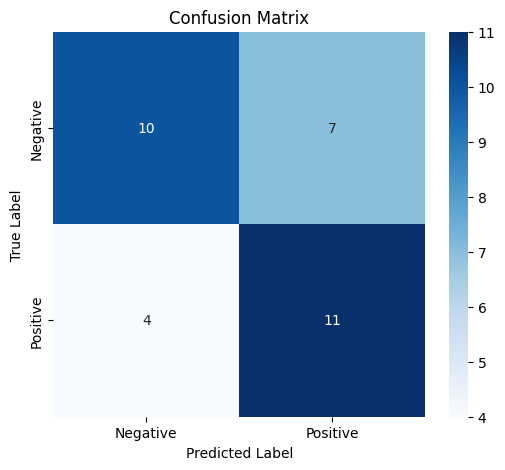

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.59      0.65        17
           1       0.61      0.73      0.67        15

    accuracy                           0.66        32
   macro avg       0.66      0.66      0.66        32
weighted avg       0.67      0.66      0.66        32

Precision: 0.6111
F1 Score: 0.6667


In [32]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, precision_score, f1_score

# Convert lists to numpy arrays
all_true = np.array(all_true)
all_predictions = np.array(all_predictions)

# Compute confusion matrix
conf_matrix = confusion_matrix(all_true, all_predictions)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Compute precision and F1-score
precision = precision_score(all_true, all_predictions)
f1 = f1_score(all_true, all_predictions)

# Print classification report
print("Classification Report:")
print(classification_report(all_true, all_predictions))

# Print precision and F1-score
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")


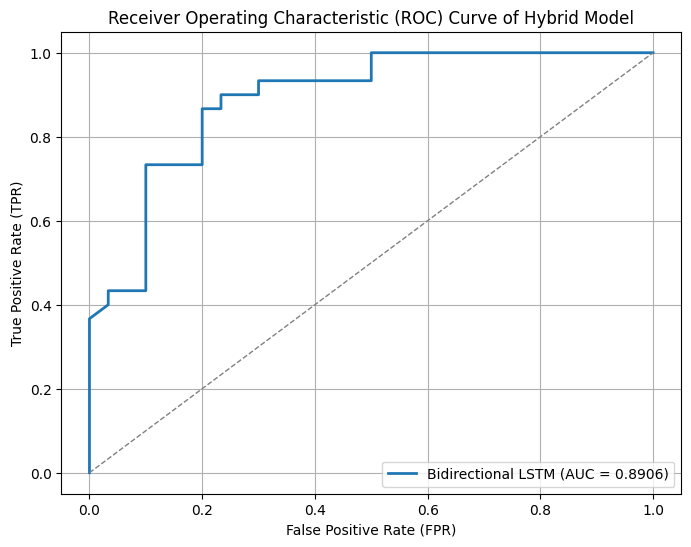

In [17]:
# Convert lists to numpy arrays
fpr_lstm, tpr_lstm, _ = roc_curve(all_true, all_probabilities)
auc_lstm = auc(fpr_lstm, tpr_lstm)
plt.figure(figsize=(8, 6))
plt.plot(fpr_lstm, tpr_lstm, label=f'Bidirectional LSTM (AUC = {auc_lstm:.4f})', linestyle='-', linewidth=2)
plt.plot([0, 1], [0, 1], color='gray', linestyle='dashed', linewidth=1)

# Labels and title
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Receiver Operating Characteristic (ROC) Curve of Hybrid Model")
plt.legend(loc="lower right")
plt.grid()

# Show plot
plt.show()


Comapre Haybrid Model between XCBOOST, SVM, RANDOM FOREST, Bidirectional LSTM

In [18]:
# XGBoost Model
import xgboost as xgb
from sklearn.metrics import roc_auc_score, accuracy_score

xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    random_state=42,
    learning_rate=0.05,
    n_estimators=100,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss"
)

all_proba_xgb = []  # To store predicted probabilities
all_predictions_xgb = []  # To store predicted class labels
all_true_xgb = []  # To store actual test labels

# Cross-validation loop
for train_idx, test_idx in outer_cv.split(X_scaled, y):
    X_train, X_test = X_scaled.iloc[train_idx], X_scaled.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Train XGBoost model
    xgb_model.fit(X_train, y_train)

    # Predict probabilities and convert to binary labels
    y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]
    y_pred_xgb = (y_proba_xgb >= 0.5).astype(int)

    # Store results
    all_proba_xgb.extend(y_proba_xgb)
    all_predictions_xgb.extend(y_pred_xgb)
    all_true_xgb.extend(y_test)

# Compute AUROC and Accuracy
roc_auc_lstm = roc_auc_score(all_true, all_probabilities)  # Assuming all_true exists for LSTM
roc_auc_xgb = roc_auc_score(all_true_xgb, all_proba_xgb)  # Fixed data leakage issue
accuracy_xgb = accuracy_score(all_true_xgb, all_predictions_xgb)  # Accuracy calculation

# Print Results
print("\nHybrid XGBoost Model Evaluation:")
print(f"ROC-AUC Score: {roc_auc_xgb:.4f}")
print(f"Accuracy: {accuracy_xgb:.4f}")



Hybrid XGBoost Model Evaluation:
ROC-AUC Score: 0.7548
Accuracy: 0.7955


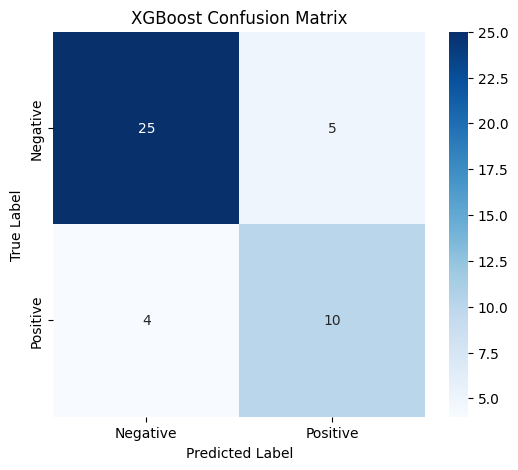


XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.83      0.85        30
           1       0.67      0.71      0.69        14

    accuracy                           0.80        44
   macro avg       0.76      0.77      0.77        44
weighted avg       0.80      0.80      0.80        44

XGBoost Precision: 0.6667
XGBoost F1 Score: 0.6897


In [19]:
# Convert lists to numpy arrays
all_true_xgb = np.array(all_true_xgb)
all_predictions_xgb = np.array(all_predictions_xgb)

# Compute confusion matrix for XGBoost
conf_matrix_xgb = confusion_matrix(all_true_xgb, all_predictions_xgb)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_xgb, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('XGBoost Confusion Matrix')
plt.show()

# Compute precision and F1-score for XGBoost
precision_xgb = precision_score(all_true_xgb, all_predictions_xgb)
f1_xgb = f1_score(all_true_xgb, all_predictions_xgb)

# Print classification report
print("\nXGBoost Classification Report:")
print(classification_report(all_true_xgb, all_predictions_xgb))

# Print precision and F1-score
print(f"XGBoost Precision: {precision_xgb:.4f}")
print(f"XGBoost F1 Score: {f1_xgb:.4f}")


In [20]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Define SVM Model
svm_model = Pipeline([
    ('scaler', StandardScaler()),  # Standardize the features
    ('svm', SVC(kernel='rbf', probability=True, C=1.0, gamma='scale', random_state=42))
])

all_proba_svm = []

# Perform stratified k-fold cross-validation for SVM
for train_idx, test_idx in outer_cv.split(X_scaled, y):
    X_train, X_test = X_scaled.iloc[train_idx], X_scaled.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Train SVM model
    svm_model.fit(X_train, y_train)

    # Get probability predictions
    y_proba_svm = svm_model.predict_proba(X_test)[:, 1]
    all_proba_svm.extend(y_proba_svm)

# Compute AUROC for SVM
roc_auc_svm = roc_auc_score(y, all_proba_svm)
print("Hybrid SVM model:")
print("SVM Model accuracy AUROC:", roc_auc_svm)


Hybrid SVM model:
SVM Model accuracy AUROC: 0.43452380952380953


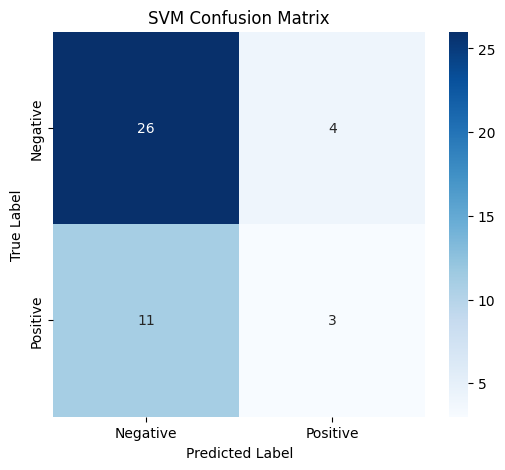


SVM Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.87      0.78        30
           1       0.43      0.21      0.29        14

    accuracy                           0.66        44
   macro avg       0.57      0.54      0.53        44
weighted avg       0.62      0.66      0.62        44

SVM Precision: 0.4286
SVM F1 Score: 0.2857


In [21]:
all_predictions_svm = (np.array(all_proba_svm) >= 0.5).astype(int)  # Convert probabilities to binary labels
all_true_svm = np.array(y)  # True labels

# Compute confusion matrix for SVM
conf_matrix_svm = confusion_matrix(all_true_svm, all_predictions_svm)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_svm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('SVM Confusion Matrix')
plt.show()

# Compute precision and F1-score for SVM
precision_svm = precision_score(all_true_svm, all_predictions_svm)
f1_svm = f1_score(all_true_svm, all_predictions_svm)

# Print classification report
print("\nSVM Classification Report:")
print(classification_report(all_true_svm, all_predictions_svm))

# Print precision and F1-score
print(f"SVM Precision: {precision_svm:.4f}")
print(f"SVM F1 Score: {f1_svm:.4f}")


In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score

# Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, max_depth=6, random_state=42)

all_proba_rf = []
all_preds_rf = []
all_true_rf = []

for train_idx, test_idx in outer_cv.split(X_scaled, y):
    X_train, X_test = X_scaled.iloc[train_idx], X_scaled.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    rf_model.fit(X_train, y_train)

    y_proba_rf = rf_model.predict_proba(X_test)[:, 1]
    y_pred_rf = (y_proba_rf >= 0.5).astype(int)

    all_proba_rf.extend(y_proba_rf)
    all_preds_rf.extend(y_pred_rf)
    all_true_rf.extend(y_test.tolist())

# Compute metrics for Random Forest
roc_auc_rf = roc_auc_score(all_true_rf, all_proba_rf)
accuracy_rf = accuracy_score(all_true_rf, all_preds_rf)

print(f"Hybrid Random Forest AUROC: {roc_auc_rf:.4f}")
print(f"Random Forest Accuracy: {accuracy_rf:.4f}")


Hybrid Random Forest AUROC: 0.7905
Random Forest Accuracy: 0.8182


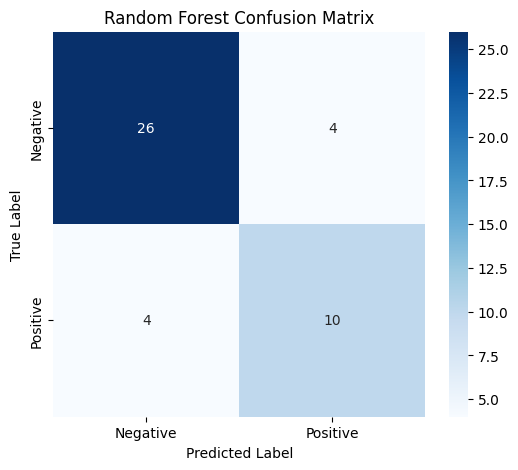


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87        30
           1       0.71      0.71      0.71        14

    accuracy                           0.82        44
   macro avg       0.79      0.79      0.79        44
weighted avg       0.82      0.82      0.82        44

Random Forest Precision: 0.7143
Random Forest F1 Score: 0.7143


In [23]:
# Convert lists to numpy arrays
all_true_rf = np.array(all_true_rf)
all_preds_rf = np.array(all_preds_rf)

# Compute confusion matrix for Random Forest
conf_matrix_rf = confusion_matrix(all_true_rf, all_preds_rf)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Random Forest Confusion Matrix')
plt.show()

# Compute precision and F1-score for Random Forest
precision_rf = precision_score(all_true_rf, all_preds_rf)
f1_rf = f1_score(all_true_rf, all_preds_rf)

# Print classification report
print("\nRandom Forest Classification Report:")
print(classification_report(all_true_rf, all_preds_rf))

# Print precision and F1-score
print(f"Random Forest Precision: {precision_rf:.4f}")
print(f"Random Forest F1 Score: {f1_rf:.4f}")


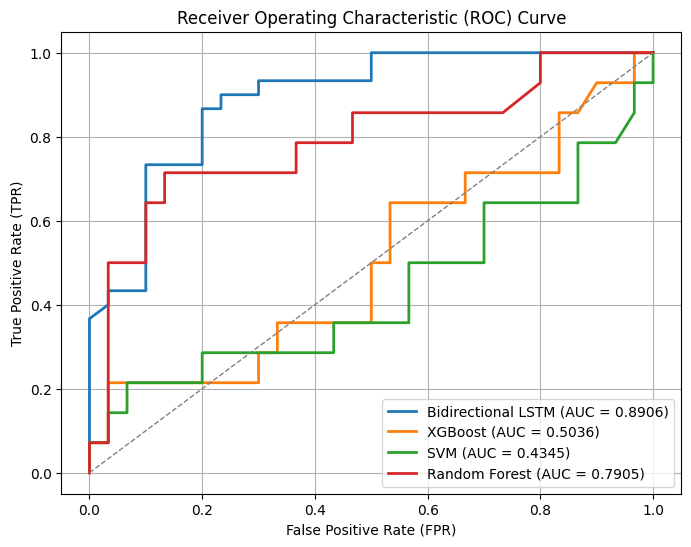

In [24]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Compute ROC curves
fpr_lstm, tpr_lstm, _ = roc_curve(all_true, all_probabilities)
fpr_xgb, tpr_xgb, _ = roc_curve(y, all_proba_xgb)
fpr_svm, tpr_svm, _ = roc_curve(y, all_proba_svm)
fpr_rf, tpr_rf, _ = roc_curve(all_true_rf, all_proba_rf)

# Compute AUC scores
auc_lstm = auc(fpr_lstm, tpr_lstm)
auc_xgb = auc(fpr_xgb, tpr_xgb)
auc_svm = auc(fpr_svm, tpr_svm)
auc_rf = auc(fpr_rf, tpr_rf)

# Plot ROC Curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_lstm, tpr_lstm, label=f'Bidirectional LSTM (AUC = {auc_lstm:.4f})', linestyle='-', linewidth=2)
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.4f})', linestyle='-', linewidth=2)
plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC = {auc_svm:.4f})', linestyle='-', linewidth=2)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.4f})', linestyle='-', linewidth=2)

# Plot random classifier line (baseline)
plt.plot([0, 1], [0, 1], color='gray', linestyle='dashed', linewidth=1)

# Labels and title
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid()

# Show plot
plt.show()


**Universal Model**
*Leave-one-perticpant-out*

In [29]:
from tensorflow.keras.layers import Input

# Ensure groups have the same length as resampled data
groups = np.array([merged_df.loc[merged_df.index[i % len(merged_df)], 'pid'] for i in range(len(y_resampled))])

# Reshape for LSTM
X_reshaped = np.array(X_resampled).reshape(X_resampled.shape[0], 1, X_resampled.shape[1])

# Implement Leave-One-Participant-Out (LOPO) Cross-Validation
logo = LeaveOneGroupOut()
total_auroc = []
all_predictions = []
all_true = []
all_probabilities = []

for train_idx, test_idx in logo.split(X_reshaped, y_resampled, groups=groups):
    X_train, X_test = X_reshaped[train_idx], X_reshaped[test_idx]
    y_train, y_test = y_resampled.iloc[train_idx], y_resampled.iloc[test_idx]

    model = Sequential([
        Input(shape=(X_train.shape[1], X_train.shape[2])),
        Bidirectional(LSTM(128, return_sequences=True)),
        BatchNormalization(),
        Dropout(0.4),
        Bidirectional(LSTM(64, return_sequences=True)),
        BatchNormalization(),
        Dropout(0.4),
        LSTM(32, return_sequences=False),
        BatchNormalization(),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=AdamW(learning_rate=0.0005, weight_decay=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32, callbacks=[early_stopping, lr_scheduler], verbose=0, class_weight=class_weight_dict)

    if len(np.unique(y_test)) > 1:
        y_pred_proba = model.predict(X_test).flatten()
        auc_score = roc_auc_score(y_test, y_pred_proba)
        total_auroc.append(auc_score)

        y_pred = (y_pred_proba >= 0.5).astype(int)
        all_predictions.extend(y_pred)
        all_true.extend(y_test.tolist())
        all_probabilities.extend(y_pred_proba)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 507ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 834ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step


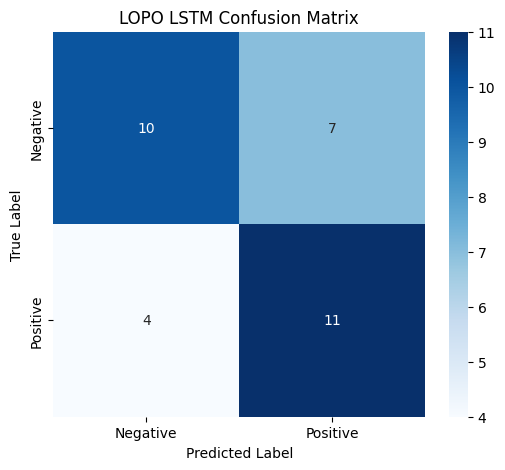


LOPO LSTM Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.59      0.65        17
           1       0.61      0.73      0.67        15

    accuracy                           0.66        32
   macro avg       0.66      0.66      0.66        32
weighted avg       0.67      0.66      0.66        32

LOPO LSTM Precision: 0.6111
LOPO LSTM F1 Score: 0.6667


In [30]:
# Convert lists to numpy arrays
all_true = np.array(all_true)
all_predictions = np.array(all_predictions)

# Compute confusion matrix
conf_matrix = confusion_matrix(all_true, all_predictions)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('LOPO LSTM Confusion Matrix')
plt.show()

# Compute precision and F1-score
precision = precision_score(all_true, all_predictions)
f1 = f1_score(all_true, all_predictions)

# Print classification report
print("\nLOPO LSTM Classification Report:")
print(classification_report(all_true, all_predictions))

# Print precision and F1-score
print(f"LOPO LSTM Precision: {precision:.4f}")
print(f"LOPO LSTM F1 Score: {f1:.4f}")


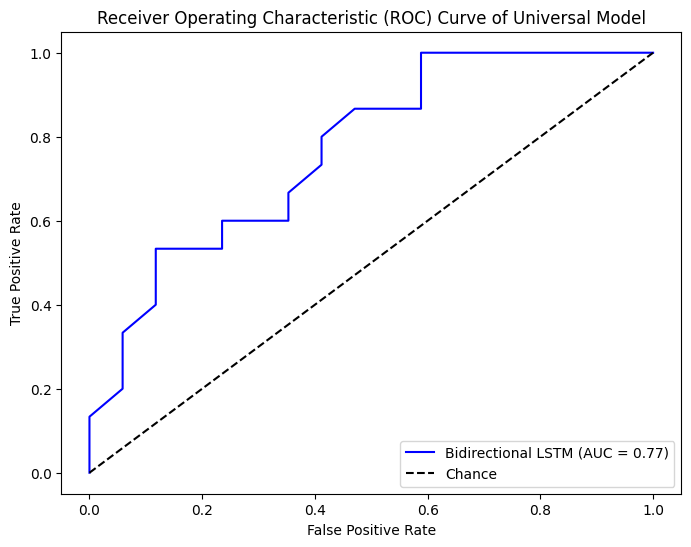

In [31]:
# Plot ROC Curve if valid AUC exists
if total_auroc:
    fpr, tpr, _ = roc_curve(all_true, all_probabilities)
    roc_auc = roc_auc_score(all_true, all_probabilities)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f"Bidirectional LSTM (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], 'k--', label="Chance")
    plt.title("Receiver Operating Characteristic (ROC) Curve of Universal Model")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.show()
